# Factorization Machine Model

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Kaggle_recommenders


Mounted at /content/drive
/content/drive/MyDrive/Kaggle_recommenders


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pathlib import Path
from zipfile import ZipFile
from tensorflow.keras import regularizers




## Loading data and feature extraction
We loadedand merged the different datasets and filtered out the users that are not in the training dataset. With this each row contained information regarding user, the movie and the rating given to the movie by that user. With this information we had: ,

- **Related to the rating:** user_id, movie_id, time of the rating, rating

- **Related to the user:** gender, age,...

- **Related to the movie:** Title, genre

### We extracted some additional features to get a better representation of users:


### Related to movies

- **Relevance of each movie:** We calculated the rating of the 15% movie and all items with equal rating or above were marked as relevant. The relevant value is normalized over the total amount of ratings. This could help us get better results.

- **Movie release year**

- **Age at time of movie release:** we usually have special consideration from movies we saw when we were younger and young people may not appreciate movies from before they were born (negative values).

### User activity

- **Time since rating:** we computed how old the rating is with respect to the last rating made. This could be influential since more recent ratings could be more important.

- **Last movie seen:** we extracted the last movie seen by each user, since it can have an important effect on the next movies we will watch

- **Total ratings:** this will give us an idea of how active a user is.

In [3]:
## FACTORIZATION MODELS

# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-1m.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-1m.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-1m"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")


def load_ratings(movielens_dir):
    COL_NAME = ['uid','mid','rating','timestamp']
    df = pd.read_csv(movielens_dir / 'ratings.dat',sep='::', header=None, engine='python', names=COL_NAME)
    return df

def load_movies(movielens_dir):
    COL_NAME = ['mid','movie_name','movie_genre']
    df = pd.read_csv(movielens_dir / 'movies.dat',sep='::', header=None, engine='python', names=COL_NAME, encoding='latin-1')
    return df

def load_users(movielens_dir):
    COL_NAME = ['uid','user_fea1','user_fea2','user_fea3','user_fea4']
    df = pd.read_csv(movielens_dir / 'users.dat',sep='::', header=None, engine='python', names=COL_NAME)
    return df

def text2seq(text, n_genre):
    """ using tokenizer to encoded the multi-level categorical feature
    """
    tokenizer = Tokenizer(lower=True, split='|',filters='', num_words=n_genre)
    tokenizer.fit_on_texts(text)
    seq = tokenizer.texts_to_sequences(text)
    seq = pad_sequences(seq, maxlen=3,padding='post')
    return seq

n_genre = 15


ratings = load_ratings(movielens_dir)
movies = load_movies(movielens_dir)
users = load_users(movielens_dir)


print("====== rating.dat ======")
print(ratings.head())
print("===== movies.dat ======")
print(movies.head())
print("====== users.dat ======")
print(users.head())

movies['movie_genre'] = text2seq(movies.movie_genre.values, n_genre=n_genre).tolist()

ratings = pd.merge(pd.merge(ratings, users), movies)

print("====== preprocessed data =======")
ratings.head()

5917549/5917549 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Extracting all the files now...
Done!
====== rating.dat ======
   uid   mid  rating  timestamp
0    1  1193       5  978300760
1    1   661       3  978302109
2    1   914       3  978301968
3    1  3408       4  978300275
4    1  2355       5  978824291
===== movies.dat ======
   mid                          movie_name                   movie_genre
0    1                    Toy Story (1995)   Animation|Children's|Comedy
1    2                      Jumanji (1995)  Adventure|Children's|Fantasy
2    3             Grumpier Old Men (1995)                Comedy|Romance
3    4            Waiting to Exhale (1995)                  Comedy|Drama
4    5  Father of the Bride Part II (1995)                        Comedy
====== users.dat ======
   uid user_fea1  user_fea2  user_fea3 user_fea4
0    1         F          1         10     48067
1    2         M         56         16     70072
2    3         M         25         15     55117
3    4        

,uid,mid,rating,timestamp,user_fea1,user_fea2,user_fea3,user_fea4,movie_name,movie_genre
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),"[1, 0, 0]"
1,1,661,3,978302109,F,1,10,48067,James and the Giant Peach (1996),"[9, 13, 0]"
2,1,914,3,978301968,F,1,10,48067,My Fair Lady (1964),"[13, 5, 0]"
3,1,3408,4,978300275,F,1,10,48067,Erin Brockovich (2000),"[1, 0, 0]"
4,1,2355,5,978824291,F,1,10,48067,"Bug's Life, A (1998)","[9, 2, 0]"


Further feature extraction

In [4]:
import re
from sklearn.preprocessing import StandardScaler
normal_transf= StandardScaler()

def get_threshold(user):
    df_aux = ratings[ratings['uid']==user]
    df_aux = df_aux.sort_values(by='rating', ascending=False)
    df_aux.reset_index(inplace = True, drop = True)
    perc_15 =np.trunc(df_aux.shape[0]*15/100)
    thresh = df_aux.loc[perc_15,'rating']
    return float(thresh)


def evaluate_relevance(value,threshold):
    if value>= threshold:
        return 1
    else:
        return 0

def preprocessing_and_extracting(df):
    # Encode sex
    df['user_fea1'] = df['user_fea1'].replace('M',1)
    df['user_fea1'] = df['user_fea1'].replace('F',0)

    #Extract year
    y = re.compile(r'\((\d{4})\)')
    years = [int(y.findall(title)[0]) if y.findall(title) else None for title in df['movie_name']]
    mean_year = sum(year for year in years if year is not None) / len([year for year in years if year is not None]) # we take a mean year to impute for missing years
    df['year'] = [year if year is not None else int(mean_year) for year in years]

    #Last movie seen
    # df['last_seen']=df['timestamp'].apply(lambda x: 1 if x in set_of_timestamp else 0)
    df_grouped = df.groupby('uid').agg({'timestamp': 'max'}).reset_index()
    set_of_timestamp=df_grouped['timestamp'].values
    df['last_seen'] = df['timestamp'].isin(set_of_timestamp).astype(int) # we mark the last movie

    # Mark relevance of each movie using top 15%
    for user in ratings['uid'].unique():
        df_aux = ratings[ratings['uid']==user]
        n_movies = df_aux.shape[0]
        thresh = get_threshold(user)
        ratings.loc[ratings['uid'] == user, 'weight_rating'] = ratings.loc[ratings['uid'] == user,'rating'].apply(lambda x: evaluate_relevance(x, thresh)/n_movies)
    #mean_ratings = df.groupby('uid')['rating'].transform('mean')
    #df['weight_rating'] = np.where(df['rating'] > mean_ratings, 1, -1)  # we mark with 1 movies with high rating and -1 the others




    df['age_difference'] = abs(df['user_fea2'] - (2003 - df['year']))

    df['user_fea2'] = (df['user_fea2']-df['user_fea2'].mean())/(df['user_fea2'].std()) # normalizing the year

    max_timestamp= ratings.groupby('uid')['timestamp'].transform('max')
    df['diff_timestamp'] = df['timestamp'] - max_timestamp
    df['count_ratings']= ratings.groupby('uid')['rating'].transform('count').values

    #NORMALIZATION OF NUMERICAL VALUES

    df['age_difference'] = normal_transf.fit_transform(df['age_difference'].values.reshape(-1, 1))
    df['diff_timestamp'] = normal_transf.fit_transform(df['diff_timestamp'].values.reshape(-1, 1))
    df['count_ratings'] = normal_transf.fit_transform(df['count_ratings'].values.reshape(-1, 1))
    df['user_fea3'] = normal_transf.fit_transform(df['user_fea3'].values.reshape(-1, 1))


    return df



In [5]:
ratings=preprocessing_and_extracting(ratings)
ratings

C:\Users\arturo.fredes\AppData\Local\Temp\ipykernel_9648\3332827205.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['user_fea1'] = df['user_fea1'].replace('F',0)


,uid,mid,rating,timestamp,user_fea1,user_fea2,user_fea3,user_fea4,movie_name,movie_genre,year,last_seen,weight_rating,age_difference,diff_timestamp,count_ratings
0,1,1193,5,978300760,0,-2.445401,0.300683,48067,One Flew Over the Cuckoo's Nest (1975),"[1, 0, 0]",1975,0,0.018868,0.750890,0.575362,-1.037470
1,1,661,3,978302109,0,-2.445401,0.300683,48067,James and the Giant Peach (1996),"[9, 13, 0]",1996,0,0.000000,-1.042190,0.575418,-1.037470
2,1,914,3,978301968,0,-2.445401,0.300683,48067,My Fair Lady (1964),"[13, 5, 0]",1964,0,0.000000,1.690122,0.575413,-1.037470
3,1,3408,4,978300275,0,-2.445401,0.300683,48067,Erin Brockovich (2000),"[1, 0, 0]",2000,0,0.000000,-1.383730,0.575341,-1.037470
4,1,2355,5,978824291,0,-2.445401,0.300683,48067,"Bug's Life, A (1998)","[9, 2, 0]",1998,0,0.018868,-1.212960,0.597446,-1.037470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,1,-0.403193,-0.311749,11106,Weekend at Bernie's (1989),"[2, 0, 0]",1989,0,0.000000,-0.615267,-1.157331,-0.150607
1000205,6040,1094,5,956704887,1,-0.403193,-0.311749,11106,"Crying Game, The (1992)","[1, 5, 11]",1992,0,0.002933,-0.359112,-1.157822,-0.150607
1000206,6040,562,5,956704746,1,-0.403193,-0.311749,11106,Welcome to the Dollhouse (1995),"[2, 1, 0]",1995,0,0.002933,-0.102958,-1.157828,-0.150607
1000207,6040,1096,4,956715648,1,-0.403193,-0.311749,11106,Sophie's Choice (1982),"[1, 0, 0]",1982,0,0.000000,-1.212960,-1.157369,-0.150607


## Building the model

### Define input layers
The dataset contains a **numeric** and **categerical** features, they need to be treated differently.

* **numeric features** can be concatenated to inputs, with shape (None, num_of_numeric)
* **categorical features** can be encoded individually to inputs, with shape (None, 1) each.

In [6]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

def define_input_layers():
    # numerical features
    fea3_input = Input((1,), name='input_fea3')
    fea2_input = Input((1,), name='input_fea2')
    year_input = Input((1,), name='input_year')
    weight_rating_input = Input((1,), name='input_weight_rating')
    age_difference_input = Input((1,), name='input_age_difference')
    diff_timestamp_input = Input((1,), name='input_diff_timestamp')
    count_ratings_input = Input((1,), name='input_count_ratings')

    num_inputs = [fea3_input, fea2_input, year_input, weight_rating_input, age_difference_input,diff_timestamp_input, count_ratings_input]

    # single level categorical features
    uid_input = Input((1,), name='input_uid')  # user_id
    last_seen_input = Input((1,), name='input_last_seen')
    mid_input = Input((1,), name='input_mid')  # movie_id
    cat_sl_inputs = [uid_input, last_seen_input, mid_input]

    # multi level categorical features (with 3 genres at most)
    genre_input = Input((3,), name='input_genre')
    cat_ml_inputs = [genre_input]

    inputs = num_inputs + cat_sl_inputs + cat_ml_inputs

    return inputs

inputs = define_input_layers()


### 1st order factorization machines
1st order will require features to map to a scalar. so for:

* numeric feature: a dense layer will convert tensor to shape (None,1)
* categorical feature: a embedding layer will convert tensor to shape (None,1,1) and then reshape layer to reshape to (None,1)

In [7]:
def Tensor_Mean_Pooling(name = 'mean_pooling', keepdims = False):
    return Lambda(lambda x: K.mean(x, axis = 1, keepdims=keepdims), name = name)

def fm_1d(inputs, n_uid, n_mid, n_genre, reg_weight):

    # user feat3 + user embedding + movie embedding + genre embedding
    fea3_input, fea2_input, year_input, age_difference_input, uid_input, last_seen_input, weight_rating_input, mid_input, genre_input,diff_timestamp_input,count_ratings_input = inputs

    # all tensors are reshape to (None, 1)
    num_dense_1d = [Dense(1, name='num_dense_1d_fea3')(fea3_input),
                    Dense(1, name='num_dense_1d_fea2')(fea2_input),
                    Dense(1, name='num_dense_1d_year')(year_input),
                    Dense(1, name='num_dense_1d_last_seen')(last_seen_input),
                    Dense(1, name='num_dense_1d_weight_rating')(weight_rating_input),
                    Dense(1, name='num_dense_1d_age_difference')(age_difference_input),
                    Dense(1, name='num_dense_1d_diff_timestamp')(diff_timestamp_input),
                    Dense(1, name='num_dense_1d_count_ratings')(count_ratings_input)]

    cat_sl_embed_1d = [Embedding(n_uid + 1, 1, name = 'cat_embed_1d_uid',  embeddings_regularizer=regularizers.l2(reg_weight))(uid_input),
                       Embedding(n_uid + 1, 1, name='cat_embed_1d_lastseen',  embeddings_regularizer=regularizers.l2(reg_weight))(last_seen_input),
                       Embedding(n_mid + 1, 1, name = 'cat_embed_1d_mid',  embeddings_regularizer=regularizers.l2(reg_weight))(mid_input)]
    cat_ml_embed_1d = [Embedding(n_genre + 1, 1, mask_zero=True, name = 'cat_embed_1d_genre', embeddings_regularizer=regularizers.l2(reg_weight))(genre_input)]

    cat_sl_embed_1d = [Reshape((1,))(i) for i in cat_sl_embed_1d]
    cat_ml_embed_1d = [Tensor_Mean_Pooling(name = 'embed_1d_mean')(i) for i in cat_ml_embed_1d]

    # add all tensors
    y_fm_1d = Add(name = 'fm_1d_output')(num_dense_1d + cat_sl_embed_1d + cat_ml_embed_1d)

    return y_fm_1d

#y_1d = fm_1d(inputs, 10, 10, 10)

### 2nd order factorization machines
In 2nd order FM, each feature is map to shape (None, 1, k) and then stack to concat_embed_2d layer with shape (None, p, k).
k - matrix factorization latent dimension, p is feature dimension.

the calculation of interaction terms can be simplified, using
\begin{equation*} \sum{x_ix_j} = \frac{1}{2} \left((\sum{x})^2 - \sum({x}^2)\right) \end{equation*}

Hence, the sum of 2nd order interactions = square of sum of concat_embed_2d - sum of squared concat_embed_2d in p dimension, the resulting tensor will have a shape (None, k)



In [8]:
def fm_2d(inputs, n_uid, n_mid, n_genre, k, reg_weight):

    fea3_input, fea2_input, year_input, age_difference_input, uid_input, last_seen_input, weight_rating_input,mid_input, genre_input,diff_timestamp_input,count_ratings_input = inputs

    num_dense_2d = [Dense(k, name='num_dense_2d_fea3')(fea3_input), # Shape (none,1)
                    Dense(k, name='num_dense_2d_fea2')(fea2_input),
                    Dense(k, name='num_dense_2d_year')(year_input),
                    Dense(k, name='num_dense_2d_last_seen')(last_seen_input),
                    Dense(k, name='num_dense_2d_weight_rating')(weight_rating_input),
                    Dense(k, name='num_dense_2d_age_difference')(age_difference_input),
                    Dense(k, name='num_dense_2d_diff_timestamp')(diff_timestamp_input),
                    Dense(k, name='num_dense_2d_count_ratings')(count_ratings_input)]

    num_dense_2d = [Reshape((1, k))(i) for i in num_dense_2d] #shape (None, 1 , k)


    cat_sl_embed_2d = [Embedding(n_uid + 1, k, name = 'cat_embed_2d_uid',  embeddings_regularizer=regularizers.l2(reg_weight))(uid_input),
                       Embedding(n_uid + 1, k, name='cat_embed_2d_lastseen', embeddings_regularizer=regularizers.l2(reg_weight))(last_seen_input),
                       Embedding(n_mid + 1, k, name = 'cat_embed_2d_mid',  embeddings_regularizer=regularizers.l2(reg_weight))(mid_input)] # shape (None, 1, k)

    cat_ml_embed_2d = [Embedding(n_genre + 1, k, name = 'cat_embed_2d_genre',embeddings_regularizer=regularizers.l2(reg_weight))(genre_input)] # shape (None, 3, k)
    cat_ml_embed_2d = [Tensor_Mean_Pooling(name = 'cat_embed_2d_genure_mean', keepdims=True)(i) for i in cat_ml_embed_2d] # shape (None, 1, k)

    # concatenate all 2d embed layers => (None, ?, k)
    embed_2d = Concatenate(axis=1, name = 'concat_embed_2d')(num_dense_2d + cat_sl_embed_2d + cat_ml_embed_2d)

    # calcuate the interactions by simplication
    # sum of (x1*x2) = sum of (0.5*[(xi)^2 - (xi^2)])
    tensor_sum = Lambda(lambda x: K.sum(x, axis = 1), name = 'sum_of_tensors')
    tensor_square = Lambda(lambda x: K.square(x), name = 'square_of_tensors')

    sum_of_embed = tensor_sum(embed_2d)
    square_of_embed = tensor_square(embed_2d)

    square_of_sum = Multiply()([sum_of_embed, sum_of_embed])
    sum_of_square = tensor_sum(square_of_embed)

    sub = Subtract()([square_of_sum, sum_of_square])
    sub = Lambda(lambda x: x*0.5)(sub)
    y_fm_2d = Reshape((1,), name = 'fm_2d_output')(tensor_sum(sub))

    return y_fm_2d, embed_2d

### Combining everything

In [9]:
def fm_model(n_uid, n_mid, n_genre, k, dnn_dr, reg_weight):

    inputs = define_input_layers()

    y_fm_1d = fm_1d(inputs, n_uid, n_mid, n_genre, reg_weight)
    y_fm_2d, embed_2d = fm_2d(inputs, n_uid, n_mid, n_genre, k, reg_weight)


    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d, y_fm_2d])
    y = Dense(1, name = 'fm_output')(y)

    fm_model_1d = Model(inputs, y_fm_1d)
    fm_model_2d = Model(inputs, y_fm_2d)
    fm_model = Model(inputs, y)

    return fm_model_1d, fm_model_2d, fm_model

In [10]:
params = {
    'n_uid': ratings.uid.nunique(),
    'n_mid': ratings.mid.nunique(),
    'n_genre': 14,
    'k': 30,
    'dnn_dr': 0.5,
    'reg_weight' : 0.01
}

fm_model_1d, fm_model_2d, fm_model = fm_model(**params)

c:\Users\arturo.fredes\AppData\Local\miniconda3\envs\ML\lib\site-packages\keras\src\layers\layer.py:845: UserWarning: Layer 'embed_1d_mean' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [11]:
params

{'n_uid': 6040,
 'n_mid': 3706,
 'n_genre': 14,
 'k': 30,
 'dnn_dr': 0.5,
 'reg_weight': 0.01}

## Preparing Data

### Split Data
We will split the data by taking 80% of the users from the training set and the taking the remaining 20 percent of the users. This way we will generalize to the user which is our problem.

In [12]:
import random
random.seed(42)
df = pd.read_csv('train.csv')# load the train dataset
user_list = df['user_id'].unique()# extract users
n = int(user_list.shape[0]*0.80)


# Use random.choice to select n random users
random_indices = np.random.choice(user_list.shape[0], size=n, replace=False)
train_users = user_list[random_indices]

# Identify elements that were not selected
not_selected_mask = ~np.isin(user_list, train_users)
val_users = user_list[not_selected_mask]

#divide the dataset
train = ratings[ratings['uid'].isin(train_users)]
val= ratings[ratings['uid'].isin(val_users)]

In [13]:
import numpy as np

def df2xy(ratings):
    x = [ratings.user_fea2.values,
         ratings.user_fea3.values,
         ratings.year.values,
         ratings.weight_rating.values,
         ratings.age_difference.values,
         ratings.diff_timestamp.values,
         ratings.count_ratings.values,
         ratings.uid.values,
         ratings.last_seen.values,
         ratings.mid.values,
         np.concatenate(ratings.movie_genre.values).reshape(-1, 3)]
    y = ratings.rating.values
    return x, y

train_x, train_y = df2xy(train)
valid_x, valid_y = df2xy(val)


## Training the Model

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

fm_model.compile(
    loss=tf.keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(learning_rate=0.001)
)

model_checkpoint_path = './fm_weightsbest.weights.h5'

early_stop = EarlyStopping(monitor='val_loss', patience=5)
model_ckp = ModelCheckpoint(filepath=model_checkpoint_path,
                            monitor='val_loss',
                            save_weights_only=True,
                            save_best_only=True)

callbacks = [model_ckp, early_stop]

train_history = fm_model.fit(train_x, train_y,
                              epochs=30, batch_size=64,
                              validation_data=(valid_x, valid_y),
                              callbacks=callbacks)


Epoch 1/30


c:\Users\arturo.fredes\AppData\Local\miniconda3\envs\ML\lib\site-packages\keras\src\layers\layer.py:845: UserWarning: Layer 'embed_1d_mean' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


12621/12621 ━━━━━━━━━━━━━━━━━━━━ 138s 10ms/step - loss: 93785481216.0000 - val_loss: 85262.0781
Epoch 2/30
12621/12621 ━━━━━━━━━━━━━━━━━━━━ 119s 9ms/step - loss: 5234954.5000 - val_loss: 55330.0625
Epoch 3/30
12621/12621 ━━━━━━━━━━━━━━━━━━━━ 121s 10ms/step - loss: 150960.0625 - val_loss: 15.1200
Epoch 4/30
12621/12621 ━━━━━━━━━━━━━━━━━━━━ 117s 9ms/step - loss: 10.5862 - val_loss: 1.2858
Epoch 5/30
12621/12621 ━━━━━━━━━━━━━━━━━━━━ 108s 9ms/step - loss: 29.1411 - val_loss: 1.3591
Epoch 6/30
12621/12621 ━━━━━━━━━━━━━━━━━━━━ 106s 8ms/step - loss: 51.7287 - val_loss: 1.3588
Epoch 7/30
12621/12621 ━━━━━━━━━━━━━━━━━━━━ 107s 8ms/step - loss: 32.8334 - val_loss: 1.3481
Epoch 8/30
12621/12621 ━━━━━━━━━━━━━━━━━━━━ 109s 9ms/step - loss: 2.5640 - val_loss: 16.6735
Epoch 9/30
12621/12621 ━━━━━━━━━━━━━━━━━━━━ 112s 9ms/step - loss: 1.6333 - val_loss: 1.2468
Epoch 10/30
12621/12621 ━━━━━━━━━━━━━━━━━━━━ 108s 9ms/step - loss: 422.8338 - val_loss: 1.1874
Epoch 11/30
12621/12621 ━━━━━━━━━━━━━━━━━━━━ 108s 9

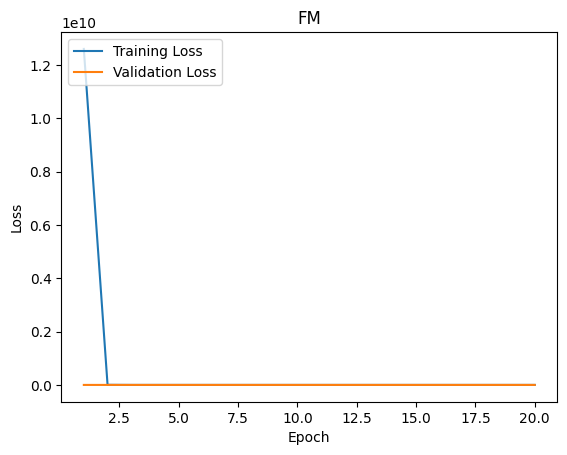

In [21]:
import matplotlib.pyplot as plt
train_loss = train_history.history['loss']
epochs = range(1, len(train_loss) + 1)

# Extract the validation loss values
val_loss = train_history.history['val_loss']

# Plot the training loss and validation loss vs. epoch
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('FM')
plt.legend(loc='upper left')
plt.show()


## Predictions (Score = )

In [22]:
test =pd.read_csv('./kaggle_baseline.csv')
test
# I have to produce the output for all of these users.


,user_id,prediction
0,850,260 1210 480 2028 589 1270 593 1580 110 2396 1...
1,2012,2858 2028 593 608 2762 110 2396 1617 527 2997 ...
2,1511,2858 260 480 589 1270 593 1580 608 2762 110 23...
3,5846,1196 1210 480 2028 589 2571 1270 1580 1198 276...
4,4344,593 2716 1 3578 2987 919 3175 924 1387 2355 10...
...,...,...
6032,421,2858 1196 260 480 2028 589 2571 1270 593 1580 ...
6033,4393,1196 260 480 2028 589 1270 593 1580 608 1198 2...
6034,3455,1196 260 1210 480 2028 589 2571 1270 593 1580 ...
6035,2714,1196 1210 480 2028 589 2571 1270 593 1198 2762...


In [23]:
def create_test_dataset(user_id, ratings):

    movies_seen_by_user = ratings[ratings['uid'] == user_id]['mid'].unique()

    all_movies_except_seen = ratings[~ratings['mid'].isin(movies_seen_by_user)]


    test_dataset = pd.DataFrame({'uid': [user_id] * len(np.unique(all_movies_except_seen['mid'].values)),
                                 'mid': np.unique(all_movies_except_seen['mid'].values)})

    # We retrieve additional information
    movies_info = ratings[~ratings['mid'].isin(movies_seen_by_user)][['mid', 'movie_name', 'movie_genre', 'timestamp','diff_timestamp']]

    movies_info = movies_info.drop_duplicates(subset=['mid'])

    test_dataset = pd.merge(test_dataset, movies_info, on='mid', how='left')

    # Extract the year
    test_dataset['year'] = ratings['movie_name'].str.extract(r'\((\d{4})\)')
    test_dataset['year'] = test_dataset['year'].astype(float)

    # And fill missing year
    mean_year = test_dataset['year'].mean()
    test_dataset['year'] = test_dataset['year'].fillna(mean_year).astype(int)

    # Calcola la feature last_seen
    last_seen = ratings.groupby('uid')['timestamp'].max().reset_index()
    last_seen.rename(columns={'timestamp': 'last_seen'}, inplace=True)
    test_dataset = pd.merge(test_dataset, last_seen, on='uid', how='left')
    test_dataset['last_seen'] = test_dataset['last_seen'].notnull().astype(int)
    test_dataset['last_seen']= np.zeros(len(np.unique(all_movies_except_seen['mid'].values))) # Because he never saw these movies

    # Retreive user_fea2 and user_fea3
    test_dataset['user_fea2'] = ratings[ratings['uid'] == user_id]['user_fea2'].iloc[0]
    test_dataset['user_fea3'] = ratings[ratings['uid'] == user_id]['user_fea3'].iloc[0]
    test_dataset['user_fea2'] = (test_dataset['user_fea2']-test_dataset['user_fea2'].mean())/(test_dataset['user_fea2'].std()) # normalizing the year
    test_dataset['age_difference'] = abs(test_dataset['user_fea2'] - (2003 - test_dataset['year']))
    test_dataset['count_ratings'] = ratings[ratings['uid']==user_id].iloc[0]['count_ratings']
    test_dataset['weight_rating'] = 0.



    return test_dataset


def get_prediction(test_dataset):

    predictions = fm_model.predict(x = [test_dataset.user_fea2.values,
                                  test_dataset.user_fea3.values,
                                  test_dataset.year.values,
                                  test_dataset.weight_rating.values,
                                  test_dataset.age_difference.values,
                                  test_dataset.diff_timestamp.values,
                                  test_dataset.count_ratings.values,
                                  test_dataset.uid.values,
                                  test_dataset.last_seen.values,
                                  test_dataset.mid.values,
                                  np.concatenate(test_dataset.movie_genre.values).reshape(-1, 3)])

    # We add the prediction column
    test_dataset['prediction'] = predictions

    # Sort and then retreive the movie id
    top_recommendations = test_dataset.sort_values(by='prediction', ascending=False).head(25)
    recommended_movie_ids = top_recommendations['mid'].tolist()

    return recommended_movie_ids




In [25]:
# Create the output
import csv
from tqdm import tqdm
from tensorflow.keras.models import load_model

# open the file in the write mode
with open('./solution.csv', 'w', encoding='UTF8') as f:
    # create the csv writer
    writer = csv.writer(f)
    # write a row to the csv file
    writer.writerow(['user_id', 'prediction'])

    # iterate over unique user_ids with tqdm
    for user_id in tqdm(test.user_id.unique(), desc="Processing Users"):
        test_set_user=create_test_dataset(user_id,ratings)
        relevant_items = get_prediction(test_set_user)
        list_relevants = ' '.join([str(elem) for elem in relevant_items])
        writer.writerow([str(user_id), list_relevants])

Processing Users:   0%|          | 0/6037 [00:00<?, ?it/s]

22/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   

c:\Users\arturo.fredes\AppData\Local\miniconda3\envs\ML\lib\site-packages\keras\src\layers\layer.py:845: UserWarning: Layer 'embed_1d_mean' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users:   0%|          | 1/6037 [00:04<7:33:18,  4.51s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   0%|          | 2/6037 [00:07<6:15:56,  3.74s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   0%|          | 3/6037 [00:10<5:43:01,  3.41s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   0%|          | 4/6037 [00:14<5:39:26,  3.38s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   0%|          | 5/6037 [00:16<5:21:24,  3.20s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   0%|          | 6/6037 [00:20<5:29:00,  3.27s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   0%|          | 7/6037 [00:23<5:22:00,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   0%|          | 8/6037 [00:26<5:16:52,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   0%|          | 9/6037 [00:29<5:22:24,  3.21s/it]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   0%|          | 10/6037 [00:32<5:19:45,  3.18s/it]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   0%|          | 11/6037 [00:35<5:08:48,  3.07s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   0%|          | 12/6037 [00:39<5:19:48,  3.18s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   0%|          | 13/6037 [00:42<5:14:37,  3.13s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   0%|          | 14/6037 [00:45<5:25:52,  3.25s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   0%|          | 15/6037 [00:48<5:26:20,  3.25s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   0%|          | 16/6037 [00:51<5:18:51,  3.18s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   0%|          | 17/6037 [00:55<5:18:32,  3.17s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   0%|          | 18/6037 [00:58<5:22:28,  3.21s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   0%|          | 19/6037 [01:01<5:10:11,  3.09s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   0%|          | 20/6037 [01:04<5:09:37,  3.09s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   0%|          | 21/6037 [01:07<5:04:19,  3.04s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   0%|          | 22/6037 [01:10<5:09:25,  3.09s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   0%|          | 23/6037 [01:13<5:14:47,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   0%|          | 24/6037 [01:16<5:08:09,  3.07s/it]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   0%|          | 25/6037 [01:19<5:07:20,  3.07s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   0%|          | 26/6037 [01:22<5:13:23,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   0%|          | 27/6037 [01:25<5:09:29,  3.09s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   0%|          | 28/6037 [01:29<5:09:35,  3.09s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   0%|          | 29/6037 [01:32<5:17:26,  3.17s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   0%|          | 30/6037 [01:35<5:15:59,  3.16s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 31/6037 [01:38<5:02:46,  3.02s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 32/6037 [01:41<5:06:23,  3.06s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 33/6037 [01:44<5:09:41,  3.09s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 34/6037 [01:47<5:06:31,  3.06s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 35/6037 [01:50<5:12:23,  3.12s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 36/6037 [01:53<5:08:30,  3.08s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 37/6037 [01:56<5:05:19,  3.05s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 38/6037 [01:59<5:08:40,  3.09s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 39/6037 [02:02<5:06:31,  3.07s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 40/6037 [02:06<5:05:49,  3.06s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 41/6037 [02:09<5:10:54,  3.11s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 42/6037 [02:12<5:02:17,  3.03s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 43/6037 [02:15<5:13:30,  3.14s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 44/6037 [02:18<5:13:08,  3.14s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 45/6037 [02:21<5:05:55,  3.06s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 46/6037 [02:24<5:09:20,  3.10s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 47/6037 [02:27<5:12:32,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   1%|          | 48/6037 [02:30<5:08:22,  3.09s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 49/6037 [02:34<5:14:57,  3.16s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 50/6037 [02:37<5:09:51,  3.11s/it]

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 51/6037 [02:40<5:10:47,  3.12s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 52/6037 [02:43<5:09:43,  3.10s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 53/6037 [02:46<5:00:28,  3.01s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 54/6037 [02:49<5:06:14,  3.07s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 55/6037 [02:52<5:10:47,  3.12s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 56/6037 [02:55<5:05:42,  3.07s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 57/6037 [02:58<5:03:35,  3.05s/it]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 58/6037 [03:01<5:09:07,  3.10s/it]

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 59/6037 [03:04<5:05:59,  3.07s/it]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   1%|          | 60/6037 [03:07<4:57:50,  2.99s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 61/6037 [03:10<5:02:56,  3.04s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 62/6037 [03:13<5:06:12,  3.07s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 63/6037 [03:16<5:01:17,  3.03s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   1%|          | 64/6037 [03:20<5:07:12,  3.09s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 65/6037 [03:23<5:09:11,  3.11s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 66/6037 [03:26<5:03:04,  3.05s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 67/6037 [03:29<5:09:41,  3.11s/it]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   1%|          | 68/6037 [03:31<4:53:15,  2.95s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 69/6037 [03:35<5:09:42,  3.11s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 70/6037 [03:38<5:01:35,  3.03s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 71/6037 [03:41<5:05:07,  3.07s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 72/6037 [03:44<5:06:15,  3.08s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 73/6037 [03:47<5:15:19,  3.17s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 74/6037 [03:51<5:15:00,  3.17s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|          | 75/6037 [03:54<5:08:36,  3.11s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|▏         | 76/6037 [03:56<4:53:38,  2.96s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|▏         | 77/6037 [03:59<5:00:59,  3.03s/it]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|▏         | 78/6037 [04:02<5:03:22,  3.05s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|▏         | 79/6037 [04:05<5:01:12,  3.03s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|▏         | 80/6037 [04:09<5:07:58,  3.10s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|▏         | 81/6037 [04:12<5:09:20,  3.12s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|▏         | 82/6037 [04:15<4:58:08,  3.00s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|▏         | 83/6037 [04:18<5:00:02,  3.02s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|▏         | 84/6037 [04:21<5:11:31,  3.14s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|▏         | 85/6037 [04:24<5:12:16,  3.15s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   1%|▏         | 86/6037 [04:27<5:05:33,  3.08s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|▏         | 87/6037 [04:30<5:08:28,  3.11s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|▏         | 88/6037 [04:33<5:03:22,  3.06s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|▏         | 89/6037 [04:37<5:08:00,  3.11s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   1%|▏         | 90/6037 [04:39<5:02:34,  3.05s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   2%|▏         | 91/6037 [04:42<5:00:26,  3.03s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 92/6037 [04:46<5:12:58,  3.16s/it]

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 93/6037 [04:49<4:59:59,  3.03s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 94/6037 [04:52<5:08:37,  3.12s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 95/6037 [04:55<5:09:03,  3.12s/it]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 96/6037 [04:58<4:55:38,  2.99s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   2%|▏         | 97/6037 [05:01<5:02:53,  3.06s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 98/6037 [05:04<5:01:13,  3.04s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 99/6037 [05:07<4:50:11,  2.93s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 100/6037 [05:10<4:48:28,  2.92s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 101/6037 [05:13<4:54:49,  2.98s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 102/6037 [05:16<4:57:54,  3.01s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 103/6037 [05:19<4:50:18,  2.94s/it]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 104/6037 [05:21<4:44:54,  2.88s/it]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   2%|▏         | 105/6037 [05:24<4:46:37,  2.90s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 106/6037 [05:27<4:46:06,  2.89s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 107/6037 [05:30<4:55:11,  2.99s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 108/6037 [05:33<4:55:34,  2.99s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 109/6037 [05:36<4:46:10,  2.90s/it]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   2%|▏         | 110/6037 [05:39<4:47:37,  2.91s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 111/6037 [05:42<4:48:28,  2.92s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 112/6037 [05:44<4:38:28,  2.82s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 113/6037 [05:48<4:46:46,  2.90s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 114/6037 [05:51<4:54:54,  2.99s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   2%|▏         | 115/6037 [05:54<4:48:42,  2.93s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 116/6037 [05:57<4:59:12,  3.03s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 117/6037 [06:00<4:58:13,  3.02s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 118/6037 [06:03<4:51:00,  2.95s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 119/6037 [06:05<4:47:47,  2.92s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   2%|▏         | 120/6037 [06:08<4:41:11,  2.85s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 121/6037 [06:11<4:53:02,  2.97s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 122/6037 [06:14<4:53:03,  2.97s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 123/6037 [06:17<4:52:35,  2.97s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 124/6037 [06:20<4:53:51,  2.98s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   2%|▏         | 125/6037 [06:23<4:58:04,  3.03s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 126/6037 [06:27<5:07:41,  3.12s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 127/6037 [06:30<5:00:05,  3.05s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 128/6037 [06:33<5:02:16,  3.07s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 129/6037 [06:36<4:58:50,  3.03s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 130/6037 [06:39<4:58:36,  3.03s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 131/6037 [06:42<5:06:36,  3.11s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 132/6037 [06:45<5:05:33,  3.10s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 133/6037 [06:48<4:54:23,  2.99s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 134/6037 [06:51<4:56:30,  3.01s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 135/6037 [06:54<5:01:48,  3.07s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 136/6037 [06:57<4:48:50,  2.94s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 137/6037 [07:00<4:48:29,  2.93s/it]

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 138/6037 [07:02<4:39:41,  2.84s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   2%|▏         | 139/6037 [07:06<4:55:16,  3.00s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 140/6037 [07:09<4:55:01,  3.00s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 141/6037 [07:12<4:50:11,  2.95s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 142/6037 [07:15<4:51:24,  2.97s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 143/6037 [07:18<4:57:28,  3.03s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 144/6037 [07:20<4:49:21,  2.95s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 145/6037 [07:24<5:01:05,  3.07s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 146/6037 [07:27<4:53:52,  2.99s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 147/6037 [07:30<4:59:09,  3.05s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 148/6037 [07:33<5:01:26,  3.07s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 149/6037 [07:36<4:53:28,  2.99s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   2%|▏         | 150/6037 [07:39<4:53:08,  2.99s/it]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 151/6037 [07:41<4:42:26,  2.88s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 152/6037 [07:44<4:50:28,  2.96s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 153/6037 [07:48<4:54:42,  3.01s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   3%|▎         | 154/6037 [07:50<4:49:02,  2.95s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 155/6037 [07:53<4:42:46,  2.88s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 156/6037 [07:56<4:50:20,  2.96s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 157/6037 [07:59<4:51:18,  2.97s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 158/6037 [08:02<4:48:16,  2.94s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 159/6037 [08:05<4:58:28,  3.05s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 160/6037 [08:08<4:53:46,  3.00s/it]

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 161/6037 [08:11<4:43:10,  2.89s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 162/6037 [08:14<4:51:37,  2.98s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 163/6037 [08:17<4:43:27,  2.90s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 164/6037 [08:20<4:53:11,  3.00s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 165/6037 [08:23<5:00:45,  3.07s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 166/6037 [08:26<4:53:43,  3.00s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 167/6037 [08:29<4:56:03,  3.03s/it]

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 168/6037 [08:32<4:51:24,  2.98s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 169/6037 [08:35<4:44:06,  2.90s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 170/6037 [08:38<4:43:04,  2.89s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 171/6037 [08:41<4:53:10,  3.00s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 172/6037 [08:44<4:54:33,  3.01s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 173/6037 [08:47<4:47:17,  2.94s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 174/6037 [08:50<4:48:52,  2.96s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   3%|▎         | 175/6037 [08:53<4:47:45,  2.95s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 176/6037 [08:56<4:54:17,  3.01s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 177/6037 [08:59<4:57:01,  3.04s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 178/6037 [09:02<4:48:49,  2.96s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 179/6037 [09:05<4:53:50,  3.01s/it]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 180/6037 [09:08<4:44:40,  2.92s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 181/6037 [09:11<4:53:00,  3.00s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 182/6037 [09:14<4:52:16,  3.00s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 183/6037 [09:17<4:48:44,  2.96s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 184/6037 [09:20<4:48:40,  2.96s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 185/6037 [09:23<4:53:06,  3.01s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 186/6037 [09:25<4:42:48,  2.90s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 187/6037 [09:28<4:43:50,  2.91s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   3%|▎         | 188/6037 [09:32<4:55:55,  3.04s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 189/6037 [09:35<4:53:16,  3.01s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 190/6037 [09:37<4:49:36,  2.97s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 191/6037 [09:40<4:49:57,  2.98s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 192/6037 [09:44<4:53:05,  3.01s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 193/6037 [09:46<4:46:54,  2.95s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 194/6037 [09:50<4:56:43,  3.05s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 195/6037 [09:53<4:56:47,  3.05s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 196/6037 [09:55<4:47:55,  2.96s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 197/6037 [09:58<4:47:04,  2.95s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 198/6037 [10:01<4:48:14,  2.96s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 199/6037 [10:04<4:44:54,  2.93s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 200/6037 [10:07<4:48:56,  2.97s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   3%|▎         | 201/6037 [10:10<4:56:03,  3.04s/it]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 202/6037 [10:13<4:54:16,  3.03s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 203/6037 [10:16<4:49:09,  2.97s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 204/6037 [10:19<4:51:28,  3.00s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 205/6037 [10:22<4:47:30,  2.96s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 206/6037 [10:25<4:37:05,  2.85s/it]

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   3%|▎         | 207/6037 [10:28<4:43:28,  2.92s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 208/6037 [10:31<4:51:57,  3.01s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 209/6037 [10:34<5:02:06,  3.11s/it]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   3%|▎         | 210/6037 [10:37<4:50:45,  2.99s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   3%|▎         | 211/6037 [10:41<5:02:08,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▎         | 212/6037 [10:44<5:10:48,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▎         | 213/6037 [10:47<5:03:25,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   4%|▎         | 214/6037 [10:50<5:06:57,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▎         | 215/6037 [10:53<4:58:51,  3.08s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▎         | 216/6037 [10:56<5:05:49,  3.15s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▎         | 217/6037 [10:59<5:04:21,  3.14s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   4%|▎         | 218/6037 [11:02<4:56:47,  3.06s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▎         | 219/6037 [11:05<4:53:22,  3.03s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▎         | 220/6037 [11:08<4:51:57,  3.01s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▎         | 221/6037 [11:11<4:42:42,  2.92s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   4%|▎         | 222/6037 [11:14<4:54:47,  3.04s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▎         | 223/6037 [11:17<4:49:27,  2.99s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▎         | 224/6037 [11:20<4:53:55,  3.03s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   4%|▎         | 225/6037 [11:24<4:58:51,  3.09s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   4%|▎         | 226/6037 [11:27<5:05:32,  3.15s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 227/6037 [11:30<5:12:36,  3.23s/it]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 228/6037 [11:33<5:09:56,  3.20s/it]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 229/6037 [11:36<4:54:46,  3.05s/it]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   4%|▍         | 230/6037 [11:39<4:46:51,  2.96s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 231/6037 [11:42<4:56:27,  3.06s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 232/6037 [11:45<4:57:04,  3.07s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 233/6037 [11:48<4:51:49,  3.02s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   4%|▍         | 234/6037 [11:51<4:53:43,  3.04s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 235/6037 [11:54<5:00:15,  3.10s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 236/6037 [11:57<4:53:23,  3.03s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 237/6037 [12:01<5:02:12,  3.13s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   4%|▍         | 238/6037 [12:03<4:53:29,  3.04s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 239/6037 [12:07<4:52:45,  3.03s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 240/6037 [12:10<4:52:31,  3.03s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 241/6037 [12:13<4:51:16,  3.02s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   4%|▍         | 242/6037 [12:16<4:59:39,  3.10s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 243/6037 [12:19<4:59:23,  3.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 244/6037 [12:22<4:55:30,  3.06s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 245/6037 [12:25<4:55:50,  3.06s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   4%|▍         | 246/6037 [12:28<5:03:20,  3.14s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 247/6037 [12:31<4:54:35,  3.05s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 248/6037 [12:34<4:53:33,  3.04s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 249/6037 [12:37<4:59:52,  3.11s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 250/6037 [12:40<4:50:55,  3.02s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 251/6037 [12:43<4:49:21,  3.00s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 252/6037 [12:46<4:50:45,  3.02s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 253/6037 [12:49<4:49:04,  3.00s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 254/6037 [12:52<4:38:10,  2.89s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 255/6037 [12:55<4:44:33,  2.95s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 256/6037 [12:58<4:36:09,  2.87s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 257/6037 [13:00<4:33:38,  2.84s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 258/6037 [13:03<4:37:05,  2.88s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 259/6037 [13:06<4:30:46,  2.81s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 260/6037 [13:09<4:41:04,  2.92s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 261/6037 [13:12<4:33:09,  2.84s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 262/6037 [13:15<4:41:22,  2.92s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 263/6037 [13:18<4:46:48,  2.98s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 264/6037 [13:21<4:41:34,  2.93s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 265/6037 [13:24<4:39:19,  2.90s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 266/6037 [13:27<4:44:09,  2.95s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 267/6037 [13:29<4:35:46,  2.87s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 268/6037 [13:32<4:35:29,  2.87s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 269/6037 [13:35<4:41:52,  2.93s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 270/6037 [13:38<4:37:22,  2.89s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   4%|▍         | 271/6037 [13:41<4:39:57,  2.91s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 272/6037 [13:44<4:46:42,  2.98s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 273/6037 [13:47<4:38:48,  2.90s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 274/6037 [13:50<4:48:21,  3.00s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 275/6037 [13:53<4:44:29,  2.96s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 276/6037 [13:56<4:38:40,  2.90s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 277/6037 [13:59<4:40:52,  2.93s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 278/6037 [14:02<4:43:39,  2.96s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 279/6037 [14:04<4:30:36,  2.82s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 280/6037 [14:07<4:33:01,  2.85s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 281/6037 [14:10<4:41:53,  2.94s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 282/6037 [14:13<4:43:17,  2.95s/it]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   5%|▍         | 283/6037 [14:16<4:40:33,  2.93s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 284/6037 [14:20<4:51:30,  3.04s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 285/6037 [14:24<5:22:23,  3.36s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 286/6037 [14:27<5:08:23,  3.22s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 287/6037 [14:30<5:13:26,  3.27s/it]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 288/6037 [14:33<4:56:55,  3.10s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 289/6037 [14:36<4:57:32,  3.11s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 290/6037 [14:39<4:56:38,  3.10s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 291/6037 [14:42<4:52:50,  3.06s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 292/6037 [14:45<4:48:43,  3.02s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 293/6037 [14:48<4:51:24,  3.04s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 294/6037 [14:51<4:46:49,  3.00s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 295/6037 [14:54<4:51:08,  3.04s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 296/6037 [14:57<4:41:33,  2.94s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 297/6037 [15:00<4:48:21,  3.01s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 298/6037 [15:03<4:49:53,  3.03s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 299/6037 [15:06<4:48:50,  3.02s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 300/6037 [15:09<4:53:13,  3.07s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▍         | 301/6037 [15:12<4:43:46,  2.97s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 302/6037 [15:15<4:53:58,  3.08s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 303/6037 [15:18<4:48:18,  3.02s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 304/6037 [15:21<4:48:49,  3.02s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 305/6037 [15:24<4:58:49,  3.13s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 306/6037 [15:28<5:03:17,  3.18s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 307/6037 [15:30<4:52:29,  3.06s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 308/6037 [15:34<4:53:08,  3.07s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 309/6037 [15:37<4:53:13,  3.07s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 310/6037 [15:39<4:43:01,  2.97s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 311/6037 [15:42<4:43:49,  2.97s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 312/6037 [15:46<4:50:00,  3.04s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 313/6037 [15:49<4:54:12,  3.08s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 314/6037 [15:52<4:47:25,  3.01s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 315/6037 [15:55<4:46:16,  3.00s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 316/6037 [15:58<4:51:50,  3.06s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 317/6037 [16:00<4:40:23,  2.94s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 318/6037 [16:04<4:50:36,  3.05s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 319/6037 [16:07<4:51:12,  3.06s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 320/6037 [16:10<4:42:03,  2.96s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 321/6037 [16:12<4:31:47,  2.85s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 322/6037 [16:15<4:42:29,  2.97s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 323/6037 [16:18<4:41:03,  2.95s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 324/6037 [16:22<4:49:54,  3.04s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 325/6037 [16:24<4:43:28,  2.98s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 326/6037 [16:27<4:45:29,  3.00s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 327/6037 [16:30<4:47:49,  3.02s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 328/6037 [16:33<4:40:52,  2.95s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 329/6037 [16:36<4:45:35,  3.00s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 330/6037 [16:40<4:56:25,  3.12s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 331/6037 [16:43<4:50:02,  3.05s/it]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   5%|▌         | 332/6037 [16:46<4:44:45,  2.99s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 333/6037 [16:49<4:55:41,  3.11s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 334/6037 [16:52<4:44:55,  3.00s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 335/6037 [16:55<4:54:18,  3.10s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 336/6037 [16:58<4:56:31,  3.12s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 337/6037 [17:01<4:47:50,  3.03s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 338/6037 [17:04<4:46:56,  3.02s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 339/6037 [17:07<4:42:16,  2.97s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 340/6037 [17:10<4:51:47,  3.07s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 341/6037 [17:13<4:44:55,  3.00s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 342/6037 [17:16<4:45:33,  3.01s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 343/6037 [17:19<4:52:47,  3.09s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 344/6037 [17:22<4:44:30,  3.00s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   6%|▌         | 345/6037 [17:25<4:48:16,  3.04s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 346/6037 [17:29<4:58:17,  3.14s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 347/6037 [17:32<5:00:48,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 348/6037 [17:35<5:05:56,  3.23s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   6%|▌         | 349/6037 [17:39<5:19:19,  3.37s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 350/6037 [17:42<5:23:12,  3.41s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 351/6037 [17:45<5:10:00,  3.27s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 352/6037 [17:49<5:13:47,  3.31s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 353/6037 [17:52<5:11:29,  3.29s/it]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 354/6037 [17:55<5:13:08,  3.31s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 355/6037 [17:58<5:06:08,  3.23s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 356/6037 [18:02<5:09:40,  3.27s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 357/6037 [18:05<5:08:15,  3.26s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 358/6037 [18:08<4:59:12,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 359/6037 [18:11<5:02:10,  3.19s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 360/6037 [18:14<4:58:38,  3.16s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 361/6037 [18:17<4:44:42,  3.01s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 362/6037 [18:20<4:49:13,  3.06s/it]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 363/6037 [18:23<4:56:17,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 364/6037 [18:27<5:02:41,  3.20s/it]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 365/6037 [18:30<4:51:33,  3.08s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 366/6037 [18:33<4:51:25,  3.08s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 367/6037 [18:36<4:52:19,  3.09s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 368/6037 [18:39<4:46:25,  3.03s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 369/6037 [18:42<4:55:25,  3.13s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 370/6037 [18:45<4:58:12,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 371/6037 [18:48<4:54:24,  3.12s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 372/6037 [18:51<4:52:23,  3.10s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 373/6037 [18:55<4:57:45,  3.15s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 374/6037 [18:58<4:56:37,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 375/6037 [19:01<5:08:18,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 376/6037 [19:05<5:09:12,  3.28s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▌         | 377/6037 [19:08<5:00:11,  3.18s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▋         | 378/6037 [19:11<5:02:12,  3.20s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▋         | 379/6037 [19:14<4:59:53,  3.18s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▋         | 380/6037 [19:17<4:52:05,  3.10s/it]

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▋         | 381/6037 [19:20<4:55:47,  3.14s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▋         | 382/6037 [19:23<5:00:06,  3.18s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▋         | 383/6037 [19:26<4:55:24,  3.13s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▋         | 384/6037 [19:30<4:58:45,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▋         | 385/6037 [19:33<5:02:23,  3.21s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▋         | 386/6037 [19:36<4:53:28,  3.12s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▋         | 387/6037 [19:39<5:05:22,  3.24s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▋         | 388/6037 [19:42<4:57:38,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▋         | 389/6037 [19:46<5:06:11,  3.25s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▋         | 390/6037 [19:49<5:05:39,  3.25s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▋         | 391/6037 [19:52<4:58:39,  3.17s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   6%|▋         | 392/6037 [19:55<5:00:00,  3.19s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 393/6037 [19:58<4:51:47,  3.10s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 394/6037 [20:02<5:22:47,  3.43s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 395/6037 [20:05<5:13:27,  3.33s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 396/6037 [20:08<5:04:16,  3.24s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 397/6037 [20:12<5:04:40,  3.24s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 398/6037 [20:15<4:55:42,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 399/6037 [20:18<5:00:07,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 400/6037 [20:21<4:51:28,  3.10s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 401/6037 [20:24<4:49:48,  3.09s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 402/6037 [20:27<4:59:09,  3.19s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   7%|▋         | 403/6037 [20:31<5:00:20,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   7%|▋         | 404/6037 [20:34<5:12:03,  3.32s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 405/6037 [20:37<5:05:18,  3.25s/it]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 406/6037 [20:41<5:24:14,  3.45s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 407/6037 [20:44<5:17:40,  3.39s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 408/6037 [20:47<5:04:18,  3.24s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 409/6037 [20:51<5:11:04,  3.32s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 410/6037 [20:54<5:08:08,  3.29s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 411/6037 [20:57<4:59:51,  3.20s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 412/6037 [21:00<5:03:04,  3.23s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 413/6037 [21:03<4:57:01,  3.17s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 414/6037 [21:07<5:07:20,  3.28s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 415/6037 [21:10<5:01:10,  3.21s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   7%|▋         | 416/6037 [21:13<5:02:48,  3.23s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 417/6037 [21:17<5:06:22,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 418/6037 [21:20<4:59:54,  3.20s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 419/6037 [21:23<4:59:50,  3.20s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 420/6037 [21:26<5:04:40,  3.25s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 421/6037 [21:30<5:08:10,  3.29s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 422/6037 [21:33<5:00:06,  3.21s/it]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 423/6037 [21:36<4:58:07,  3.19s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 424/6037 [21:39<5:00:22,  3.21s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 425/6037 [21:42<4:54:18,  3.15s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 426/6037 [21:45<4:58:36,  3.19s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 427/6037 [21:49<5:00:38,  3.22s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 428/6037 [21:51<4:53:12,  3.14s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 429/6037 [21:55<4:55:35,  3.16s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 430/6037 [21:58<4:49:20,  3.10s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 431/6037 [22:01<4:58:21,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 432/6037 [22:05<5:06:16,  3.28s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 433/6037 [22:07<4:52:54,  3.14s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 434/6037 [22:11<4:55:07,  3.16s/it]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 435/6037 [22:14<4:53:02,  3.14s/it]

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 436/6037 [22:16<4:43:37,  3.04s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 437/6037 [22:20<4:53:07,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 438/6037 [22:23<4:49:15,  3.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 439/6037 [22:26<5:02:18,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 440/6037 [22:30<5:05:39,  3.28s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 441/6037 [22:33<4:58:25,  3.20s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 442/6037 [22:36<5:00:24,  3.22s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 443/6037 [22:39<5:01:57,  3.24s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 444/6037 [22:42<4:51:50,  3.13s/it]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 445/6037 [22:46<4:58:12,  3.20s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 446/6037 [22:49<4:51:47,  3.13s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 447/6037 [22:52<5:03:03,  3.25s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 448/6037 [22:55<4:55:29,  3.17s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 449/6037 [22:58<4:52:08,  3.14s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 450/6037 [23:01<4:53:06,  3.15s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 451/6037 [23:04<4:53:25,  3.15s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   7%|▋         | 452/6037 [23:07<4:44:45,  3.06s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 453/6037 [23:10<4:48:38,  3.10s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 454/6037 [23:14<5:01:50,  3.24s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 455/6037 [23:17<5:01:52,  3.24s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 456/6037 [23:20<4:52:51,  3.15s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 457/6037 [23:23<4:50:51,  3.13s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 458/6037 [23:27<4:52:58,  3.15s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 459/6037 [23:29<4:45:38,  3.07s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 460/6037 [23:33<5:01:04,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 461/6037 [23:36<5:06:17,  3.30s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 462/6037 [23:39<4:57:10,  3.20s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 463/6037 [23:43<4:54:44,  3.17s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 464/6037 [23:46<4:57:22,  3.20s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 465/6037 [23:49<4:51:12,  3.14s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 466/6037 [23:52<4:49:23,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 467/6037 [23:55<5:00:58,  3.24s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 468/6037 [23:59<4:58:34,  3.22s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 469/6037 [24:02<4:52:45,  3.15s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 470/6037 [24:05<4:58:02,  3.21s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 471/6037 [24:08<5:01:36,  3.25s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 472/6037 [24:11<4:51:50,  3.15s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 473/6037 [24:15<5:01:24,  3.25s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 474/6037 [24:18<4:53:58,  3.17s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 475/6037 [24:21<4:59:04,  3.23s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 476/6037 [24:24<4:57:28,  3.21s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 477/6037 [24:27<4:57:56,  3.22s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   8%|▊         | 478/6037 [24:31<5:18:32,  3.44s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 479/6037 [24:35<5:23:58,  3.50s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 480/6037 [24:38<5:08:00,  3.33s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 481/6037 [24:41<5:03:16,  3.28s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 482/6037 [24:44<5:01:54,  3.26s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   8%|▊         | 483/6037 [24:47<4:49:25,  3.13s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   8%|▊         | 484/6037 [24:51<5:07:46,  3.33s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Processing Users:   8%|▊         | 485/6037 [24:55<5:25:12,  3.51s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 486/6037 [24:59<5:36:02,  3.63s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   8%|▊         | 487/6037 [25:02<5:29:44,  3.56s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 488/6037 [25:05<5:12:56,  3.38s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 489/6037 [25:08<5:04:26,  3.29s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 490/6037 [25:12<5:09:58,  3.35s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 491/6037 [25:15<4:59:08,  3.24s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 492/6037 [25:18<4:56:11,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 493/6037 [25:21<5:05:59,  3.31s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 494/6037 [25:24<4:54:25,  3.19s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 495/6037 [25:27<4:53:10,  3.17s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 496/6037 [25:31<4:51:25,  3.16s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 497/6037 [25:34<5:06:22,  3.32s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 498/6037 [25:37<5:04:46,  3.30s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 499/6037 [25:40<4:53:27,  3.18s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 500/6037 [25:44<4:53:58,  3.19s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 501/6037 [25:47<4:56:06,  3.21s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 502/6037 [25:50<4:59:29,  3.25s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 503/6037 [25:54<5:06:21,  3.32s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 504/6037 [25:57<5:06:17,  3.32s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 505/6037 [26:00<4:57:08,  3.22s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 506/6037 [26:03<4:57:38,  3.23s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 507/6037 [26:06<4:57:00,  3.22s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 508/6037 [26:09<4:48:52,  3.13s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 509/6037 [26:13<4:57:21,  3.23s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 510/6037 [26:16<4:59:13,  3.25s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 511/6037 [26:19<4:52:05,  3.17s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 512/6037 [26:22<4:57:52,  3.23s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   8%|▊         | 513/6037 [26:26<4:55:06,  3.21s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▊         | 514/6037 [26:29<4:48:34,  3.14s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▊         | 515/6037 [26:32<4:56:40,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▊         | 516/6037 [26:35<5:02:11,  3.28s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▊         | 517/6037 [26:38<4:55:22,  3.21s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▊         | 518/6037 [26:42<4:57:41,  3.24s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▊         | 519/6037 [26:45<4:53:27,  3.19s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▊         | 520/6037 [26:48<4:46:53,  3.12s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▊         | 521/6037 [26:51<4:55:40,  3.22s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▊         | 522/6037 [26:54<4:42:19,  3.07s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▊         | 523/6037 [26:58<4:58:23,  3.25s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▊         | 524/6037 [27:01<5:02:49,  3.30s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▊         | 525/6037 [27:04<4:56:19,  3.23s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▊         | 526/6037 [27:07<4:59:44,  3.26s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▊         | 527/6037 [27:11<5:04:53,  3.32s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▊         | 528/6037 [27:14<4:55:21,  3.22s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 529/6037 [27:17<5:01:35,  3.29s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 530/6037 [27:20<4:55:56,  3.22s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 531/6037 [27:24<5:04:58,  3.32s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 532/6037 [27:27<5:04:54,  3.32s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 533/6037 [27:30<4:59:15,  3.26s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 534/6037 [27:34<4:57:08,  3.24s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 535/6037 [27:37<5:00:24,  3.28s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 536/6037 [27:40<4:52:01,  3.19s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 537/6037 [27:43<4:50:19,  3.17s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 538/6037 [27:46<4:52:17,  3.19s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 539/6037 [27:50<4:58:56,  3.26s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 540/6037 [27:53<5:00:43,  3.28s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 541/6037 [27:56<4:51:02,  3.18s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 542/6037 [27:59<4:54:03,  3.21s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 543/6037 [28:03<5:01:42,  3.29s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 544/6037 [28:06<4:55:50,  3.23s/it]

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 545/6037 [28:09<4:50:41,  3.18s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 546/6037 [28:12<5:00:22,  3.28s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 547/6037 [28:15<4:52:58,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 548/6037 [28:19<4:56:27,  3.24s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   9%|▉         | 549/6037 [28:22<5:06:15,  3.35s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 550/6037 [28:25<4:57:01,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 551/6037 [28:29<5:04:12,  3.33s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 552/6037 [28:32<4:55:08,  3.23s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 553/6037 [28:35<4:48:42,  3.16s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 554/6037 [28:38<4:49:38,  3.17s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 555/6037 [28:41<4:45:35,  3.13s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 556/6037 [28:45<4:57:30,  3.26s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 557/6037 [28:48<4:59:02,  3.27s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 558/6037 [28:51<4:54:25,  3.22s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 559/6037 [28:54<4:56:11,  3.24s/it]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:   9%|▉         | 560/6037 [28:58<4:56:11,  3.24s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 561/6037 [29:01<4:52:16,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 562/6037 [29:04<5:05:58,  3.35s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 563/6037 [29:08<4:57:49,  3.26s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 564/6037 [29:11<5:07:51,  3.38s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 565/6037 [29:15<5:07:40,  3.37s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 566/6037 [29:17<4:55:27,  3.24s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 567/6037 [29:21<4:50:19,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 568/6037 [29:24<4:58:15,  3.27s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 569/6037 [29:27<4:52:24,  3.21s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 570/6037 [29:30<4:48:23,  3.17s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 571/6037 [29:34<5:03:58,  3.34s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 572/6037 [29:37<5:08:49,  3.39s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:   9%|▉         | 573/6037 [29:41<5:03:38,  3.33s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 574/6037 [29:44<4:59:33,  3.29s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 575/6037 [29:47<4:58:43,  3.28s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 576/6037 [29:50<4:47:32,  3.16s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 577/6037 [29:53<4:54:33,  3.24s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 578/6037 [29:56<4:42:18,  3.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 579/6037 [29:59<4:50:14,  3.19s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 580/6037 [30:02<4:45:18,  3.14s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 581/6037 [30:06<4:45:45,  3.14s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 582/6037 [30:09<4:45:34,  3.14s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 583/6037 [30:12<4:38:31,  3.06s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 584/6037 [30:15<4:34:44,  3.02s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 585/6037 [30:18<4:44:23,  3.13s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 586/6037 [30:21<4:46:14,  3.15s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 587/6037 [30:24<4:38:08,  3.06s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 588/6037 [30:27<4:37:35,  3.06s/it]

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 589/6037 [30:30<4:29:07,  2.96s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 590/6037 [30:33<4:30:19,  2.98s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  10%|▉         | 591/6037 [30:36<4:29:01,  2.96s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 592/6037 [30:39<4:39:44,  3.08s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 593/6037 [30:42<4:43:06,  3.12s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 594/6037 [30:45<4:38:21,  3.07s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 595/6037 [30:48<4:40:26,  3.09s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 596/6037 [30:52<4:42:24,  3.11s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 597/6037 [30:54<4:34:50,  3.03s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 598/6037 [30:58<4:45:51,  3.15s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 599/6037 [31:01<4:38:53,  3.08s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 600/6037 [31:04<4:40:18,  3.09s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 601/6037 [31:07<4:46:24,  3.16s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 602/6037 [31:10<4:39:08,  3.08s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|▉         | 603/6037 [31:13<4:39:20,  3.08s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 604/6037 [31:17<4:46:12,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 605/6037 [31:20<4:48:45,  3.19s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 606/6037 [31:23<4:40:48,  3.10s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 607/6037 [31:26<4:42:16,  3.12s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 608/6037 [31:29<4:34:31,  3.03s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 609/6037 [31:32<4:37:13,  3.06s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 610/6037 [31:35<4:41:07,  3.11s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 611/6037 [31:38<4:33:02,  3.02s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 612/6037 [31:41<4:41:10,  3.11s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 613/6037 [31:44<4:29:17,  2.98s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 614/6037 [31:47<4:37:51,  3.07s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 615/6037 [31:50<4:41:55,  3.12s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 616/6037 [31:53<4:33:38,  3.03s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 617/6037 [31:56<4:39:27,  3.09s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 618/6037 [32:00<4:38:39,  3.09s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 619/6037 [32:03<4:37:16,  3.07s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 620/6037 [32:06<4:38:44,  3.09s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 621/6037 [32:08<4:29:49,  2.99s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 622/6037 [32:12<4:41:23,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 623/6037 [32:15<4:45:52,  3.17s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 624/6037 [32:18<4:37:23,  3.07s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 625/6037 [32:21<4:38:45,  3.09s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 626/6037 [32:24<4:41:44,  3.12s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 627/6037 [32:27<4:35:33,  3.06s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 628/6037 [32:31<4:44:09,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 629/6037 [32:33<4:37:18,  3.08s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 630/6037 [32:37<4:44:13,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 631/6037 [32:40<4:46:33,  3.18s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 632/6037 [32:43<4:32:45,  3.03s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  10%|█         | 633/6037 [32:46<4:29:10,  2.99s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 634/6037 [32:49<4:38:10,  3.09s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 635/6037 [32:52<4:31:40,  3.02s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 636/6037 [32:55<4:32:55,  3.03s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 637/6037 [32:58<4:33:56,  3.04s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 638/6037 [33:01<4:38:39,  3.10s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 639/6037 [33:04<4:38:57,  3.10s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 640/6037 [33:07<4:30:05,  3.00s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 641/6037 [33:10<4:30:42,  3.01s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 642/6037 [33:13<4:32:31,  3.03s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 643/6037 [33:16<4:23:37,  2.93s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 644/6037 [33:19<4:29:14,  3.00s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 645/6037 [33:22<4:36:28,  3.08s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 646/6037 [33:25<4:35:46,  3.07s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 647/6037 [33:28<4:29:50,  3.00s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 648/6037 [33:31<4:31:17,  3.02s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 649/6037 [33:34<4:35:24,  3.07s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 650/6037 [33:37<4:28:22,  2.99s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 651/6037 [33:41<4:40:23,  3.12s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 652/6037 [33:43<4:31:39,  3.03s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 653/6037 [33:47<4:32:59,  3.04s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 654/6037 [33:50<4:40:10,  3.12s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 655/6037 [33:53<4:29:47,  3.01s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 656/6037 [33:56<4:33:36,  3.05s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 657/6037 [33:59<4:43:08,  3.16s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 658/6037 [34:02<4:40:53,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 659/6037 [34:05<4:34:59,  3.07s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 660/6037 [34:08<4:36:49,  3.09s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 661/6037 [34:11<4:37:46,  3.10s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 662/6037 [34:14<4:28:59,  3.00s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 663/6037 [34:18<4:41:24,  3.14s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 664/6037 [34:21<4:34:07,  3.06s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 665/6037 [34:24<4:39:24,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 666/6037 [34:27<4:40:35,  3.13s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 667/6037 [34:30<4:39:05,  3.12s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 668/6037 [34:33<4:45:38,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 669/6037 [34:36<4:39:01,  3.12s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 670/6037 [34:40<4:42:26,  3.16s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 671/6037 [34:43<4:42:34,  3.16s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 672/6037 [34:46<4:35:12,  3.08s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 673/6037 [34:49<4:39:43,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 674/6037 [34:52<4:34:37,  3.07s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 675/6037 [34:55<4:37:34,  3.11s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 676/6037 [34:58<4:37:12,  3.10s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 677/6037 [35:01<4:29:10,  3.01s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 678/6037 [35:04<4:36:32,  3.10s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█         | 679/6037 [35:07<4:32:53,  3.06s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█▏        | 680/6037 [35:10<4:39:52,  3.13s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█▏        | 681/6037 [35:14<4:38:43,  3.12s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█▏        | 682/6037 [35:16<4:28:31,  3.01s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█▏        | 683/6037 [35:19<4:30:34,  3.03s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█▏        | 684/6037 [35:23<4:38:45,  3.12s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█▏        | 685/6037 [35:26<4:35:59,  3.09s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█▏        | 686/6037 [35:29<4:36:17,  3.10s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█▏        | 687/6037 [35:32<4:42:15,  3.17s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█▏        | 688/6037 [35:35<4:34:11,  3.08s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█▏        | 689/6037 [35:38<4:33:32,  3.07s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█▏        | 690/6037 [35:41<4:38:48,  3.13s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█▏        | 691/6037 [35:45<4:38:52,  3.13s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█▏        | 692/6037 [35:47<4:30:35,  3.04s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█▏        | 693/6037 [35:50<4:32:31,  3.06s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  11%|█▏        | 694/6037 [35:53<4:31:39,  3.05s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 695/6037 [35:57<4:33:31,  3.07s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 696/6037 [36:00<4:36:15,  3.10s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 697/6037 [36:03<4:28:28,  3.02s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 698/6037 [36:06<4:38:14,  3.13s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 699/6037 [36:09<4:31:55,  3.06s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 700/6037 [36:12<4:39:25,  3.14s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 701/6037 [36:15<4:36:34,  3.11s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 702/6037 [36:18<4:29:58,  3.04s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 703/6037 [36:21<4:28:40,  3.02s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 704/6037 [36:24<4:36:30,  3.11s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 705/6037 [36:27<4:33:03,  3.07s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 706/6037 [36:30<4:29:37,  3.03s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 707/6037 [36:34<4:37:22,  3.12s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 708/6037 [36:36<4:25:56,  2.99s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 709/6037 [36:40<4:30:13,  3.04s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 710/6037 [36:43<4:39:25,  3.15s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  12%|█▏        | 711/6037 [36:46<4:34:52,  3.10s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 712/6037 [36:49<4:41:54,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 713/6037 [36:52<4:43:41,  3.20s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 714/6037 [36:55<4:35:32,  3.11s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 715/6037 [36:58<4:34:44,  3.10s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 716/6037 [37:01<4:23:10,  2.97s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 717/6037 [37:04<4:33:50,  3.09s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 718/6037 [37:08<4:33:11,  3.08s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 719/6037 [37:10<4:22:11,  2.96s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 720/6037 [37:13<4:21:00,  2.95s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 721/6037 [37:17<4:32:58,  3.08s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 722/6037 [37:20<4:33:35,  3.09s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 723/6037 [37:23<4:38:19,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 724/6037 [37:26<4:31:09,  3.06s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 725/6037 [37:29<4:32:03,  3.07s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 726/6037 [37:32<4:41:31,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 727/6037 [37:35<4:34:52,  3.11s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 728/6037 [37:38<4:34:16,  3.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 729/6037 [37:42<4:43:33,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 730/6037 [37:45<4:35:01,  3.11s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 731/6037 [37:48<4:31:06,  3.07s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 732/6037 [37:51<4:40:30,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 733/6037 [37:54<4:42:41,  3.20s/it]

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 734/6037 [37:57<4:31:00,  3.07s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 735/6037 [38:00<4:32:13,  3.08s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 736/6037 [38:03<4:31:41,  3.08s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 737/6037 [38:06<4:22:31,  2.97s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 738/6037 [38:09<4:34:08,  3.10s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 739/6037 [38:12<4:28:08,  3.04s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 740/6037 [38:16<4:37:38,  3.14s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 741/6037 [38:19<4:36:02,  3.13s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 742/6037 [38:22<4:33:20,  3.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 743/6037 [38:25<4:40:56,  3.18s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 744/6037 [38:28<4:37:44,  3.15s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 745/6037 [38:31<4:30:19,  3.06s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 746/6037 [38:34<4:31:27,  3.08s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 747/6037 [38:38<4:39:29,  3.17s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 748/6037 [38:40<4:31:14,  3.08s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 749/6037 [38:44<4:31:54,  3.09s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 750/6037 [38:47<4:42:48,  3.21s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 751/6037 [38:50<4:32:33,  3.09s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 752/6037 [38:53<4:29:22,  3.06s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 753/6037 [38:56<4:36:43,  3.14s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  12%|█▏        | 754/6037 [38:59<4:37:54,  3.16s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 755/6037 [39:02<4:29:50,  3.07s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 756/6037 [39:05<4:28:37,  3.05s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 757/6037 [39:08<4:27:09,  3.04s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 758/6037 [39:11<4:24:29,  3.01s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 759/6037 [39:14<4:30:07,  3.07s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 760/6037 [39:17<4:25:17,  3.02s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 761/6037 [39:20<4:24:50,  3.01s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 762/6037 [39:24<4:33:30,  3.11s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 763/6037 [39:26<4:24:35,  3.01s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 764/6037 [39:30<4:26:12,  3.03s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 765/6037 [39:33<4:35:29,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 766/6037 [39:36<4:31:51,  3.09s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 767/6037 [39:39<4:39:27,  3.18s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 768/6037 [39:42<4:38:16,  3.17s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 769/6037 [39:45<4:30:35,  3.08s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 770/6037 [39:48<4:28:06,  3.05s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 771/6037 [39:51<4:28:45,  3.06s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 772/6037 [39:54<4:20:32,  2.97s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 773/6037 [39:58<4:32:10,  3.10s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 774/6037 [40:00<4:28:20,  3.06s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 775/6037 [40:03<4:23:42,  3.01s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 776/6037 [40:06<4:23:32,  3.01s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 777/6037 [40:09<4:26:31,  3.04s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 778/6037 [40:12<4:22:45,  3.00s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 779/6037 [40:16<4:33:56,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 780/6037 [40:19<4:30:48,  3.09s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 781/6037 [40:22<4:35:25,  3.14s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 782/6037 [40:25<4:34:32,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 783/6037 [40:28<4:29:39,  3.08s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 784/6037 [40:31<4:30:08,  3.09s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 785/6037 [40:35<4:35:59,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 786/6037 [40:37<4:28:57,  3.07s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 787/6037 [40:41<4:29:24,  3.08s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 788/6037 [40:44<4:41:18,  3.22s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 789/6037 [40:47<4:32:30,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 790/6037 [40:50<4:32:32,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 791/6037 [40:53<4:40:11,  3.20s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 792/6037 [40:56<4:27:08,  3.06s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 793/6037 [40:59<4:32:18,  3.12s/it]

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 794/6037 [41:02<4:28:42,  3.08s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 795/6037 [41:05<4:23:03,  3.01s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 796/6037 [41:08<4:21:03,  2.99s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 797/6037 [41:11<4:24:56,  3.03s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 798/6037 [41:14<4:19:29,  2.97s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 799/6037 [41:17<4:22:20,  3.00s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 800/6037 [41:21<4:31:19,  3.11s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 801/6037 [41:24<4:34:28,  3.15s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 802/6037 [41:27<4:28:59,  3.08s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 803/6037 [41:30<4:30:50,  3.10s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 804/6037 [41:33<4:25:57,  3.05s/it]

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 805/6037 [41:36<4:22:50,  3.01s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 806/6037 [41:39<4:31:22,  3.11s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 807/6037 [41:42<4:22:13,  3.01s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 808/6037 [41:45<4:32:03,  3.12s/it]

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 809/6037 [41:48<4:21:55,  3.01s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 810/6037 [41:51<4:31:47,  3.12s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 811/6037 [41:55<4:33:06,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 812/6037 [41:58<4:28:48,  3.09s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 813/6037 [42:01<4:27:46,  3.08s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  13%|█▎        | 814/6037 [42:04<4:27:12,  3.07s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▎        | 815/6037 [42:07<4:36:48,  3.18s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▎        | 816/6037 [42:10<4:36:43,  3.18s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▎        | 817/6037 [42:13<4:26:28,  3.06s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▎        | 818/6037 [42:16<4:24:54,  3.05s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▎        | 819/6037 [42:19<4:26:19,  3.06s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▎        | 820/6037 [42:22<4:19:45,  2.99s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▎        | 821/6037 [42:26<4:33:25,  3.15s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▎        | 822/6037 [42:29<4:32:20,  3.13s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▎        | 823/6037 [42:31<4:24:54,  3.05s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▎        | 824/6037 [42:35<4:29:42,  3.10s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▎        | 825/6037 [42:38<4:23:44,  3.04s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▎        | 826/6037 [42:41<4:28:25,  3.09s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▎        | 827/6037 [42:44<4:24:51,  3.05s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▎        | 828/6037 [42:47<4:32:01,  3.13s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▎        | 829/6037 [42:50<4:30:29,  3.12s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▎        | 830/6037 [42:53<4:23:45,  3.04s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 831/6037 [42:56<4:26:05,  3.07s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 832/6037 [42:59<4:21:36,  3.02s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 833/6037 [43:02<4:15:48,  2.95s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 834/6037 [43:05<4:24:14,  3.05s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 835/6037 [43:08<4:25:42,  3.06s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 836/6037 [43:11<4:30:25,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 837/6037 [43:15<4:36:13,  3.19s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 838/6037 [43:18<4:35:03,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 839/6037 [43:21<4:30:05,  3.12s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 840/6037 [43:24<4:28:55,  3.10s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 841/6037 [43:27<4:20:18,  3.01s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 842/6037 [43:30<4:32:09,  3.14s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 843/6037 [43:33<4:31:26,  3.14s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 844/6037 [43:36<4:25:28,  3.07s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 845/6037 [43:39<4:25:34,  3.07s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 846/6037 [43:43<4:29:29,  3.11s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 847/6037 [43:45<4:20:05,  3.01s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 848/6037 [43:49<4:30:09,  3.12s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 849/6037 [43:52<4:21:17,  3.02s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 850/6037 [43:55<4:30:27,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 851/6037 [43:58<4:33:50,  3.17s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 852/6037 [44:01<4:23:20,  3.05s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 853/6037 [44:04<4:30:22,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 854/6037 [44:08<4:37:21,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 855/6037 [44:11<4:32:56,  3.16s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 856/6037 [44:14<4:26:11,  3.08s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 857/6037 [44:17<4:31:08,  3.14s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 858/6037 [44:20<4:31:01,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 859/6037 [44:23<4:26:56,  3.09s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 860/6037 [44:26<4:27:38,  3.10s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 861/6037 [44:30<4:35:57,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 862/6037 [44:33<4:31:09,  3.14s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 863/6037 [44:36<4:32:39,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 864/6037 [44:39<4:41:47,  3.27s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 865/6037 [44:42<4:32:47,  3.16s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 866/6037 [44:45<4:29:50,  3.13s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 867/6037 [44:49<4:35:32,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 868/6037 [44:52<4:38:54,  3.24s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 869/6037 [44:55<4:29:11,  3.13s/it]

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 870/6037 [44:58<4:24:01,  3.07s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 871/6037 [45:01<4:19:53,  3.02s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 872/6037 [45:04<4:21:46,  3.04s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 873/6037 [45:07<4:26:41,  3.10s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 874/6037 [45:10<4:17:49,  3.00s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  14%|█▍        | 875/6037 [45:13<4:27:13,  3.11s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 876/6037 [45:16<4:21:05,  3.04s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 877/6037 [45:19<4:30:00,  3.14s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 878/6037 [45:22<4:26:56,  3.10s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 879/6037 [45:25<4:19:45,  3.02s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 880/6037 [45:28<4:20:15,  3.03s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 881/6037 [45:32<4:28:39,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 882/6037 [45:35<4:24:51,  3.08s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 883/6037 [45:38<4:26:58,  3.11s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 884/6037 [45:41<4:31:29,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 885/6037 [45:44<4:26:28,  3.10s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 886/6037 [45:47<4:25:14,  3.09s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 887/6037 [45:50<4:32:27,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 888/6037 [45:54<4:33:52,  3.19s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 889/6037 [45:56<4:17:42,  3.00s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 890/6037 [45:59<4:17:09,  3.00s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 891/6037 [46:02<4:13:05,  2.95s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 892/6037 [46:05<4:18:02,  3.01s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 893/6037 [46:08<4:18:44,  3.02s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 894/6037 [46:11<4:13:01,  2.95s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 895/6037 [46:14<4:22:59,  3.07s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 896/6037 [46:17<4:16:46,  3.00s/it]

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 897/6037 [46:20<4:19:40,  3.03s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 898/6037 [46:23<4:23:00,  3.07s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 899/6037 [46:26<4:21:16,  3.05s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 900/6037 [46:29<4:18:40,  3.02s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 901/6037 [46:33<4:23:48,  3.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 902/6037 [46:36<4:20:13,  3.04s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 903/6037 [46:39<4:28:59,  3.14s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 904/6037 [46:42<4:25:59,  3.11s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▍        | 905/6037 [46:45<4:28:39,  3.14s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 906/6037 [46:48<4:30:02,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 907/6037 [46:51<4:22:51,  3.07s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 908/6037 [46:54<4:25:21,  3.10s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 909/6037 [46:57<4:16:55,  3.01s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 910/6037 [47:01<4:24:19,  3.09s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 911/6037 [47:04<4:29:51,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 912/6037 [47:07<4:24:55,  3.10s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 913/6037 [47:10<4:24:35,  3.10s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 914/6037 [47:13<4:26:12,  3.12s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 915/6037 [47:16<4:18:46,  3.03s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 916/6037 [47:19<4:30:12,  3.17s/it]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 917/6037 [47:22<4:18:40,  3.03s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 918/6037 [47:25<4:23:38,  3.09s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 919/6037 [47:28<4:23:28,  3.09s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 920/6037 [47:31<4:21:16,  3.06s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 921/6037 [47:35<4:27:26,  3.14s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 922/6037 [47:38<4:30:00,  3.17s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 923/6037 [47:41<4:23:29,  3.09s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 924/6037 [47:44<4:23:33,  3.09s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 925/6037 [47:47<4:20:59,  3.06s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 926/6037 [47:50<4:23:31,  3.09s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 927/6037 [47:53<4:30:09,  3.17s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 928/6037 [47:57<4:31:21,  3.19s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 929/6037 [48:00<4:22:57,  3.09s/it]

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 930/6037 [48:03<4:19:57,  3.05s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 931/6037 [48:06<4:25:13,  3.12s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 932/6037 [48:09<4:17:36,  3.03s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 933/6037 [48:12<4:17:08,  3.02s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 934/6037 [48:15<4:17:53,  3.03s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  15%|█▌        | 935/6037 [48:18<4:28:38,  3.16s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 936/6037 [48:21<4:22:27,  3.09s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 937/6037 [48:24<4:19:39,  3.05s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 938/6037 [48:27<4:24:16,  3.11s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 939/6037 [48:30<4:14:00,  2.99s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 940/6037 [48:33<4:25:06,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 941/6037 [48:36<4:21:54,  3.08s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 942/6037 [48:39<4:21:41,  3.08s/it]

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 943/6037 [48:42<4:17:28,  3.03s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 944/6037 [48:46<4:26:45,  3.14s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 945/6037 [48:49<4:19:34,  3.06s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 946/6037 [48:52<4:25:08,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 947/6037 [48:55<4:27:40,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 948/6037 [48:58<4:25:12,  3.13s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 949/6037 [49:02<4:30:19,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 950/6037 [49:05<4:32:20,  3.21s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 951/6037 [49:08<4:24:17,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 952/6037 [49:11<4:24:32,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 953/6037 [49:14<4:33:22,  3.23s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 954/6037 [49:17<4:18:53,  3.06s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 955/6037 [49:20<4:18:37,  3.05s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 956/6037 [49:23<4:28:39,  3.17s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 957/6037 [49:26<4:21:46,  3.09s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 958/6037 [49:29<4:22:01,  3.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 959/6037 [49:33<4:30:11,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 960/6037 [49:36<4:23:18,  3.11s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 961/6037 [49:39<4:28:00,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 962/6037 [49:42<4:30:40,  3.20s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 963/6037 [49:45<4:22:16,  3.10s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 964/6037 [49:48<4:23:41,  3.12s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 965/6037 [49:52<4:26:45,  3.16s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 966/6037 [49:54<4:17:30,  3.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 967/6037 [49:58<4:27:32,  3.17s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 968/6037 [50:01<4:21:32,  3.10s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 969/6037 [50:04<4:23:42,  3.12s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 970/6037 [50:07<4:29:14,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 971/6037 [50:10<4:24:59,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 972/6037 [50:14<4:25:00,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 973/6037 [50:17<4:32:06,  3.22s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 974/6037 [50:20<4:23:08,  3.12s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 975/6037 [50:23<4:20:19,  3.09s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 976/6037 [50:26<4:23:02,  3.12s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 977/6037 [50:29<4:30:29,  3.21s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 978/6037 [50:32<4:19:54,  3.08s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 979/6037 [50:36<4:27:36,  3.17s/it]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 980/6037 [50:39<4:22:45,  3.12s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▌        | 981/6037 [50:42<4:20:54,  3.10s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▋        | 982/6037 [50:45<4:27:47,  3.18s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▋        | 983/6037 [50:48<4:23:29,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▋        | 984/6037 [50:51<4:21:01,  3.10s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▋        | 985/6037 [50:54<4:19:15,  3.08s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▋        | 986/6037 [50:58<4:27:48,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▋        | 987/6037 [51:00<4:20:31,  3.10s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▋        | 988/6037 [51:03<4:15:05,  3.03s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▋        | 989/6037 [51:06<4:17:26,  3.06s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▋        | 990/6037 [51:10<4:25:54,  3.16s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▋        | 991/6037 [51:13<4:26:11,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▋        | 992/6037 [51:16<4:23:21,  3.13s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▋        | 993/6037 [51:19<4:24:23,  3.15s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▋        | 994/6037 [51:22<4:23:48,  3.14s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▋        | 995/6037 [51:25<4:14:55,  3.03s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  16%|█▋        | 996/6037 [51:28<4:20:00,  3.09s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 997/6037 [51:32<4:23:40,  3.14s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 998/6037 [51:34<4:13:57,  3.02s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 999/6037 [51:38<4:19:57,  3.10s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1000/6037 [51:41<4:24:03,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1001/6037 [51:44<4:20:23,  3.10s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1002/6037 [51:47<4:21:02,  3.11s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1003/6037 [51:50<4:27:13,  3.18s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1004/6037 [51:53<4:23:27,  3.14s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1005/6037 [51:56<4:20:08,  3.10s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1006/6037 [52:00<4:25:26,  3.17s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1007/6037 [52:03<4:20:01,  3.10s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1008/6037 [52:06<4:21:46,  3.12s/it]

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1009/6037 [52:09<4:22:00,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1010/6037 [52:12<4:23:47,  3.15s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1011/6037 [52:15<4:17:09,  3.07s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1012/6037 [52:18<4:20:49,  3.11s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1013/6037 [52:22<4:22:57,  3.14s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1014/6037 [52:24<4:13:29,  3.03s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  17%|█▋        | 1015/6037 [52:28<4:24:36,  3.16s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1016/6037 [52:31<4:14:35,  3.04s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1017/6037 [52:34<4:16:12,  3.06s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1018/6037 [52:37<4:17:42,  3.08s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1019/6037 [52:40<4:17:13,  3.08s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1020/6037 [52:43<4:29:22,  3.22s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1021/6037 [52:46<4:19:48,  3.11s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1022/6037 [52:50<4:26:11,  3.18s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1023/6037 [52:53<4:24:47,  3.17s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1024/6037 [52:56<4:22:33,  3.14s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1025/6037 [52:59<4:27:50,  3.21s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1026/6037 [53:02<4:22:19,  3.14s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1027/6037 [53:05<4:18:55,  3.10s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1028/6037 [53:09<4:27:54,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1029/6037 [53:12<4:34:59,  3.29s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1030/6037 [53:15<4:27:45,  3.21s/it]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  17%|█▋        | 1031/6037 [53:18<4:20:01,  3.12s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1032/6037 [53:21<4:27:14,  3.20s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1033/6037 [53:24<4:18:20,  3.10s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1034/6037 [53:27<4:19:21,  3.11s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1035/6037 [53:31<4:28:02,  3.22s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1036/6037 [53:34<4:29:21,  3.23s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1037/6037 [53:37<4:23:36,  3.16s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1038/6037 [53:40<4:23:09,  3.16s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1039/6037 [53:43<4:17:56,  3.10s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1040/6037 [53:46<4:16:01,  3.07s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1041/6037 [53:49<4:16:43,  3.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1042/6037 [53:52<4:15:52,  3.07s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1043/6037 [53:56<4:25:29,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1044/6037 [54:00<4:42:38,  3.40s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1045/6037 [54:03<4:41:26,  3.38s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1046/6037 [54:06<4:37:56,  3.34s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1047/6037 [54:09<4:29:18,  3.24s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1048/6037 [54:12<4:25:05,  3.19s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1049/6037 [54:16<4:29:51,  3.25s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1050/6037 [54:19<4:21:52,  3.15s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1051/6037 [54:22<4:18:48,  3.11s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1052/6037 [54:25<4:29:43,  3.25s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1053/6037 [54:28<4:21:03,  3.14s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1054/6037 [54:31<4:18:30,  3.11s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1055/6037 [54:34<4:14:03,  3.06s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  17%|█▋        | 1056/6037 [54:38<4:23:37,  3.18s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1057/6037 [54:41<4:23:24,  3.17s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1058/6037 [54:44<4:16:05,  3.09s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1059/6037 [54:47<4:18:30,  3.12s/it]

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1060/6037 [54:50<4:13:58,  3.06s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1061/6037 [54:53<4:13:40,  3.06s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1062/6037 [54:56<4:23:42,  3.18s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1063/6037 [54:59<4:22:44,  3.17s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1064/6037 [55:02<4:17:24,  3.11s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1065/6037 [55:06<4:19:06,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1066/6037 [55:09<4:21:20,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1067/6037 [55:12<4:16:58,  3.10s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1068/6037 [55:15<4:24:08,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1069/6037 [55:19<4:41:16,  3.40s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  18%|█▊        | 1070/6037 [55:22<4:36:46,  3.34s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1071/6037 [55:25<4:31:20,  3.28s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1072/6037 [55:29<4:26:14,  3.22s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1073/6037 [55:32<4:28:51,  3.25s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1074/6037 [55:35<4:27:33,  3.23s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1075/6037 [55:38<4:21:18,  3.16s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1076/6037 [55:41<4:19:57,  3.14s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1077/6037 [55:44<4:13:20,  3.06s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1078/6037 [55:47<4:20:27,  3.15s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1079/6037 [55:50<4:11:11,  3.04s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1080/6037 [55:54<4:19:35,  3.14s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1081/6037 [55:57<4:21:05,  3.16s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1082/6037 [56:01<4:47:30,  3.48s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1083/6037 [56:04<4:40:19,  3.40s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1084/6037 [56:07<4:30:02,  3.27s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1085/6037 [56:11<4:39:41,  3.39s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1086/6037 [56:14<4:38:09,  3.37s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1087/6037 [56:17<4:25:53,  3.22s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1088/6037 [56:20<4:29:59,  3.27s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1089/6037 [56:23<4:21:08,  3.17s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1090/6037 [56:27<4:26:12,  3.23s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1091/6037 [56:30<4:24:16,  3.21s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1092/6037 [56:32<4:09:54,  3.03s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1093/6037 [56:36<4:20:36,  3.16s/it]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1094/6037 [56:39<4:21:01,  3.17s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1095/6037 [56:42<4:13:38,  3.08s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1096/6037 [56:45<4:16:18,  3.11s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1097/6037 [56:48<4:21:12,  3.17s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1098/6037 [56:53<4:42:27,  3.43s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1099/6037 [56:56<4:34:04,  3.33s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1100/6037 [56:59<4:38:33,  3.39s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  18%|█▊        | 1101/6037 [57:02<4:23:32,  3.20s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1102/6037 [57:05<4:26:34,  3.24s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1103/6037 [57:08<4:25:35,  3.23s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1104/6037 [57:11<4:18:42,  3.15s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1105/6037 [57:15<4:18:11,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1106/6037 [57:18<4:22:37,  3.20s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1107/6037 [57:20<4:08:43,  3.03s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1108/6037 [57:24<4:08:26,  3.02s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1109/6037 [57:27<4:15:34,  3.11s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1110/6037 [57:30<4:19:48,  3.16s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1111/6037 [57:33<4:11:54,  3.07s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1112/6037 [57:36<4:16:59,  3.13s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1113/6037 [57:39<4:08:55,  3.03s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1114/6037 [57:42<4:12:48,  3.08s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1115/6037 [57:45<4:15:12,  3.11s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  18%|█▊        | 1116/6037 [57:48<4:09:51,  3.05s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▊        | 1117/6037 [57:52<4:16:42,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▊        | 1118/6037 [57:55<4:14:04,  3.10s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▊        | 1119/6037 [57:58<4:20:27,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▊        | 1120/6037 [58:01<4:21:12,  3.19s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▊        | 1121/6037 [58:04<4:14:49,  3.11s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▊        | 1122/6037 [58:07<4:18:33,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▊        | 1123/6037 [58:11<4:25:29,  3.24s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▊        | 1124/6037 [58:14<4:14:25,  3.11s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▊        | 1125/6037 [58:17<4:13:59,  3.10s/it]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▊        | 1126/6037 [58:20<4:24:09,  3.23s/it]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▊        | 1127/6037 [58:24<4:39:31,  3.42s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▊        | 1128/6037 [58:27<4:32:22,  3.33s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▊        | 1129/6037 [58:31<4:35:50,  3.37s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▊        | 1130/6037 [58:34<4:30:30,  3.31s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▊        | 1131/6037 [58:37<4:14:48,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1132/6037 [58:40<4:18:22,  3.16s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1133/6037 [58:43<4:17:03,  3.15s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1134/6037 [58:46<4:11:38,  3.08s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1135/6037 [58:49<4:25:24,  3.25s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1136/6037 [58:53<4:29:36,  3.30s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  19%|█▉        | 1137/6037 [58:56<4:31:11,  3.32s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  19%|█▉        | 1138/6037 [59:00<4:38:57,  3.42s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  19%|█▉        | 1139/6037 [59:04<4:50:18,  3.56s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1140/6037 [59:08<4:58:35,  3.66s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1141/6037 [59:11<4:47:58,  3.53s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1142/6037 [59:14<4:37:40,  3.40s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1143/6037 [59:17<4:32:40,  3.34s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1144/6037 [59:20<4:25:26,  3.25s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1145/6037 [59:23<4:14:59,  3.13s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1146/6037 [59:27<4:25:02,  3.25s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1147/6037 [59:30<4:15:26,  3.13s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1148/6037 [59:33<4:22:01,  3.22s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  19%|█▉        | 1149/6037 [59:36<4:29:54,  3.31s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1150/6037 [59:40<4:34:36,  3.37s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1151/6037 [59:44<4:38:49,  3.42s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1152/6037 [59:47<4:37:43,  3.41s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1153/6037 [59:50<4:25:23,  3.26s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1154/6037 [59:53<4:20:49,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1155/6037 [59:56<4:28:31,  3.30s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1156/6037 [1:00:00<4:45:10,  3.51s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1157/6037 [1:00:03<4:34:45,  3.38s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1158/6037 [1:00:07<4:37:05,  3.41s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1159/6037 [1:00:10<4:23:56,  3.25s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1160/6037 [1:00:13<4:31:00,  3.33s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1161/6037 [1:00:18<4:50:47,  3.58s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1162/6037 [1:00:20<4:36:28,  3.40s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1163/6037 [1:00:23<4:26:41,  3.28s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1164/6037 [1:00:28<4:45:09,  3.51s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1165/6037 [1:00:30<4:28:45,  3.31s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1166/6037 [1:00:34<4:25:04,  3.27s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1167/6037 [1:00:37<4:26:05,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1168/6037 [1:00:41<4:44:59,  3.51s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1169/6037 [1:00:45<4:59:07,  3.69s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1170/6037 [1:00:48<4:45:45,  3.52s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1171/6037 [1:00:51<4:41:04,  3.47s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1172/6037 [1:00:54<4:28:04,  3.31s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1173/6037 [1:00:58<4:29:09,  3.32s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1174/6037 [1:01:01<4:28:45,  3.32s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1175/6037 [1:01:04<4:22:56,  3.24s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1176/6037 [1:01:08<4:36:51,  3.42s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  19%|█▉        | 1177/6037 [1:01:11<4:30:08,  3.34s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1178/6037 [1:01:14<4:21:27,  3.23s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1179/6037 [1:01:17<4:24:53,  3.27s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1180/6037 [1:01:21<4:43:16,  3.50s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1181/6037 [1:01:25<4:32:52,  3.37s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1182/6037 [1:01:28<4:27:29,  3.31s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1183/6037 [1:01:31<4:23:01,  3.25s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1184/6037 [1:01:34<4:11:32,  3.11s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1185/6037 [1:01:37<4:15:51,  3.16s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1186/6037 [1:01:40<4:05:55,  3.04s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1187/6037 [1:01:43<4:17:45,  3.19s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1188/6037 [1:01:47<4:35:59,  3.42s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  20%|█▉        | 1189/6037 [1:01:51<4:55:01,  3.65s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1190/6037 [1:01:55<4:44:09,  3.52s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1191/6037 [1:01:58<4:36:57,  3.43s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1192/6037 [1:02:01<4:25:08,  3.28s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1193/6037 [1:02:04<4:27:08,  3.31s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1194/6037 [1:02:07<4:23:34,  3.27s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1195/6037 [1:02:10<4:18:23,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1196/6037 [1:02:13<4:17:11,  3.19s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1197/6037 [1:02:17<4:20:21,  3.23s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1198/6037 [1:02:20<4:12:35,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1199/6037 [1:02:23<4:13:28,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1200/6037 [1:02:26<4:23:57,  3.27s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1201/6037 [1:02:30<4:20:16,  3.23s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1202/6037 [1:02:32<4:11:46,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1203/6037 [1:02:36<4:15:03,  3.17s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1204/6037 [1:02:39<4:14:29,  3.16s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1205/6037 [1:02:42<4:10:05,  3.11s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1206/6037 [1:02:45<4:17:45,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|█▉        | 1207/6037 [1:02:48<4:13:54,  3.15s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1208/6037 [1:02:52<4:22:58,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1209/6037 [1:02:56<4:44:52,  3.54s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1210/6037 [1:02:59<4:31:51,  3.38s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1211/6037 [1:03:02<4:25:27,  3.30s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1212/6037 [1:03:05<4:15:50,  3.18s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1213/6037 [1:03:08<4:21:14,  3.25s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1214/6037 [1:03:12<4:17:46,  3.21s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1215/6037 [1:03:14<4:08:52,  3.10s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1216/6037 [1:03:18<4:11:39,  3.13s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1217/6037 [1:03:21<4:13:02,  3.15s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1218/6037 [1:03:24<4:06:29,  3.07s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1219/6037 [1:03:27<4:16:27,  3.19s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1220/6037 [1:03:30<4:10:56,  3.13s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1221/6037 [1:03:34<4:19:01,  3.23s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1222/6037 [1:03:37<4:18:27,  3.22s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1223/6037 [1:03:40<4:11:45,  3.14s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1224/6037 [1:03:43<4:10:39,  3.12s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1225/6037 [1:03:46<4:17:37,  3.21s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1226/6037 [1:03:49<4:11:55,  3.14s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1227/6037 [1:03:52<4:09:13,  3.11s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1228/6037 [1:03:56<4:17:46,  3.22s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1229/6037 [1:04:00<4:35:10,  3.43s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1230/6037 [1:04:03<4:29:10,  3.36s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1231/6037 [1:04:06<4:29:10,  3.36s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1232/6037 [1:04:09<4:24:09,  3.30s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1233/6037 [1:04:12<4:16:26,  3.20s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1234/6037 [1:04:16<4:15:25,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1235/6037 [1:04:19<4:13:10,  3.16s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1236/6037 [1:04:22<4:10:44,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  20%|██        | 1237/6037 [1:04:25<4:10:51,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1238/6037 [1:04:28<4:06:20,  3.08s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1239/6037 [1:04:31<4:11:17,  3.14s/it]

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1240/6037 [1:04:35<4:24:17,  3.31s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1241/6037 [1:04:38<4:26:41,  3.34s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1242/6037 [1:04:41<4:23:44,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1243/6037 [1:04:44<4:16:13,  3.21s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1244/6037 [1:04:48<4:15:42,  3.20s/it]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1245/6037 [1:04:51<4:22:02,  3.28s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1246/6037 [1:04:54<4:10:05,  3.13s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1247/6037 [1:04:57<4:08:17,  3.11s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1248/6037 [1:05:00<4:15:13,  3.20s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1249/6037 [1:05:03<4:08:42,  3.12s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1250/6037 [1:05:07<4:15:20,  3.20s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1251/6037 [1:05:10<4:14:47,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1252/6037 [1:05:13<4:09:38,  3.13s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1253/6037 [1:05:16<4:19:05,  3.25s/it]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1254/6037 [1:05:20<4:20:48,  3.27s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1255/6037 [1:05:23<4:14:20,  3.19s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1256/6037 [1:05:26<4:12:23,  3.17s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1257/6037 [1:05:29<4:18:46,  3.25s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1258/6037 [1:05:32<4:10:55,  3.15s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1259/6037 [1:05:35<4:08:38,  3.12s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1260/6037 [1:05:39<4:16:54,  3.23s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1261/6037 [1:05:42<4:18:57,  3.25s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1262/6037 [1:05:46<4:41:56,  3.54s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1263/6037 [1:05:49<4:32:12,  3.42s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1264/6037 [1:05:52<4:17:57,  3.24s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1265/6037 [1:05:55<4:15:19,  3.21s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1266/6037 [1:05:58<4:15:36,  3.21s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1267/6037 [1:06:01<4:09:38,  3.14s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1268/6037 [1:06:05<4:15:34,  3.22s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1269/6037 [1:06:09<4:30:04,  3.40s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1270/6037 [1:06:12<4:32:17,  3.43s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1271/6037 [1:06:15<4:29:38,  3.39s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1272/6037 [1:06:18<4:16:12,  3.23s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1273/6037 [1:06:21<4:14:10,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1274/6037 [1:06:25<4:25:53,  3.35s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1275/6037 [1:06:28<4:15:59,  3.23s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1276/6037 [1:06:31<4:12:52,  3.19s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1277/6037 [1:06:35<4:17:51,  3.25s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1278/6037 [1:06:38<4:33:09,  3.44s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1279/6037 [1:06:42<4:26:35,  3.36s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1280/6037 [1:06:45<4:25:47,  3.35s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1281/6037 [1:06:48<4:22:01,  3.31s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██        | 1282/6037 [1:06:51<4:16:13,  3.23s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██▏       | 1283/6037 [1:06:55<4:17:50,  3.25s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██▏       | 1284/6037 [1:06:57<4:07:59,  3.13s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  21%|██▏       | 1285/6037 [1:07:00<4:01:55,  3.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██▏       | 1286/6037 [1:07:04<4:10:54,  3.17s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██▏       | 1287/6037 [1:07:07<4:10:12,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██▏       | 1288/6037 [1:07:10<4:17:31,  3.25s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██▏       | 1289/6037 [1:07:13<4:07:59,  3.13s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██▏       | 1290/6037 [1:07:17<4:14:10,  3.21s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██▏       | 1291/6037 [1:07:20<4:15:16,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██▏       | 1292/6037 [1:07:23<4:10:10,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██▏       | 1293/6037 [1:07:26<4:13:32,  3.21s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██▏       | 1294/6037 [1:07:30<4:28:29,  3.40s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██▏       | 1295/6037 [1:07:33<4:14:36,  3.22s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██▏       | 1296/6037 [1:07:36<4:17:44,  3.26s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  21%|██▏       | 1297/6037 [1:07:39<4:07:32,  3.13s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1298/6037 [1:07:42<4:13:41,  3.21s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1299/6037 [1:07:46<4:12:41,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1300/6037 [1:07:49<4:07:46,  3.14s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1301/6037 [1:07:52<4:07:40,  3.14s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1302/6037 [1:07:55<4:09:38,  3.16s/it]

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1303/6037 [1:07:58<3:57:48,  3.01s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1304/6037 [1:08:01<4:04:49,  3.10s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1305/6037 [1:08:04<4:01:25,  3.06s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1306/6037 [1:08:07<4:04:35,  3.10s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1307/6037 [1:08:10<4:06:34,  3.13s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1308/6037 [1:08:13<4:01:48,  3.07s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1309/6037 [1:08:16<4:02:08,  3.07s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1310/6037 [1:08:19<4:06:10,  3.12s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1311/6037 [1:08:22<4:01:35,  3.07s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1312/6037 [1:08:26<4:03:47,  3.10s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1313/6037 [1:08:29<4:12:07,  3.20s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1314/6037 [1:08:32<4:11:32,  3.20s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1315/6037 [1:08:35<3:58:36,  3.03s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1316/6037 [1:08:38<4:01:43,  3.07s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1317/6037 [1:08:41<4:00:50,  3.06s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1318/6037 [1:08:45<4:19:31,  3.30s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1319/6037 [1:08:48<4:23:30,  3.35s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1320/6037 [1:08:52<4:20:07,  3.31s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1321/6037 [1:08:55<4:11:12,  3.20s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1322/6037 [1:08:58<4:13:59,  3.23s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1323/6037 [1:09:01<4:09:45,  3.18s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1324/6037 [1:09:04<4:03:18,  3.10s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1325/6037 [1:09:07<4:10:12,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1326/6037 [1:09:11<4:28:44,  3.42s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1327/6037 [1:09:14<4:26:18,  3.39s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1328/6037 [1:09:18<4:20:25,  3.32s/it]

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1329/6037 [1:09:20<4:02:09,  3.09s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1330/6037 [1:09:23<4:02:44,  3.09s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1331/6037 [1:09:27<4:10:34,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1332/6037 [1:09:30<4:03:30,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1333/6037 [1:09:33<4:03:58,  3.11s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1334/6037 [1:09:36<4:04:54,  3.12s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1335/6037 [1:09:39<4:10:21,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1336/6037 [1:09:42<4:06:23,  3.14s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1337/6037 [1:09:45<4:08:11,  3.17s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1338/6037 [1:09:49<4:06:15,  3.14s/it]

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1339/6037 [1:09:51<3:56:52,  3.03s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1340/6037 [1:09:54<3:57:48,  3.04s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1341/6037 [1:09:58<4:00:42,  3.08s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  22%|██▏       | 1342/6037 [1:10:00<3:55:41,  3.01s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1343/6037 [1:10:04<4:05:02,  3.13s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1344/6037 [1:10:07<4:09:02,  3.18s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1345/6037 [1:10:10<4:02:40,  3.10s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1346/6037 [1:10:13<4:05:06,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1347/6037 [1:10:16<4:02:03,  3.10s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1348/6037 [1:10:20<4:06:59,  3.16s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1349/6037 [1:10:22<3:58:12,  3.05s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1350/6037 [1:10:26<4:05:22,  3.14s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1351/6037 [1:10:29<4:06:07,  3.15s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1352/6037 [1:10:32<4:02:27,  3.11s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1353/6037 [1:10:35<4:01:29,  3.09s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1354/6037 [1:10:38<4:04:35,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1355/6037 [1:10:41<3:59:50,  3.07s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1356/6037 [1:10:44<4:05:24,  3.15s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1357/6037 [1:10:48<4:05:01,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  22%|██▏       | 1358/6037 [1:10:51<4:03:08,  3.12s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1359/6037 [1:10:54<4:02:13,  3.11s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1360/6037 [1:10:57<4:05:09,  3.15s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1361/6037 [1:11:00<3:57:52,  3.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1362/6037 [1:11:03<4:09:14,  3.20s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1363/6037 [1:11:06<4:00:11,  3.08s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1364/6037 [1:11:10<4:07:16,  3.18s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1365/6037 [1:11:13<4:05:31,  3.15s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1366/6037 [1:11:16<4:04:02,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1367/6037 [1:11:19<4:11:47,  3.23s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1368/6037 [1:11:22<4:11:19,  3.23s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1369/6037 [1:11:26<4:10:31,  3.22s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1370/6037 [1:11:29<4:18:28,  3.32s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1371/6037 [1:11:32<4:13:50,  3.26s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  23%|██▎       | 1372/6037 [1:11:35<4:05:10,  3.15s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1373/6037 [1:11:38<4:05:06,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  23%|██▎       | 1374/6037 [1:11:42<4:11:51,  3.24s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1375/6037 [1:11:45<4:10:21,  3.22s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1376/6037 [1:11:48<4:03:58,  3.14s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1377/6037 [1:11:51<4:03:20,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1378/6037 [1:11:54<4:05:52,  3.17s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1379/6037 [1:11:57<3:55:43,  3.04s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1380/6037 [1:12:00<4:02:54,  3.13s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1381/6037 [1:12:03<3:56:09,  3.04s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1382/6037 [1:12:06<3:59:30,  3.09s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1383/6037 [1:12:09<3:58:04,  3.07s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1384/6037 [1:12:12<3:55:44,  3.04s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1385/6037 [1:12:16<3:58:56,  3.08s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1386/6037 [1:12:19<4:01:29,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1387/6037 [1:12:22<3:59:08,  3.09s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1388/6037 [1:12:25<4:03:05,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1389/6037 [1:12:28<3:58:43,  3.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1390/6037 [1:12:31<4:06:53,  3.19s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1391/6037 [1:12:35<4:04:32,  3.16s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1392/6037 [1:12:37<3:58:53,  3.09s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1393/6037 [1:12:41<4:00:57,  3.11s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1394/6037 [1:12:43<3:54:06,  3.03s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1395/6037 [1:12:46<3:50:41,  2.98s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1396/6037 [1:12:50<4:01:10,  3.12s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1397/6037 [1:12:53<4:00:32,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1398/6037 [1:12:56<4:09:16,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1399/6037 [1:12:59<4:03:27,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1400/6037 [1:13:03<4:10:42,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1401/6037 [1:13:06<4:11:19,  3.25s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1402/6037 [1:13:09<4:04:10,  3.16s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1403/6037 [1:13:12<4:02:44,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1404/6037 [1:13:15<4:03:45,  3.16s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1405/6037 [1:13:18<3:55:44,  3.05s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1406/6037 [1:13:21<4:02:36,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1407/6037 [1:13:24<4:00:22,  3.11s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1408/6037 [1:13:28<4:06:04,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1409/6037 [1:13:31<4:09:06,  3.23s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1410/6037 [1:13:34<4:00:22,  3.12s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1411/6037 [1:13:37<3:59:49,  3.11s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1412/6037 [1:13:41<4:07:39,  3.21s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1413/6037 [1:13:44<4:01:00,  3.13s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1414/6037 [1:13:47<4:00:49,  3.13s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1415/6037 [1:13:50<4:08:01,  3.22s/it]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1416/6037 [1:13:53<3:56:14,  3.07s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1417/6037 [1:13:56<3:58:33,  3.10s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  23%|██▎       | 1418/6037 [1:13:59<4:04:38,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▎       | 1419/6037 [1:14:03<4:06:24,  3.20s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▎       | 1420/6037 [1:14:05<3:58:41,  3.10s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▎       | 1421/6037 [1:14:09<4:00:35,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▎       | 1422/6037 [1:14:12<4:03:52,  3.17s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  24%|██▎       | 1423/6037 [1:14:15<3:56:14,  3.07s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▎       | 1424/6037 [1:14:18<4:04:44,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▎       | 1425/6037 [1:14:21<3:59:52,  3.12s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▎       | 1426/6037 [1:14:24<4:02:44,  3.16s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▎       | 1427/6037 [1:14:28<4:01:24,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▎       | 1428/6037 [1:14:31<4:01:35,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▎       | 1429/6037 [1:14:34<4:08:19,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▎       | 1430/6037 [1:14:37<4:07:19,  3.22s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▎       | 1431/6037 [1:14:40<4:04:07,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▎       | 1432/6037 [1:14:44<4:03:34,  3.17s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▎       | 1433/6037 [1:14:47<4:10:44,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1434/6037 [1:14:50<4:04:00,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1435/6037 [1:14:53<4:02:01,  3.16s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1436/6037 [1:14:57<4:09:24,  3.25s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1437/6037 [1:14:59<4:01:55,  3.16s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1438/6037 [1:15:03<3:59:28,  3.12s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1439/6037 [1:15:06<3:59:30,  3.13s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1440/6037 [1:15:09<4:04:36,  3.19s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1441/6037 [1:15:12<4:04:34,  3.19s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1442/6037 [1:15:15<4:02:17,  3.16s/it]

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1443/6037 [1:15:18<3:58:38,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1444/6037 [1:15:21<3:53:37,  3.05s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1445/6037 [1:15:25<4:04:00,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1446/6037 [1:15:28<3:58:59,  3.12s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1447/6037 [1:15:31<3:57:39,  3.11s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1448/6037 [1:15:34<4:02:10,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1449/6037 [1:15:37<3:56:42,  3.10s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1450/6037 [1:15:40<3:55:49,  3.08s/it]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1451/6037 [1:15:43<3:59:02,  3.13s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1452/6037 [1:15:46<3:59:49,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1453/6037 [1:15:49<3:56:16,  3.09s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1454/6037 [1:15:53<3:56:44,  3.10s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1455/6037 [1:15:56<3:57:48,  3.11s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1456/6037 [1:15:59<3:50:56,  3.02s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1457/6037 [1:16:02<3:57:42,  3.11s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1458/6037 [1:16:05<3:53:23,  3.06s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1459/6037 [1:16:08<3:54:53,  3.08s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1460/6037 [1:16:11<4:03:29,  3.19s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1461/6037 [1:16:14<3:54:54,  3.08s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  24%|██▍       | 1462/6037 [1:16:17<3:58:01,  3.12s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1463/6037 [1:16:21<4:03:20,  3.19s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1464/6037 [1:16:24<4:01:58,  3.17s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1465/6037 [1:16:27<3:55:53,  3.10s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1466/6037 [1:16:30<4:01:42,  3.17s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1467/6037 [1:16:33<3:55:14,  3.09s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1468/6037 [1:16:36<3:50:36,  3.03s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1469/6037 [1:16:39<3:56:50,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1470/6037 [1:16:42<3:58:57,  3.14s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1471/6037 [1:16:46<4:06:03,  3.23s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1472/6037 [1:16:49<3:58:14,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  24%|██▍       | 1473/6037 [1:16:52<4:07:24,  3.25s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1474/6037 [1:16:56<4:10:09,  3.29s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1475/6037 [1:16:59<4:20:28,  3.43s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1476/6037 [1:17:03<4:14:31,  3.35s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1477/6037 [1:17:06<4:11:13,  3.31s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1478/6037 [1:17:09<4:01:26,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  24%|██▍       | 1479/6037 [1:17:12<4:07:41,  3.26s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1480/6037 [1:17:15<3:58:47,  3.14s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1481/6037 [1:17:19<4:06:34,  3.25s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1482/6037 [1:17:22<4:04:30,  3.22s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1483/6037 [1:17:25<3:59:11,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1484/6037 [1:17:28<4:00:49,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1485/6037 [1:17:31<4:08:02,  3.27s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1486/6037 [1:17:34<3:56:09,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1487/6037 [1:17:37<3:57:36,  3.13s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1488/6037 [1:17:41<4:02:59,  3.21s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1489/6037 [1:17:44<3:59:06,  3.15s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1490/6037 [1:17:47<3:59:12,  3.16s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1491/6037 [1:17:50<4:05:10,  3.24s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1492/6037 [1:17:53<3:57:59,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1493/6037 [1:17:57<4:05:18,  3.24s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1494/6037 [1:18:00<4:04:37,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1495/6037 [1:18:03<4:01:25,  3.19s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1496/6037 [1:18:06<3:59:44,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1497/6037 [1:18:09<4:02:08,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1498/6037 [1:18:12<3:56:06,  3.12s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1499/6037 [1:18:16<4:01:22,  3.19s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1500/6037 [1:18:19<3:56:17,  3.12s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1501/6037 [1:18:22<4:01:43,  3.20s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1502/6037 [1:18:25<4:03:46,  3.23s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1503/6037 [1:18:28<3:55:06,  3.11s/it]

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1504/6037 [1:18:31<3:52:24,  3.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1505/6037 [1:18:35<4:01:33,  3.20s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1506/6037 [1:18:37<3:53:24,  3.09s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  25%|██▍       | 1507/6037 [1:18:40<3:50:48,  3.06s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1508/6037 [1:18:44<3:54:25,  3.11s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▍       | 1509/6037 [1:18:47<3:58:51,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1510/6037 [1:18:50<4:04:07,  3.24s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1511/6037 [1:18:53<3:56:46,  3.14s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1512/6037 [1:18:56<3:56:48,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1513/6037 [1:19:00<4:01:33,  3.20s/it]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1514/6037 [1:19:03<3:52:09,  3.08s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1515/6037 [1:19:06<3:54:24,  3.11s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1516/6037 [1:19:09<4:00:53,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1517/6037 [1:19:12<4:03:14,  3.23s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1518/6037 [1:19:15<3:55:17,  3.12s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1519/6037 [1:19:19<3:58:54,  3.17s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1520/6037 [1:19:22<3:57:09,  3.15s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1521/6037 [1:19:25<3:55:12,  3.12s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1522/6037 [1:19:28<3:59:45,  3.19s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1523/6037 [1:19:31<4:01:14,  3.21s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1524/6037 [1:19:34<3:54:14,  3.11s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1525/6037 [1:19:37<3:55:19,  3.13s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1526/6037 [1:19:40<3:54:04,  3.11s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1527/6037 [1:19:43<3:49:14,  3.05s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1528/6037 [1:19:47<3:57:40,  3.16s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1529/6037 [1:19:50<3:57:19,  3.16s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1530/6037 [1:19:53<3:52:30,  3.10s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1531/6037 [1:19:56<3:54:23,  3.12s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1532/6037 [1:19:59<3:49:35,  3.06s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1533/6037 [1:20:03<3:59:50,  3.19s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1534/6037 [1:20:05<3:53:41,  3.11s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1535/6037 [1:20:09<3:55:36,  3.14s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  25%|██▌       | 1536/6037 [1:20:12<4:03:18,  3.24s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1537/6037 [1:20:15<4:00:26,  3.21s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1538/6037 [1:20:18<3:58:55,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  25%|██▌       | 1539/6037 [1:20:22<4:04:41,  3.26s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1540/6037 [1:20:25<4:02:08,  3.23s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1541/6037 [1:20:28<3:56:31,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1542/6037 [1:20:31<4:02:25,  3.24s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1543/6037 [1:20:34<3:56:32,  3.16s/it]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1544/6037 [1:20:37<3:52:33,  3.11s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1545/6037 [1:20:41<3:54:09,  3.13s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1546/6037 [1:20:44<3:50:45,  3.08s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1547/6037 [1:20:47<3:52:24,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1548/6037 [1:20:50<3:50:47,  3.08s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1549/6037 [1:20:53<3:57:55,  3.18s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1550/6037 [1:20:56<3:57:25,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1551/6037 [1:20:59<3:53:10,  3.12s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1552/6037 [1:21:02<3:53:57,  3.13s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1553/6037 [1:21:06<3:59:11,  3.20s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1554/6037 [1:21:09<3:53:17,  3.12s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1555/6037 [1:21:12<3:54:00,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1556/6037 [1:21:15<4:02:08,  3.24s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1557/6037 [1:21:18<3:55:36,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1558/6037 [1:21:21<3:55:42,  3.16s/it]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1559/6037 [1:21:25<3:55:05,  3.15s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1560/6037 [1:21:28<3:54:22,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1561/6037 [1:21:31<3:51:33,  3.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1562/6037 [1:21:34<3:53:00,  3.12s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1563/6037 [1:21:37<3:55:59,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1564/6037 [1:21:40<3:52:11,  3.11s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1565/6037 [1:21:44<3:59:41,  3.22s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1566/6037 [1:21:47<3:55:46,  3.16s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1567/6037 [1:21:50<3:52:21,  3.12s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1568/6037 [1:21:53<3:58:29,  3.20s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1569/6037 [1:21:56<3:50:26,  3.09s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1570/6037 [1:21:59<3:53:55,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1571/6037 [1:22:03<4:01:50,  3.25s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1572/6037 [1:22:06<4:01:27,  3.24s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1573/6037 [1:22:09<3:55:35,  3.17s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1574/6037 [1:22:12<3:57:06,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1575/6037 [1:22:15<3:52:41,  3.13s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1576/6037 [1:22:18<3:52:33,  3.13s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1577/6037 [1:22:21<3:53:34,  3.14s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1578/6037 [1:22:24<3:47:40,  3.06s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  26%|██▌       | 1579/6037 [1:22:28<3:53:08,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1580/6037 [1:22:31<3:50:41,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1581/6037 [1:22:34<3:59:26,  3.22s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  26%|██▌       | 1582/6037 [1:22:37<4:00:42,  3.24s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1583/6037 [1:22:40<3:51:29,  3.12s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▌       | 1584/6037 [1:22:43<3:48:25,  3.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▋       | 1585/6037 [1:22:47<3:58:38,  3.22s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▋       | 1586/6037 [1:22:50<3:53:00,  3.14s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▋       | 1587/6037 [1:22:53<3:53:14,  3.14s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▋       | 1588/6037 [1:22:56<3:53:44,  3.15s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▋       | 1589/6037 [1:23:00<3:59:38,  3.23s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▋       | 1590/6037 [1:23:02<3:52:28,  3.14s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▋       | 1591/6037 [1:23:06<3:53:33,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▋       | 1592/6037 [1:23:09<3:54:10,  3.16s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▋       | 1593/6037 [1:23:12<3:52:01,  3.13s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  26%|██▋       | 1594/6037 [1:23:15<4:00:59,  3.25s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▋       | 1595/6037 [1:23:19<3:58:50,  3.23s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▋       | 1596/6037 [1:23:22<3:54:15,  3.16s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▋       | 1597/6037 [1:23:25<3:54:04,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▋       | 1598/6037 [1:23:28<3:56:18,  3.19s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  26%|██▋       | 1599/6037 [1:23:31<3:48:46,  3.09s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1600/6037 [1:23:34<3:55:48,  3.19s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1601/6037 [1:23:37<3:46:09,  3.06s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1602/6037 [1:23:40<3:51:53,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1603/6037 [1:23:44<3:56:22,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1604/6037 [1:23:47<3:52:05,  3.14s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1605/6037 [1:23:50<3:50:05,  3.11s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1606/6037 [1:23:53<3:53:13,  3.16s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1607/6037 [1:23:56<3:49:02,  3.10s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1608/6037 [1:23:59<3:47:53,  3.09s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1609/6037 [1:24:02<3:53:52,  3.17s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1610/6037 [1:24:05<3:51:46,  3.14s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1611/6037 [1:24:08<3:46:47,  3.07s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1612/6037 [1:24:12<3:51:08,  3.13s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1613/6037 [1:24:15<3:44:58,  3.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1614/6037 [1:24:18<3:45:53,  3.06s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1615/6037 [1:24:21<3:54:00,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1616/6037 [1:24:24<3:54:50,  3.19s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1617/6037 [1:24:28<3:56:02,  3.20s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1618/6037 [1:24:30<3:50:18,  3.13s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  27%|██▋       | 1619/6037 [1:24:34<3:49:54,  3.12s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1620/6037 [1:24:37<3:56:39,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1621/6037 [1:24:40<3:55:01,  3.19s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1622/6037 [1:24:43<3:53:49,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1623/6037 [1:24:47<3:59:43,  3.26s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1624/6037 [1:24:50<3:53:40,  3.18s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  27%|██▋       | 1625/6037 [1:24:53<3:51:43,  3.15s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1626/6037 [1:24:56<3:58:03,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1627/6037 [1:24:59<3:58:11,  3.24s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1628/6037 [1:25:03<3:53:32,  3.18s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1629/6037 [1:25:06<3:53:35,  3.18s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1630/6037 [1:25:09<3:48:29,  3.11s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1631/6037 [1:25:12<3:46:35,  3.09s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1632/6037 [1:25:15<3:54:29,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1633/6037 [1:25:18<3:50:10,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1634/6037 [1:25:22<3:57:50,  3.24s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1635/6037 [1:25:25<3:53:37,  3.18s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1636/6037 [1:25:28<3:57:16,  3.23s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1637/6037 [1:25:31<3:53:29,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1638/6037 [1:25:34<3:48:06,  3.11s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1639/6037 [1:25:37<3:47:29,  3.10s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1640/6037 [1:25:41<3:56:23,  3.23s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1641/6037 [1:25:44<3:49:25,  3.13s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1642/6037 [1:25:47<3:49:03,  3.13s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1643/6037 [1:25:50<3:55:17,  3.21s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1644/6037 [1:25:53<3:49:55,  3.14s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1645/6037 [1:25:56<3:49:36,  3.14s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1646/6037 [1:25:59<3:52:35,  3.18s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1647/6037 [1:26:03<3:51:20,  3.16s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1648/6037 [1:26:05<3:45:41,  3.09s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1649/6037 [1:26:09<3:46:03,  3.09s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1650/6037 [1:26:12<3:47:09,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1651/6037 [1:26:15<3:45:02,  3.08s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1652/6037 [1:26:18<3:53:30,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1653/6037 [1:26:21<3:55:15,  3.22s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1654/6037 [1:26:24<3:47:26,  3.11s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1655/6037 [1:26:28<3:49:27,  3.14s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1656/6037 [1:26:31<3:48:18,  3.13s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1657/6037 [1:26:34<3:44:47,  3.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1658/6037 [1:26:37<3:46:55,  3.11s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1659/6037 [1:26:40<3:55:25,  3.23s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  27%|██▋       | 1660/6037 [1:26:44<3:55:17,  3.23s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1661/6037 [1:26:46<3:48:07,  3.13s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1662/6037 [1:26:50<3:48:55,  3.14s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1663/6037 [1:26:53<3:47:57,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1664/6037 [1:26:56<3:47:45,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1665/6037 [1:26:59<3:55:42,  3.23s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1666/6037 [1:27:02<3:54:31,  3.22s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1667/6037 [1:27:06<3:50:19,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1668/6037 [1:27:09<3:53:16,  3.20s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1669/6037 [1:27:12<3:52:24,  3.19s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1670/6037 [1:27:15<3:42:36,  3.06s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1671/6037 [1:27:18<3:47:47,  3.13s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1672/6037 [1:27:21<3:47:46,  3.13s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1673/6037 [1:27:24<3:40:59,  3.04s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1674/6037 [1:27:27<3:46:14,  3.11s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1675/6037 [1:27:30<3:44:51,  3.09s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1676/6037 [1:27:33<3:39:07,  3.01s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1677/6037 [1:27:37<3:48:55,  3.15s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1678/6037 [1:27:40<3:51:45,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1679/6037 [1:27:43<3:47:49,  3.14s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1680/6037 [1:27:46<3:47:51,  3.14s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  28%|██▊       | 1681/6037 [1:27:49<3:50:30,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1682/6037 [1:27:52<3:47:24,  3.13s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1683/6037 [1:27:56<3:52:46,  3.21s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1684/6037 [1:27:59<3:54:47,  3.24s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1685/6037 [1:28:02<3:48:59,  3.16s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1686/6037 [1:28:05<3:50:25,  3.18s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1687/6037 [1:28:08<3:43:52,  3.09s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1688/6037 [1:28:11<3:49:02,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1689/6037 [1:28:15<3:52:52,  3.21s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1690/6037 [1:28:18<3:46:05,  3.12s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  28%|██▊       | 1691/6037 [1:28:21<3:48:54,  3.16s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1692/6037 [1:28:24<3:49:47,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1693/6037 [1:28:27<3:44:14,  3.10s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  28%|██▊       | 1694/6037 [1:28:31<3:53:22,  3.22s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1695/6037 [1:28:34<3:48:11,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1696/6037 [1:28:37<3:55:30,  3.26s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1697/6037 [1:28:40<3:54:27,  3.24s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1698/6037 [1:28:43<3:47:39,  3.15s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1699/6037 [1:28:46<3:49:45,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1700/6037 [1:28:50<3:57:10,  3.28s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1701/6037 [1:28:53<3:49:27,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1702/6037 [1:28:56<3:52:11,  3.21s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1703/6037 [1:29:00<3:58:20,  3.30s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1704/6037 [1:29:03<3:51:04,  3.20s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1705/6037 [1:29:06<3:49:53,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1706/6037 [1:29:09<3:56:13,  3.27s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1707/6037 [1:29:13<3:58:17,  3.30s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1708/6037 [1:29:16<3:52:24,  3.22s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1709/6037 [1:29:19<3:51:35,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1710/6037 [1:29:22<3:47:08,  3.15s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1711/6037 [1:29:25<3:45:53,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1712/6037 [1:29:28<3:51:19,  3.21s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1713/6037 [1:29:31<3:46:26,  3.14s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1714/6037 [1:29:35<3:51:49,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1715/6037 [1:29:38<3:46:58,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1716/6037 [1:29:41<3:58:03,  3.31s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1717/6037 [1:29:45<3:57:12,  3.29s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1718/6037 [1:29:48<3:50:33,  3.20s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  28%|██▊       | 1719/6037 [1:29:51<3:54:42,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  28%|██▊       | 1720/6037 [1:29:54<3:55:18,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▊       | 1721/6037 [1:29:57<3:51:20,  3.22s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▊       | 1722/6037 [1:30:00<3:45:55,  3.14s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▊       | 1723/6037 [1:30:04<3:49:43,  3.20s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▊       | 1724/6037 [1:30:07<3:49:23,  3.19s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▊       | 1725/6037 [1:30:10<3:44:11,  3.12s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▊       | 1726/6037 [1:30:13<3:42:35,  3.10s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▊       | 1727/6037 [1:30:16<3:46:26,  3.15s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▊       | 1728/6037 [1:30:19<3:40:04,  3.06s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▊       | 1729/6037 [1:30:22<3:42:28,  3.10s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▊       | 1730/6037 [1:30:26<3:48:12,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▊       | 1731/6037 [1:30:29<3:51:59,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▊       | 1732/6037 [1:30:32<3:47:19,  3.17s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▊       | 1733/6037 [1:30:35<3:47:45,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▊       | 1734/6037 [1:30:38<3:48:43,  3.19s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▊       | 1735/6037 [1:30:41<3:44:03,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1736/6037 [1:30:45<3:52:37,  3.25s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1737/6037 [1:30:48<3:53:12,  3.25s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1738/6037 [1:30:51<3:42:29,  3.11s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1739/6037 [1:30:54<3:42:50,  3.11s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1740/6037 [1:30:57<3:41:41,  3.10s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1741/6037 [1:31:00<3:39:26,  3.06s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1742/6037 [1:31:04<3:48:16,  3.19s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1743/6037 [1:31:06<3:41:10,  3.09s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1744/6037 [1:31:10<3:46:42,  3.17s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1745/6037 [1:31:13<3:46:07,  3.16s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1746/6037 [1:31:16<3:43:54,  3.13s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1747/6037 [1:31:19<3:44:11,  3.14s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1748/6037 [1:31:23<3:51:25,  3.24s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1749/6037 [1:31:26<3:46:29,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1750/6037 [1:31:29<3:46:37,  3.17s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1751/6037 [1:31:32<3:51:55,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1752/6037 [1:31:35<3:49:40,  3.22s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  29%|██▉       | 1753/6037 [1:31:39<3:49:49,  3.22s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1754/6037 [1:31:42<3:55:14,  3.30s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1755/6037 [1:31:45<3:54:07,  3.28s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1756/6037 [1:31:48<3:46:27,  3.17s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1757/6037 [1:31:51<3:46:28,  3.17s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1758/6037 [1:31:55<3:47:00,  3.18s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  29%|██▉       | 1759/6037 [1:31:58<3:41:33,  3.11s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1760/6037 [1:32:01<3:49:45,  3.22s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1761/6037 [1:32:04<3:49:30,  3.22s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1762/6037 [1:32:07<3:44:04,  3.15s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1763/6037 [1:32:10<3:44:18,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1764/6037 [1:32:14<3:48:53,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1765/6037 [1:32:17<3:43:14,  3.14s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1766/6037 [1:32:20<3:45:13,  3.16s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1767/6037 [1:32:23<3:46:10,  3.18s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1768/6037 [1:32:26<3:42:05,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1769/6037 [1:32:29<3:43:46,  3.15s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1770/6037 [1:32:33<3:49:39,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1771/6037 [1:32:36<3:44:26,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1772/6037 [1:32:39<3:51:04,  3.25s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1773/6037 [1:32:42<3:38:14,  3.07s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1774/6037 [1:32:45<3:45:46,  3.18s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1775/6037 [1:32:48<3:46:29,  3.19s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1776/6037 [1:32:52<3:42:44,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1777/6037 [1:32:55<3:47:40,  3.21s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  29%|██▉       | 1778/6037 [1:32:58<3:43:14,  3.15s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1779/6037 [1:33:01<3:42:19,  3.13s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  29%|██▉       | 1780/6037 [1:33:04<3:41:13,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1781/6037 [1:33:07<3:37:59,  3.07s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1782/6037 [1:33:10<3:43:28,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1783/6037 [1:33:14<3:48:08,  3.22s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1784/6037 [1:33:17<3:42:28,  3.14s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1785/6037 [1:33:20<3:43:07,  3.15s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1786/6037 [1:33:23<3:39:32,  3.10s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1787/6037 [1:33:26<3:44:08,  3.16s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1788/6037 [1:33:29<3:36:23,  3.06s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1789/6037 [1:33:32<3:45:41,  3.19s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1790/6037 [1:33:36<3:46:46,  3.20s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1791/6037 [1:33:39<3:41:35,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1792/6037 [1:33:42<3:46:39,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1793/6037 [1:33:45<3:42:14,  3.14s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1794/6037 [1:33:48<3:39:08,  3.10s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1795/6037 [1:33:51<3:41:14,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1796/6037 [1:33:54<3:37:44,  3.08s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1797/6037 [1:33:58<3:46:43,  3.21s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1798/6037 [1:34:01<3:41:14,  3.13s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1799/6037 [1:34:04<3:45:37,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1800/6037 [1:34:07<3:49:31,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1801/6037 [1:34:10<3:43:43,  3.17s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1802/6037 [1:34:14<3:43:07,  3.16s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1803/6037 [1:34:17<3:47:51,  3.23s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1804/6037 [1:34:20<3:39:45,  3.12s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1805/6037 [1:34:23<3:38:50,  3.10s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1806/6037 [1:34:26<3:44:02,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1807/6037 [1:34:29<3:42:06,  3.15s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1808/6037 [1:34:32<3:41:51,  3.15s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1809/6037 [1:34:36<3:42:32,  3.16s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1810/6037 [1:34:39<3:48:30,  3.24s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|██▉       | 1811/6037 [1:34:42<3:47:21,  3.23s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1812/6037 [1:34:45<3:40:23,  3.13s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1813/6037 [1:34:48<3:42:51,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1814/6037 [1:34:51<3:39:29,  3.12s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1815/6037 [1:34:55<3:46:36,  3.22s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1816/6037 [1:34:58<3:35:01,  3.06s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1817/6037 [1:35:01<3:42:03,  3.16s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1818/6037 [1:35:04<3:43:21,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1819/6037 [1:35:07<3:39:58,  3.13s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  30%|███       | 1820/6037 [1:35:10<3:41:35,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1821/6037 [1:35:13<3:40:13,  3.13s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1822/6037 [1:35:17<3:41:37,  3.15s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1823/6037 [1:35:20<3:37:37,  3.10s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1824/6037 [1:35:23<3:35:14,  3.07s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1825/6037 [1:35:26<3:44:06,  3.19s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1826/6037 [1:35:29<3:33:10,  3.04s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1827/6037 [1:35:32<3:39:59,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1828/6037 [1:35:36<3:45:16,  3.21s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1829/6037 [1:35:38<3:38:11,  3.11s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1830/6037 [1:35:42<3:38:55,  3.12s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1831/6037 [1:35:45<3:44:02,  3.20s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1832/6037 [1:35:48<3:39:51,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1833/6037 [1:35:51<3:41:14,  3.16s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1834/6037 [1:35:54<3:41:50,  3.17s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1835/6037 [1:35:58<3:47:18,  3.25s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1836/6037 [1:36:01<3:39:47,  3.14s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1837/6037 [1:36:04<3:43:37,  3.19s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1838/6037 [1:36:07<3:42:41,  3.18s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1839/6037 [1:36:10<3:40:35,  3.15s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1840/6037 [1:36:14<3:46:40,  3.24s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  30%|███       | 1841/6037 [1:36:17<3:47:05,  3.25s/it]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1842/6037 [1:36:20<3:38:04,  3.12s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1843/6037 [1:36:23<3:37:52,  3.12s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1844/6037 [1:36:26<3:45:57,  3.23s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1845/6037 [1:36:29<3:40:44,  3.16s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1846/6037 [1:36:32<3:37:59,  3.12s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1847/6037 [1:36:36<3:45:32,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1848/6037 [1:36:39<3:41:48,  3.18s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1849/6037 [1:36:42<3:40:17,  3.16s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1850/6037 [1:36:45<3:44:42,  3.22s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1851/6037 [1:36:49<3:49:17,  3.29s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1852/6037 [1:36:52<3:42:59,  3.20s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1853/6037 [1:36:55<3:42:53,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1854/6037 [1:36:58<3:39:25,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1855/6037 [1:37:01<3:41:49,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1856/6037 [1:37:05<3:42:46,  3.20s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1857/6037 [1:37:07<3:36:59,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1858/6037 [1:37:11<3:46:01,  3.25s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1859/6037 [1:37:14<3:37:47,  3.13s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1860/6037 [1:37:17<3:42:49,  3.20s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  31%|███       | 1861/6037 [1:37:20<3:39:46,  3.16s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1862/6037 [1:37:23<3:35:13,  3.09s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1863/6037 [1:37:27<3:42:51,  3.20s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1864/6037 [1:37:30<3:35:09,  3.09s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1865/6037 [1:37:33<3:43:15,  3.21s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1866/6037 [1:37:36<3:43:23,  3.21s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1867/6037 [1:37:39<3:43:52,  3.22s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1868/6037 [1:37:43<3:46:15,  3.26s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1869/6037 [1:37:46<3:44:20,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1870/6037 [1:37:49<3:39:53,  3.17s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1871/6037 [1:37:52<3:39:14,  3.16s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1872/6037 [1:37:56<3:47:39,  3.28s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1873/6037 [1:37:59<3:41:23,  3.19s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1874/6037 [1:38:02<3:40:51,  3.18s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1875/6037 [1:38:05<3:38:47,  3.15s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1876/6037 [1:38:08<3:43:35,  3.22s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1877/6037 [1:38:12<3:44:38,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1878/6037 [1:38:15<3:42:53,  3.22s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1879/6037 [1:38:18<3:36:44,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1880/6037 [1:38:21<3:45:26,  3.25s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1881/6037 [1:38:24<3:43:06,  3.22s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1882/6037 [1:38:27<3:38:31,  3.16s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1883/6037 [1:38:31<3:39:00,  3.16s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1884/6037 [1:38:34<3:45:11,  3.25s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1885/6037 [1:38:37<3:38:36,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███       | 1886/6037 [1:38:40<3:38:52,  3.16s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███▏      | 1887/6037 [1:38:44<3:45:35,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███▏      | 1888/6037 [1:38:47<3:40:27,  3.19s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███▏      | 1889/6037 [1:38:50<3:36:56,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███▏      | 1890/6037 [1:38:53<3:44:30,  3.25s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███▏      | 1891/6037 [1:38:56<3:44:48,  3.25s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███▏      | 1892/6037 [1:38:59<3:37:15,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███▏      | 1893/6037 [1:39:03<3:39:06,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███▏      | 1894/6037 [1:39:06<3:42:35,  3.22s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███▏      | 1895/6037 [1:39:09<3:36:00,  3.13s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███▏      | 1896/6037 [1:39:12<3:41:55,  3.22s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███▏      | 1897/6037 [1:39:15<3:36:17,  3.13s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███▏      | 1898/6037 [1:39:18<3:37:19,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███▏      | 1899/6037 [1:39:22<3:43:41,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███▏      | 1900/6037 [1:39:25<3:38:20,  3.17s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  31%|███▏      | 1901/6037 [1:39:28<3:38:00,  3.16s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1902/6037 [1:39:31<3:43:02,  3.24s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  32%|███▏      | 1903/6037 [1:39:35<3:41:20,  3.21s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1904/6037 [1:39:38<3:36:54,  3.15s/it]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1905/6037 [1:39:41<3:34:12,  3.11s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1906/6037 [1:39:44<3:33:39,  3.10s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  32%|███▏      | 1907/6037 [1:39:47<3:33:08,  3.10s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1908/6037 [1:39:50<3:30:10,  3.05s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1909/6037 [1:39:53<3:36:56,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1910/6037 [1:39:56<3:34:20,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1911/6037 [1:39:59<3:33:32,  3.11s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1912/6037 [1:40:02<3:38:26,  3.18s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1913/6037 [1:40:06<3:36:56,  3.16s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1914/6037 [1:40:09<3:36:34,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1915/6037 [1:40:12<3:44:36,  3.27s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1916/6037 [1:40:16<3:45:07,  3.28s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1917/6037 [1:40:18<3:36:46,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1918/6037 [1:40:22<3:37:27,  3.17s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1919/6037 [1:40:25<3:33:32,  3.11s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1920/6037 [1:40:28<3:43:20,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1921/6037 [1:40:31<3:40:36,  3.22s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1922/6037 [1:40:35<3:41:36,  3.23s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1923/6037 [1:40:38<3:48:08,  3.33s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  32%|███▏      | 1924/6037 [1:40:41<3:45:20,  3.29s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1925/6037 [1:40:44<3:41:10,  3.23s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1926/6037 [1:40:48<3:45:57,  3.30s/it]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  32%|███▏      | 1927/6037 [1:40:51<3:41:50,  3.24s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1928/6037 [1:40:54<3:37:09,  3.17s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1929/6037 [1:40:57<3:36:45,  3.17s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1930/6037 [1:41:00<3:36:39,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1931/6037 [1:41:03<3:33:34,  3.12s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1932/6037 [1:41:07<3:37:57,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1933/6037 [1:41:10<3:35:22,  3.15s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  32%|███▏      | 1934/6037 [1:41:13<3:40:24,  3.22s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1935/6037 [1:41:16<3:37:27,  3.18s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1936/6037 [1:41:19<3:38:06,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1937/6037 [1:41:23<3:44:58,  3.29s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1938/6037 [1:41:26<3:38:03,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1939/6037 [1:41:29<3:43:57,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1940/6037 [1:41:33<3:41:43,  3.25s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1941/6037 [1:41:36<3:40:34,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1942/6037 [1:41:39<3:45:51,  3.31s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1943/6037 [1:41:42<3:36:14,  3.17s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1944/6037 [1:41:46<3:42:28,  3.26s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1945/6037 [1:41:49<3:45:37,  3.31s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1946/6037 [1:41:52<3:40:14,  3.23s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1947/6037 [1:41:55<3:39:29,  3.22s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1948/6037 [1:41:58<3:33:53,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1949/6037 [1:42:01<3:33:56,  3.14s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1950/6037 [1:42:05<3:36:08,  3.17s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1951/6037 [1:42:07<3:30:18,  3.09s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1952/6037 [1:42:11<3:34:57,  3.16s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1953/6037 [1:42:14<3:33:17,  3.13s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1954/6037 [1:42:17<3:40:06,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1955/6037 [1:42:21<3:40:20,  3.24s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1956/6037 [1:42:24<3:36:43,  3.19s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1957/6037 [1:42:27<3:37:19,  3.20s/it]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1958/6037 [1:42:30<3:39:01,  3.22s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  32%|███▏      | 1959/6037 [1:42:33<3:34:52,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1960/6037 [1:42:36<3:35:07,  3.17s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1961/6037 [1:42:40<3:40:22,  3.24s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  32%|███▏      | 1962/6037 [1:42:43<3:34:58,  3.17s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1963/6037 [1:42:46<3:34:33,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1964/6037 [1:42:49<3:40:34,  3.25s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1965/6037 [1:42:53<3:41:33,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1966/6037 [1:42:56<3:37:47,  3.21s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1967/6037 [1:42:59<3:40:11,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1968/6037 [1:43:02<3:36:13,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1969/6037 [1:43:05<3:35:56,  3.18s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1970/6037 [1:43:08<3:35:44,  3.18s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1971/6037 [1:43:11<3:31:17,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1972/6037 [1:43:15<3:37:57,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1973/6037 [1:43:18<3:35:56,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1974/6037 [1:43:21<3:40:53,  3.26s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1975/6037 [1:43:25<3:40:26,  3.26s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1976/6037 [1:43:28<3:34:34,  3.17s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1977/6037 [1:43:31<3:38:32,  3.23s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1978/6037 [1:43:34<3:30:57,  3.12s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1979/6037 [1:43:37<3:34:11,  3.17s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1980/6037 [1:43:40<3:33:56,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1981/6037 [1:43:44<3:33:59,  3.17s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1982/6037 [1:43:47<3:38:02,  3.23s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1983/6037 [1:43:50<3:31:09,  3.13s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1984/6037 [1:43:53<3:37:47,  3.22s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1985/6037 [1:43:56<3:38:19,  3.23s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1986/6037 [1:43:59<3:32:57,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1987/6037 [1:44:03<3:35:29,  3.19s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1988/6037 [1:44:06<3:34:21,  3.18s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1989/6037 [1:44:09<3:29:09,  3.10s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1990/6037 [1:44:12<3:37:39,  3.23s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1991/6037 [1:44:16<3:37:56,  3.23s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1992/6037 [1:44:19<3:32:22,  3.15s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1993/6037 [1:44:22<3:31:57,  3.14s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1994/6037 [1:44:25<3:32:16,  3.15s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1995/6037 [1:44:28<3:30:16,  3.12s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1996/6037 [1:44:31<3:36:35,  3.22s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1997/6037 [1:44:35<3:37:55,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1998/6037 [1:44:38<3:33:17,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 1999/6037 [1:44:41<3:37:19,  3.23s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 2000/6037 [1:44:44<3:32:26,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 2001/6037 [1:44:47<3:38:27,  3.25s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 2002/6037 [1:44:51<3:38:21,  3.25s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 2003/6037 [1:44:54<3:30:39,  3.13s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 2004/6037 [1:44:57<3:32:07,  3.16s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 2005/6037 [1:45:00<3:33:31,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 2006/6037 [1:45:03<3:31:54,  3.15s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 2007/6037 [1:45:06<3:36:23,  3.22s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 2008/6037 [1:45:09<3:28:35,  3.11s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 2009/6037 [1:45:13<3:34:50,  3.20s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 2010/6037 [1:45:16<3:33:30,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 2011/6037 [1:45:19<3:30:09,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 2012/6037 [1:45:22<3:31:23,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 2013/6037 [1:45:26<3:39:14,  3.27s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 2014/6037 [1:45:29<3:34:27,  3.20s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 2015/6037 [1:45:32<3:33:20,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 2016/6037 [1:45:35<3:40:27,  3.29s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 2017/6037 [1:45:38<3:33:49,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 2018/6037 [1:45:41<3:34:01,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 2019/6037 [1:45:45<3:41:57,  3.31s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 2020/6037 [1:45:48<3:40:49,  3.30s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 2021/6037 [1:45:51<3:35:33,  3.22s/it]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  33%|███▎      | 2022/6037 [1:45:55<3:34:25,  3.20s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▎      | 2023/6037 [1:45:58<3:30:23,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▎      | 2024/6037 [1:46:01<3:32:25,  3.18s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▎      | 2025/6037 [1:46:04<3:34:45,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▎      | 2026/6037 [1:46:07<3:30:38,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▎      | 2027/6037 [1:46:11<3:39:08,  3.28s/it]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▎      | 2028/6037 [1:46:13<3:27:58,  3.11s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▎      | 2029/6037 [1:46:17<3:34:48,  3.22s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▎      | 2030/6037 [1:46:20<3:37:26,  3.26s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▎      | 2031/6037 [1:46:23<3:32:45,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  34%|███▎      | 2032/6037 [1:46:26<3:33:57,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▎      | 2033/6037 [1:46:30<3:33:00,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▎      | 2034/6037 [1:46:33<3:39:32,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▎      | 2035/6037 [1:46:37<3:40:46,  3.31s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▎      | 2036/6037 [1:46:40<3:36:27,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▎      | 2037/6037 [1:46:43<3:34:47,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2038/6037 [1:46:46<3:34:35,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2039/6037 [1:46:49<3:31:13,  3.17s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2040/6037 [1:46:52<3:34:26,  3.22s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2041/6037 [1:46:56<3:35:31,  3.24s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2042/6037 [1:46:59<3:29:34,  3.15s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2043/6037 [1:47:02<3:29:19,  3.14s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2044/6037 [1:47:05<3:23:55,  3.06s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2045/6037 [1:47:08<3:31:02,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2046/6037 [1:47:11<3:27:49,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2047/6037 [1:47:15<3:35:19,  3.24s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2048/6037 [1:47:18<3:36:05,  3.25s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2049/6037 [1:47:21<3:28:22,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2050/6037 [1:47:24<3:30:42,  3.17s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  34%|███▍      | 2051/6037 [1:47:28<3:51:24,  3.48s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  34%|███▍      | 2052/6037 [1:47:33<4:12:09,  3.80s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  34%|███▍      | 2053/6037 [1:47:38<4:39:54,  4.22s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  34%|███▍      | 2054/6037 [1:47:42<4:35:32,  4.15s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2055/6037 [1:47:45<4:14:29,  3.83s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2056/6037 [1:47:48<4:06:04,  3.71s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2057/6037 [1:47:52<3:57:47,  3.58s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2058/6037 [1:47:55<3:45:14,  3.40s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2059/6037 [1:47:58<3:47:43,  3.43s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2060/6037 [1:48:01<3:37:49,  3.29s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2061/6037 [1:48:05<3:42:22,  3.36s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2062/6037 [1:48:08<3:39:40,  3.32s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2063/6037 [1:48:11<3:30:57,  3.19s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2064/6037 [1:48:14<3:33:30,  3.22s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2065/6037 [1:48:17<3:28:25,  3.15s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2066/6037 [1:48:20<3:32:14,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2067/6037 [1:48:24<3:32:34,  3.21s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2068/6037 [1:48:27<3:32:04,  3.21s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2069/6037 [1:48:30<3:35:57,  3.27s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2070/6037 [1:48:33<3:29:08,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2071/6037 [1:48:36<3:33:31,  3.23s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2072/6037 [1:48:40<3:30:42,  3.19s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2073/6037 [1:48:43<3:28:35,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2074/6037 [1:48:46<3:34:23,  3.25s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2075/6037 [1:48:49<3:35:55,  3.27s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2076/6037 [1:48:52<3:29:56,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2077/6037 [1:48:56<3:29:51,  3.18s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2078/6037 [1:48:59<3:36:21,  3.28s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2079/6037 [1:49:02<3:28:58,  3.17s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2080/6037 [1:49:05<3:30:45,  3.20s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2081/6037 [1:49:09<3:36:56,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  34%|███▍      | 2082/6037 [1:49:12<3:30:30,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2083/6037 [1:49:15<3:31:04,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2084/6037 [1:49:18<3:37:13,  3.30s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2085/6037 [1:49:22<3:35:59,  3.28s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2086/6037 [1:49:25<3:29:17,  3.18s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2087/6037 [1:49:28<3:31:02,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2088/6037 [1:49:31<3:26:56,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2089/6037 [1:49:34<3:27:55,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2090/6037 [1:49:37<3:30:34,  3.20s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2091/6037 [1:49:40<3:25:48,  3.13s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2092/6037 [1:49:44<3:31:10,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2093/6037 [1:49:47<3:26:41,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2094/6037 [1:49:50<3:33:38,  3.25s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2095/6037 [1:49:53<3:31:55,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2096/6037 [1:49:56<3:27:43,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2097/6037 [1:50:00<3:33:54,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2098/6037 [1:50:03<3:28:41,  3.18s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2099/6037 [1:50:06<3:33:16,  3.25s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2100/6037 [1:50:10<3:31:49,  3.23s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2101/6037 [1:50:13<3:31:10,  3.22s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2102/6037 [1:50:16<3:33:53,  3.26s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2103/6037 [1:50:19<3:31:37,  3.23s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2104/6037 [1:50:22<3:26:16,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2105/6037 [1:50:25<3:27:46,  3.17s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2106/6037 [1:50:29<3:32:32,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2107/6037 [1:50:32<3:28:47,  3.19s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  35%|███▍      | 2108/6037 [1:50:35<3:28:51,  3.19s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2109/6037 [1:50:39<3:33:54,  3.27s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2110/6037 [1:50:42<3:28:31,  3.19s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2111/6037 [1:50:45<3:27:49,  3.18s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▍      | 2112/6037 [1:50:48<3:32:49,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2113/6037 [1:50:51<3:34:44,  3.28s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2114/6037 [1:50:54<3:29:22,  3.20s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2115/6037 [1:50:58<3:29:35,  3.21s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2116/6037 [1:51:01<3:24:57,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2117/6037 [1:51:04<3:27:12,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2118/6037 [1:51:07<3:28:36,  3.19s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2119/6037 [1:51:10<3:21:46,  3.09s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  35%|███▌      | 2120/6037 [1:51:13<3:27:26,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2121/6037 [1:51:16<3:23:14,  3.11s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2122/6037 [1:51:20<3:27:43,  3.18s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2123/6037 [1:51:23<3:27:25,  3.18s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2124/6037 [1:51:26<3:27:45,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2125/6037 [1:51:30<3:32:52,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2126/6037 [1:51:33<3:33:54,  3.28s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2127/6037 [1:51:36<3:28:13,  3.20s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2128/6037 [1:51:39<3:28:30,  3.20s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  35%|███▌      | 2129/6037 [1:51:43<3:32:59,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2130/6037 [1:51:46<3:30:24,  3.23s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2131/6037 [1:51:49<3:27:59,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2132/6037 [1:51:52<3:33:35,  3.28s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2133/6037 [1:51:55<3:32:59,  3.27s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2134/6037 [1:51:58<3:24:21,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2135/6037 [1:52:02<3:25:34,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2136/6037 [1:52:05<3:28:00,  3.20s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2137/6037 [1:52:08<3:23:26,  3.13s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2138/6037 [1:52:11<3:29:15,  3.22s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2139/6037 [1:52:15<3:30:28,  3.24s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2140/6037 [1:52:18<3:25:54,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2141/6037 [1:52:21<3:28:12,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2142/6037 [1:52:24<3:29:49,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  35%|███▌      | 2143/6037 [1:52:27<3:25:31,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2144/6037 [1:52:31<3:31:51,  3.27s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2145/6037 [1:52:34<3:29:29,  3.23s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2146/6037 [1:52:37<3:25:02,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2147/6037 [1:52:40<3:22:39,  3.13s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2148/6037 [1:52:43<3:18:54,  3.07s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2149/6037 [1:52:46<3:22:12,  3.12s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2150/6037 [1:52:49<3:16:54,  3.04s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2151/6037 [1:52:52<3:16:03,  3.03s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2152/6037 [1:52:55<3:22:51,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2153/6037 [1:52:58<3:19:07,  3.08s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2154/6037 [1:53:01<3:18:00,  3.06s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2155/6037 [1:53:04<3:21:59,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2156/6037 [1:53:08<3:22:55,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2157/6037 [1:53:10<3:17:48,  3.06s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2158/6037 [1:53:14<3:19:25,  3.08s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2159/6037 [1:53:16<3:13:42,  3.00s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2160/6037 [1:53:20<3:15:28,  3.03s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2161/6037 [1:53:23<3:14:36,  3.01s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2162/6037 [1:53:25<3:11:20,  2.96s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2163/6037 [1:53:28<3:14:53,  3.02s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2164/6037 [1:53:31<3:12:17,  2.98s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2165/6037 [1:53:35<3:18:11,  3.07s/it]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2166/6037 [1:53:38<3:15:50,  3.04s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2167/6037 [1:53:40<3:09:33,  2.94s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2168/6037 [1:53:43<3:11:11,  2.97s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2169/6037 [1:53:47<3:18:55,  3.09s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2170/6037 [1:53:50<3:13:59,  3.01s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2171/6037 [1:53:53<3:14:24,  3.02s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2172/6037 [1:53:56<3:16:35,  3.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2173/6037 [1:53:59<3:22:43,  3.15s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2174/6037 [1:54:02<3:17:13,  3.06s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2175/6037 [1:54:05<3:19:49,  3.10s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2176/6037 [1:54:08<3:19:15,  3.10s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2177/6037 [1:54:11<3:16:30,  3.05s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2178/6037 [1:54:14<3:13:31,  3.01s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2179/6037 [1:54:17<3:14:37,  3.03s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2180/6037 [1:54:20<3:09:56,  2.95s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2181/6037 [1:54:23<3:17:16,  3.07s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  36%|███▌      | 2182/6037 [1:54:26<3:14:49,  3.03s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2183/6037 [1:54:29<3:10:48,  2.97s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2184/6037 [1:54:32<3:12:20,  3.00s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2185/6037 [1:54:35<3:13:57,  3.02s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2186/6037 [1:54:38<3:11:37,  2.99s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2187/6037 [1:54:41<3:13:01,  3.01s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▌      | 2188/6037 [1:54:44<3:18:51,  3.10s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▋      | 2189/6037 [1:54:48<3:17:44,  3.08s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▋      | 2190/6037 [1:54:50<3:14:18,  3.03s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▋      | 2191/6037 [1:54:54<3:16:29,  3.07s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▋      | 2192/6037 [1:54:57<3:17:19,  3.08s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▋      | 2193/6037 [1:55:00<3:12:50,  3.01s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▋      | 2194/6037 [1:55:03<3:18:55,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▋      | 2195/6037 [1:55:06<3:14:41,  3.04s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▋      | 2196/6037 [1:55:09<3:19:08,  3.11s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▋      | 2197/6037 [1:55:12<3:18:00,  3.09s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▋      | 2198/6037 [1:55:15<3:12:33,  3.01s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▋      | 2199/6037 [1:55:18<3:15:00,  3.05s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▋      | 2200/6037 [1:55:21<3:11:37,  3.00s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▋      | 2201/6037 [1:55:24<3:17:46,  3.09s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▋      | 2202/6037 [1:55:27<3:12:29,  3.01s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  36%|███▋      | 2203/6037 [1:55:30<3:17:28,  3.09s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2204/6037 [1:55:33<3:16:40,  3.08s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2205/6037 [1:55:36<3:12:35,  3.02s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2206/6037 [1:55:39<3:14:33,  3.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2207/6037 [1:55:42<3:15:19,  3.06s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2208/6037 [1:55:45<3:08:54,  2.96s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2209/6037 [1:55:48<3:14:57,  3.06s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2210/6037 [1:55:52<3:16:34,  3.08s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2211/6037 [1:55:54<3:12:18,  3.02s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2212/6037 [1:55:57<3:12:17,  3.02s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2213/6037 [1:56:01<3:12:59,  3.03s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2214/6037 [1:56:03<3:09:12,  2.97s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2215/6037 [1:56:07<3:13:40,  3.04s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2216/6037 [1:56:10<3:14:05,  3.05s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2217/6037 [1:56:13<3:10:36,  2.99s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2218/6037 [1:56:16<3:14:15,  3.05s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2219/6037 [1:56:18<3:08:54,  2.97s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2220/6037 [1:56:22<3:17:39,  3.11s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2221/6037 [1:56:25<3:12:59,  3.03s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2222/6037 [1:56:28<3:14:19,  3.06s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2223/6037 [1:56:31<3:16:44,  3.10s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2224/6037 [1:56:34<3:13:53,  3.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2225/6037 [1:56:37<3:15:45,  3.08s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2226/6037 [1:56:40<3:18:00,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2227/6037 [1:56:43<3:13:45,  3.05s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2228/6037 [1:56:47<3:19:45,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2229/6037 [1:56:49<3:14:16,  3.06s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2230/6037 [1:56:53<3:14:46,  3.07s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2231/6037 [1:56:56<3:17:00,  3.11s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2232/6037 [1:56:58<3:09:13,  2.98s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2233/6037 [1:57:02<3:10:21,  3.00s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  37%|███▋      | 2234/6037 [1:57:05<3:11:53,  3.03s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2235/6037 [1:57:07<3:06:50,  2.95s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2236/6037 [1:57:11<3:14:42,  3.07s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2237/6037 [1:57:14<3:12:04,  3.03s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2238/6037 [1:57:17<3:12:27,  3.04s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2239/6037 [1:57:20<3:16:29,  3.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2240/6037 [1:57:23<3:11:54,  3.03s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2241/6037 [1:57:26<3:12:25,  3.04s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2242/6037 [1:57:29<3:17:28,  3.12s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2243/6037 [1:57:32<3:18:40,  3.14s/it]

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2244/6037 [1:57:35<3:09:25,  3.00s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2245/6037 [1:57:38<3:13:37,  3.06s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2246/6037 [1:57:41<3:08:47,  2.99s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2247/6037 [1:57:44<3:09:42,  3.00s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2248/6037 [1:57:47<3:08:07,  2.98s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2249/6037 [1:57:50<3:07:37,  2.97s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2250/6037 [1:57:53<3:14:19,  3.08s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2251/6037 [1:57:56<3:09:14,  3.00s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2252/6037 [1:57:59<3:14:17,  3.08s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2253/6037 [1:58:02<3:14:05,  3.08s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2254/6037 [1:58:05<3:08:50,  3.00s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2255/6037 [1:58:08<3:10:14,  3.02s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2256/6037 [1:58:12<3:17:04,  3.13s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2257/6037 [1:58:15<3:12:49,  3.06s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2258/6037 [1:58:18<3:11:45,  3.04s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2259/6037 [1:58:21<3:15:49,  3.11s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2260/6037 [1:58:24<3:11:14,  3.04s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2261/6037 [1:58:27<3:11:54,  3.05s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2262/6037 [1:58:30<3:13:10,  3.07s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  37%|███▋      | 2263/6037 [1:58:33<3:11:18,  3.04s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2264/6037 [1:58:36<3:09:35,  3.02s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2265/6037 [1:58:39<3:10:29,  3.03s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2266/6037 [1:58:42<3:09:02,  3.01s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2267/6037 [1:58:45<3:05:35,  2.95s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2268/6037 [1:58:48<3:14:18,  3.09s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2269/6037 [1:58:51<3:07:01,  2.98s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2270/6037 [1:58:54<3:08:57,  3.01s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2271/6037 [1:58:57<3:07:25,  2.99s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2272/6037 [1:59:00<3:12:05,  3.06s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2273/6037 [1:59:04<3:28:31,  3.32s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2274/6037 [1:59:08<3:36:26,  3.45s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2275/6037 [1:59:11<3:26:30,  3.29s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2276/6037 [1:59:14<3:23:20,  3.24s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2277/6037 [1:59:17<3:20:16,  3.20s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2278/6037 [1:59:20<3:11:40,  3.06s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2279/6037 [1:59:23<3:10:29,  3.04s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2280/6037 [1:59:26<3:16:23,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2281/6037 [1:59:29<3:11:30,  3.06s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2282/6037 [1:59:32<3:17:49,  3.16s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2283/6037 [1:59:35<3:16:20,  3.14s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2284/6037 [1:59:38<3:09:26,  3.03s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2285/6037 [1:59:41<3:07:26,  3.00s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2286/6037 [1:59:44<3:13:03,  3.09s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2287/6037 [1:59:47<3:10:36,  3.05s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2288/6037 [1:59:50<3:10:22,  3.05s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2289/6037 [1:59:54<3:13:06,  3.09s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2290/6037 [1:59:57<3:10:54,  3.06s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2291/6037 [2:00:00<3:11:00,  3.06s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2292/6037 [2:00:03<3:11:33,  3.07s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2293/6037 [2:00:06<3:16:17,  3.15s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2294/6037 [2:00:09<3:13:22,  3.10s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2295/6037 [2:00:12<3:09:02,  3.03s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2296/6037 [2:00:15<3:09:52,  3.05s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2297/6037 [2:00:18<3:09:01,  3.03s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2298/6037 [2:00:21<3:04:56,  2.97s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2299/6037 [2:00:24<3:06:41,  3.00s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2300/6037 [2:00:27<3:13:20,  3.10s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2301/6037 [2:00:30<3:12:25,  3.09s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2302/6037 [2:00:33<3:09:02,  3.04s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2303/6037 [2:00:36<3:09:29,  3.04s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2304/6037 [2:00:39<3:10:06,  3.06s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2305/6037 [2:00:42<3:10:17,  3.06s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2306/6037 [2:00:46<3:14:55,  3.13s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2307/6037 [2:00:49<3:13:18,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2308/6037 [2:00:52<3:10:33,  3.07s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2309/6037 [2:00:55<3:10:25,  3.06s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2310/6037 [2:00:58<3:10:28,  3.07s/it]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2311/6037 [2:01:01<3:02:05,  2.93s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2312/6037 [2:01:04<3:09:20,  3.05s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2313/6037 [2:01:07<3:09:55,  3.06s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2314/6037 [2:01:10<3:04:00,  2.97s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2315/6037 [2:01:13<3:03:21,  2.96s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2316/6037 [2:01:16<3:05:14,  2.99s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2317/6037 [2:01:18<3:01:37,  2.93s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2318/6037 [2:01:22<3:08:33,  3.04s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2319/6037 [2:01:25<3:08:18,  3.04s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2320/6037 [2:01:28<3:06:53,  3.02s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2321/6037 [2:01:31<3:07:12,  3.02s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2322/6037 [2:01:34<3:08:27,  3.04s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2323/6037 [2:01:37<3:05:02,  2.99s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  38%|███▊      | 2324/6037 [2:01:40<3:11:11,  3.09s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▊      | 2325/6037 [2:01:43<3:12:57,  3.12s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▊      | 2326/6037 [2:01:46<3:06:57,  3.02s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▊      | 2327/6037 [2:01:49<3:08:39,  3.05s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▊      | 2328/6037 [2:01:52<3:00:10,  2.91s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▊      | 2329/6037 [2:01:55<3:07:05,  3.03s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▊      | 2330/6037 [2:01:58<3:05:28,  3.00s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▊      | 2331/6037 [2:02:01<3:05:16,  3.00s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▊      | 2332/6037 [2:02:04<3:02:50,  2.96s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▊      | 2333/6037 [2:02:07<3:07:50,  3.04s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▊      | 2334/6037 [2:02:10<3:07:59,  3.05s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▊      | 2335/6037 [2:02:13<3:13:16,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▊      | 2336/6037 [2:02:16<3:06:11,  3.02s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▊      | 2337/6037 [2:02:20<3:11:47,  3.11s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▊      | 2338/6037 [2:02:23<3:14:30,  3.15s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▊      | 2339/6037 [2:02:26<3:12:13,  3.12s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2340/6037 [2:02:29<3:09:16,  3.07s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2341/6037 [2:02:32<3:09:02,  3.07s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2342/6037 [2:02:35<3:05:40,  3.01s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2343/6037 [2:02:38<3:10:58,  3.10s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2344/6037 [2:02:41<3:04:57,  3.01s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2345/6037 [2:02:44<3:13:30,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2346/6037 [2:02:47<3:13:10,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2347/6037 [2:02:50<3:10:05,  3.09s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2348/6037 [2:02:54<3:09:40,  3.08s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2349/6037 [2:02:57<3:14:16,  3.16s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2350/6037 [2:03:00<3:08:59,  3.08s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2351/6037 [2:03:03<3:07:34,  3.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2352/6037 [2:03:06<3:12:48,  3.14s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2353/6037 [2:03:09<3:08:23,  3.07s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2354/6037 [2:03:12<3:06:49,  3.04s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2355/6037 [2:03:15<3:09:18,  3.08s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2356/6037 [2:03:18<3:09:49,  3.09s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2357/6037 [2:03:21<3:07:06,  3.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2358/6037 [2:03:24<3:09:16,  3.09s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2359/6037 [2:03:27<3:06:44,  3.05s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2360/6037 [2:03:30<3:07:32,  3.06s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2361/6037 [2:03:34<3:08:25,  3.08s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2362/6037 [2:03:36<3:05:11,  3.02s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2363/6037 [2:03:40<3:09:17,  3.09s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2364/6037 [2:03:42<3:03:17,  2.99s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2365/6037 [2:03:46<3:08:48,  3.09s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2366/6037 [2:03:49<3:10:02,  3.11s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2367/6037 [2:03:52<3:05:07,  3.03s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2368/6037 [2:03:55<3:08:29,  3.08s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2369/6037 [2:03:58<3:05:05,  3.03s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2370/6037 [2:04:01<3:07:24,  3.07s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2371/6037 [2:04:04<3:06:02,  3.04s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2372/6037 [2:04:07<3:03:42,  3.01s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2373/6037 [2:04:10<3:09:46,  3.11s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2374/6037 [2:04:13<3:09:04,  3.10s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2375/6037 [2:04:16<3:04:18,  3.02s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2376/6037 [2:04:19<3:05:41,  3.04s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2377/6037 [2:04:23<3:11:32,  3.14s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2378/6037 [2:04:25<3:05:23,  3.04s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2379/6037 [2:04:29<3:06:15,  3.06s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2380/6037 [2:04:32<3:11:07,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2381/6037 [2:04:35<3:06:17,  3.06s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2382/6037 [2:04:38<3:06:48,  3.07s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2383/6037 [2:04:41<3:09:11,  3.11s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  39%|███▉      | 2384/6037 [2:04:44<3:07:52,  3.09s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2385/6037 [2:04:47<3:03:47,  3.02s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2386/6037 [2:04:50<3:05:05,  3.04s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2387/6037 [2:04:53<3:02:46,  3.00s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2388/6037 [2:04:56<3:03:50,  3.02s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2389/6037 [2:04:59<3:03:19,  3.02s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2390/6037 [2:05:02<2:59:02,  2.95s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2391/6037 [2:05:05<3:06:27,  3.07s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2392/6037 [2:05:08<3:01:13,  2.98s/it]

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2393/6037 [2:05:11<3:04:00,  3.03s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2394/6037 [2:05:14<3:04:25,  3.04s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2395/6037 [2:05:17<3:02:06,  3.00s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2396/6037 [2:05:20<3:05:38,  3.06s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2397/6037 [2:05:23<3:07:45,  3.10s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2398/6037 [2:05:26<3:04:13,  3.04s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2399/6037 [2:05:29<3:03:47,  3.03s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2400/6037 [2:05:33<3:07:23,  3.09s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2401/6037 [2:05:35<3:00:48,  2.98s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2402/6037 [2:05:38<3:01:34,  3.00s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2403/6037 [2:05:42<3:07:30,  3.10s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2404/6037 [2:05:45<3:08:39,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2405/6037 [2:05:48<3:04:49,  3.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2406/6037 [2:05:51<3:05:08,  3.06s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2407/6037 [2:05:54<3:06:00,  3.07s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2408/6037 [2:05:57<3:04:30,  3.05s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2409/6037 [2:06:00<3:10:02,  3.14s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2410/6037 [2:06:03<3:04:06,  3.05s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2411/6037 [2:06:06<3:08:49,  3.12s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2412/6037 [2:06:09<3:06:50,  3.09s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2413/6037 [2:06:12<3:04:46,  3.06s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|███▉      | 2414/6037 [2:06:15<3:04:49,  3.06s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2415/6037 [2:06:18<3:01:05,  3.00s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2416/6037 [2:06:22<3:08:22,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2417/6037 [2:06:25<3:03:28,  3.04s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2418/6037 [2:06:28<3:08:33,  3.13s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2419/6037 [2:06:31<3:07:05,  3.10s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  40%|████      | 2420/6037 [2:06:34<3:02:26,  3.03s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2421/6037 [2:06:37<3:04:04,  3.05s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2422/6037 [2:06:40<3:04:13,  3.06s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2423/6037 [2:06:43<3:02:25,  3.03s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2424/6037 [2:06:46<3:09:28,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2425/6037 [2:06:50<3:11:58,  3.19s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2426/6037 [2:06:53<3:06:50,  3.10s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2427/6037 [2:06:56<3:07:23,  3.11s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2428/6037 [2:06:59<3:06:31,  3.10s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2429/6037 [2:07:02<3:02:05,  3.03s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2430/6037 [2:07:05<3:07:34,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2431/6037 [2:07:08<3:09:00,  3.14s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  40%|████      | 2432/6037 [2:07:11<3:03:34,  3.06s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2433/6037 [2:07:14<3:04:20,  3.07s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2434/6037 [2:07:17<3:00:42,  3.01s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2435/6037 [2:07:20<3:05:34,  3.09s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2436/6037 [2:07:23<3:02:48,  3.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2437/6037 [2:07:27<3:09:30,  3.16s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2438/6037 [2:07:30<3:08:48,  3.15s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2439/6037 [2:07:33<3:03:17,  3.06s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2440/6037 [2:07:36<3:03:06,  3.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2441/6037 [2:07:39<3:05:27,  3.09s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2442/6037 [2:07:42<3:00:54,  3.02s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2443/6037 [2:07:45<3:06:43,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  40%|████      | 2444/6037 [2:07:48<3:08:51,  3.15s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2445/6037 [2:07:51<3:01:25,  3.03s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2446/6037 [2:07:54<3:03:02,  3.06s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2447/6037 [2:07:57<3:06:24,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2448/6037 [2:08:00<3:04:53,  3.09s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2449/6037 [2:08:04<3:09:24,  3.17s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2450/6037 [2:08:07<3:06:16,  3.12s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  41%|████      | 2451/6037 [2:08:10<3:09:24,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2452/6037 [2:08:13<3:08:26,  3.15s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2453/6037 [2:08:16<3:05:39,  3.11s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2454/6037 [2:08:19<3:09:32,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2455/6037 [2:08:23<3:10:53,  3.20s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2456/6037 [2:08:26<3:05:53,  3.11s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2457/6037 [2:08:29<3:04:18,  3.09s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2458/6037 [2:08:32<3:03:31,  3.08s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2459/6037 [2:08:35<3:01:26,  3.04s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2460/6037 [2:08:38<3:03:01,  3.07s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2461/6037 [2:08:41<3:05:36,  3.11s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2462/6037 [2:08:44<3:04:57,  3.10s/it]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2463/6037 [2:08:47<2:55:37,  2.95s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2464/6037 [2:08:50<2:59:23,  3.01s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2465/6037 [2:08:53<3:01:58,  3.06s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2466/6037 [2:08:56<3:02:12,  3.06s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2467/6037 [2:08:59<3:06:33,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2468/6037 [2:09:03<3:05:54,  3.13s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2469/6037 [2:09:05<2:59:38,  3.02s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2470/6037 [2:09:08<3:00:53,  3.04s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2471/6037 [2:09:12<3:05:47,  3.13s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2472/6037 [2:09:15<3:00:58,  3.05s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2473/6037 [2:09:18<3:00:43,  3.04s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2474/6037 [2:09:21<3:06:42,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2475/6037 [2:09:24<3:03:51,  3.10s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2476/6037 [2:09:27<3:04:42,  3.11s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2477/6037 [2:09:30<3:03:52,  3.10s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2478/6037 [2:09:33<3:07:24,  3.16s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2479/6037 [2:09:37<3:05:31,  3.13s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2480/6037 [2:09:39<2:59:33,  3.03s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2481/6037 [2:09:42<3:01:34,  3.06s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2482/6037 [2:09:46<3:04:08,  3.11s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2483/6037 [2:09:49<3:00:38,  3.05s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2484/6037 [2:09:52<3:01:33,  3.07s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2485/6037 [2:09:55<3:04:40,  3.12s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  41%|████      | 2486/6037 [2:09:58<3:04:25,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2487/6037 [2:10:01<3:02:23,  3.08s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2488/6037 [2:10:04<3:01:07,  3.06s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2489/6037 [2:10:07<2:59:54,  3.04s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████      | 2490/6037 [2:10:10<2:57:30,  3.00s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████▏     | 2491/6037 [2:10:13<3:03:12,  3.10s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  41%|████▏     | 2492/6037 [2:10:16<2:57:53,  3.01s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████▏     | 2493/6037 [2:10:19<3:03:54,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████▏     | 2494/6037 [2:10:23<3:04:48,  3.13s/it]

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  41%|████▏     | 2495/6037 [2:10:25<2:58:14,  3.02s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████▏     | 2496/6037 [2:10:28<2:59:17,  3.04s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████▏     | 2497/6037 [2:10:31<2:57:47,  3.01s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████▏     | 2498/6037 [2:10:35<3:03:40,  3.11s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████▏     | 2499/6037 [2:10:38<2:59:06,  3.04s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████▏     | 2500/6037 [2:10:41<2:59:12,  3.04s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████▏     | 2501/6037 [2:10:44<3:05:22,  3.15s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████▏     | 2502/6037 [2:10:47<2:59:52,  3.05s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████▏     | 2503/6037 [2:10:50<3:00:49,  3.07s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████▏     | 2504/6037 [2:10:53<3:04:27,  3.13s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  41%|████▏     | 2505/6037 [2:10:56<3:03:35,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2506/6037 [2:10:59<3:01:19,  3.08s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2507/6037 [2:11:03<3:02:00,  3.09s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2508/6037 [2:11:05<2:59:44,  3.06s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2509/6037 [2:11:09<3:02:12,  3.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2510/6037 [2:11:12<3:03:53,  3.13s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2511/6037 [2:11:15<2:56:37,  3.01s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2512/6037 [2:11:18<2:58:59,  3.05s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2513/6037 [2:11:21<2:55:40,  2.99s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2514/6037 [2:11:24<3:01:57,  3.10s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  42%|████▏     | 2515/6037 [2:11:27<3:03:08,  3.12s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2516/6037 [2:11:30<2:58:29,  3.04s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2517/6037 [2:11:33<2:59:14,  3.06s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2518/6037 [2:11:36<3:04:17,  3.14s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2519/6037 [2:11:39<2:59:35,  3.06s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2520/6037 [2:11:42<3:00:21,  3.08s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2521/6037 [2:11:46<3:03:56,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2522/6037 [2:11:49<2:59:43,  3.07s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2523/6037 [2:11:52<3:01:07,  3.09s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2524/6037 [2:11:55<3:05:29,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2525/6037 [2:11:58<3:04:57,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2526/6037 [2:12:01<3:01:18,  3.10s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2527/6037 [2:12:04<3:01:52,  3.11s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2528/6037 [2:12:07<3:00:40,  3.09s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2529/6037 [2:12:10<2:58:23,  3.05s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  42%|████▏     | 2530/6037 [2:12:14<3:04:42,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2531/6037 [2:12:17<3:06:16,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2532/6037 [2:12:20<3:02:10,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2533/6037 [2:12:23<3:02:31,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2534/6037 [2:12:26<3:02:06,  3.12s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2535/6037 [2:12:29<2:57:11,  3.04s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2536/6037 [2:12:32<3:01:08,  3.10s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2537/6037 [2:12:35<3:00:33,  3.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2538/6037 [2:12:38<2:58:16,  3.06s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2539/6037 [2:12:41<2:59:43,  3.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2540/6037 [2:12:44<2:57:30,  3.05s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2541/6037 [2:12:48<3:03:07,  3.14s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2542/6037 [2:12:51<3:01:50,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2543/6037 [2:12:54<2:59:48,  3.09s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2544/6037 [2:12:57<3:01:33,  3.12s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  42%|████▏     | 2545/6037 [2:13:00<3:02:05,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2546/6037 [2:13:03<2:57:08,  3.04s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2547/6037 [2:13:06<3:02:09,  3.13s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2548/6037 [2:13:09<2:53:06,  2.98s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2549/6037 [2:13:12<3:00:10,  3.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2550/6037 [2:13:15<3:00:00,  3.10s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2551/6037 [2:13:18<2:55:14,  3.02s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2552/6037 [2:13:22<2:58:39,  3.08s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2553/6037 [2:13:25<2:58:47,  3.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2554/6037 [2:13:28<2:57:10,  3.05s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2555/6037 [2:13:31<2:59:09,  3.09s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2556/6037 [2:13:34<3:00:17,  3.11s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2557/6037 [2:13:37<2:55:44,  3.03s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2558/6037 [2:13:40<2:55:43,  3.03s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2559/6037 [2:13:43<3:03:11,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2560/6037 [2:13:46<3:03:56,  3.17s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  42%|████▏     | 2561/6037 [2:13:49<2:56:20,  3.04s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2562/6037 [2:13:52<2:56:47,  3.05s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2563/6037 [2:13:55<2:58:41,  3.09s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  42%|████▏     | 2564/6037 [2:13:59<2:59:27,  3.10s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  42%|████▏     | 2565/6037 [2:14:02<3:03:01,  3.16s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2566/6037 [2:14:05<3:00:45,  3.12s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2567/6037 [2:14:08<2:56:42,  3.06s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2568/6037 [2:14:11<2:57:48,  3.08s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2569/6037 [2:14:14<3:00:14,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2570/6037 [2:14:17<2:57:08,  3.07s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2571/6037 [2:14:20<2:57:31,  3.07s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2572/6037 [2:14:24<3:01:16,  3.14s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2573/6037 [2:14:26<2:56:47,  3.06s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2574/6037 [2:14:30<2:58:16,  3.09s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2575/6037 [2:14:33<3:01:43,  3.15s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2576/6037 [2:14:36<3:01:26,  3.15s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2577/6037 [2:14:39<2:57:06,  3.07s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2578/6037 [2:14:42<2:57:37,  3.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2579/6037 [2:14:45<3:00:44,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  43%|████▎     | 2580/6037 [2:14:48<2:59:08,  3.11s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2581/6037 [2:14:52<3:04:17,  3.20s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2582/6037 [2:14:55<3:01:02,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2583/6037 [2:14:58<2:58:32,  3.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2584/6037 [2:15:01<2:59:50,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2585/6037 [2:15:04<3:00:37,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2586/6037 [2:15:07<2:58:21,  3.10s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2587/6037 [2:15:10<3:03:39,  3.19s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2588/6037 [2:15:14<3:01:44,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2589/6037 [2:15:17<2:58:45,  3.11s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2590/6037 [2:15:20<3:00:24,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2591/6037 [2:15:23<2:56:22,  3.07s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2592/6037 [2:15:26<3:00:17,  3.14s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2593/6037 [2:15:29<2:54:28,  3.04s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2594/6037 [2:15:32<2:58:03,  3.10s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2595/6037 [2:15:35<3:00:33,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2596/6037 [2:15:38<2:56:48,  3.08s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2597/6037 [2:15:41<2:58:21,  3.11s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2598/6037 [2:15:45<2:58:32,  3.12s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2599/6037 [2:15:47<2:53:20,  3.03s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2600/6037 [2:15:51<3:00:25,  3.15s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2601/6037 [2:15:54<3:01:03,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2602/6037 [2:15:57<2:57:11,  3.10s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2603/6037 [2:16:00<2:56:08,  3.08s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2604/6037 [2:16:03<2:56:42,  3.09s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2605/6037 [2:16:06<2:51:59,  3.01s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2606/6037 [2:16:09<2:58:28,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2607/6037 [2:16:12<3:00:20,  3.15s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2608/6037 [2:16:15<2:56:45,  3.09s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2609/6037 [2:16:19<2:59:50,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2610/6037 [2:16:22<2:55:22,  3.07s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  43%|████▎     | 2611/6037 [2:16:25<3:03:29,  3.21s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2612/6037 [2:16:29<3:07:31,  3.28s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2613/6037 [2:16:32<3:10:03,  3.33s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2614/6037 [2:16:35<3:06:49,  3.27s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2615/6037 [2:16:38<3:01:53,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  43%|████▎     | 2616/6037 [2:16:41<3:01:33,  3.18s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2617/6037 [2:16:44<3:00:31,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2618/6037 [2:16:47<2:56:52,  3.10s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2619/6037 [2:16:51<3:00:37,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2620/6037 [2:16:54<3:01:30,  3.19s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  43%|████▎     | 2621/6037 [2:16:57<2:56:10,  3.09s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2622/6037 [2:17:00<2:55:02,  3.08s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2623/6037 [2:17:03<2:54:19,  3.06s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2624/6037 [2:17:06<2:51:43,  3.02s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2625/6037 [2:17:09<2:57:56,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  43%|████▎     | 2626/6037 [2:17:12<2:56:30,  3.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▎     | 2627/6037 [2:17:15<2:53:51,  3.06s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▎     | 2628/6037 [2:17:18<2:55:18,  3.09s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▎     | 2629/6037 [2:17:21<2:50:07,  3.00s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▎     | 2630/6037 [2:17:25<2:56:24,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▎     | 2631/6037 [2:17:27<2:53:29,  3.06s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  44%|████▎     | 2632/6037 [2:17:31<2:57:31,  3.13s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▎     | 2633/6037 [2:17:34<2:57:59,  3.14s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  44%|████▎     | 2634/6037 [2:17:37<2:53:11,  3.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▎     | 2635/6037 [2:17:40<2:54:23,  3.08s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▎     | 2636/6037 [2:17:43<2:53:48,  3.07s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▎     | 2637/6037 [2:17:46<2:49:41,  2.99s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▎     | 2638/6037 [2:17:49<2:53:53,  3.07s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▎     | 2639/6037 [2:17:52<2:53:26,  3.06s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  44%|████▎     | 2640/6037 [2:17:55<2:52:18,  3.04s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▎     | 2641/6037 [2:17:58<2:54:30,  3.08s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2642/6037 [2:18:01<2:53:55,  3.07s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2643/6037 [2:18:04<2:48:33,  2.98s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2644/6037 [2:18:07<2:53:23,  3.07s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2645/6037 [2:18:10<2:54:41,  3.09s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2646/6037 [2:18:13<2:51:09,  3.03s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2647/6037 [2:18:16<2:51:34,  3.04s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2648/6037 [2:18:19<2:49:12,  3.00s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2649/6037 [2:18:23<2:55:21,  3.11s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2650/6037 [2:18:26<2:50:34,  3.02s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2651/6037 [2:18:29<2:55:20,  3.11s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2652/6037 [2:18:32<2:53:55,  3.08s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2653/6037 [2:18:35<2:52:21,  3.06s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2654/6037 [2:18:38<2:53:01,  3.07s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2655/6037 [2:18:41<2:52:23,  3.06s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2656/6037 [2:18:44<2:49:35,  3.01s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2657/6037 [2:18:47<2:55:50,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  44%|████▍     | 2658/6037 [2:18:50<2:57:08,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2659/6037 [2:18:53<2:53:33,  3.08s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2660/6037 [2:18:57<2:54:17,  3.10s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2661/6037 [2:19:00<2:55:28,  3.12s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2662/6037 [2:19:02<2:49:14,  3.01s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2663/6037 [2:19:06<2:53:38,  3.09s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2664/6037 [2:19:09<2:54:36,  3.11s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2665/6037 [2:19:12<2:49:55,  3.02s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  44%|████▍     | 2666/6037 [2:19:15<2:53:21,  3.09s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2667/6037 [2:19:18<2:50:12,  3.03s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  44%|████▍     | 2668/6037 [2:19:21<2:54:52,  3.11s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2669/6037 [2:19:24<2:51:03,  3.05s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2670/6037 [2:19:27<2:55:03,  3.12s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2671/6037 [2:19:31<2:56:37,  3.15s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2672/6037 [2:19:33<2:52:12,  3.07s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2673/6037 [2:19:37<2:52:40,  3.08s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2674/6037 [2:19:40<2:52:40,  3.08s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2675/6037 [2:19:43<2:50:19,  3.04s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2676/6037 [2:19:46<2:54:30,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2677/6037 [2:19:49<2:50:09,  3.04s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2678/6037 [2:19:52<2:55:27,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2679/6037 [2:19:55<2:54:31,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2680/6037 [2:19:58<2:52:16,  3.08s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2681/6037 [2:20:01<2:52:38,  3.09s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2682/6037 [2:20:04<2:54:15,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2683/6037 [2:20:07<2:51:11,  3.06s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2684/6037 [2:20:11<2:55:43,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  44%|████▍     | 2685/6037 [2:20:14<2:51:26,  3.07s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  44%|████▍     | 2686/6037 [2:20:17<2:56:29,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▍     | 2687/6037 [2:20:20<2:56:59,  3.17s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▍     | 2688/6037 [2:20:23<2:53:01,  3.10s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▍     | 2689/6037 [2:20:26<2:52:53,  3.10s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▍     | 2690/6037 [2:20:29<2:49:06,  3.03s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▍     | 2691/6037 [2:20:32<2:54:08,  3.12s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▍     | 2692/6037 [2:20:35<2:50:17,  3.05s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▍     | 2693/6037 [2:20:39<2:54:06,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▍     | 2694/6037 [2:20:42<2:54:15,  3.13s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▍     | 2695/6037 [2:20:45<2:51:21,  3.08s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▍     | 2696/6037 [2:20:48<2:52:23,  3.10s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▍     | 2697/6037 [2:20:51<2:52:14,  3.09s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▍     | 2698/6037 [2:20:54<2:46:49,  3.00s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▍     | 2699/6037 [2:20:57<2:52:36,  3.10s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▍     | 2700/6037 [2:21:00<2:54:05,  3.13s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▍     | 2701/6037 [2:21:03<2:48:47,  3.04s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▍     | 2702/6037 [2:21:06<2:49:40,  3.05s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▍     | 2703/6037 [2:21:09<2:50:03,  3.06s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▍     | 2704/6037 [2:21:12<2:45:50,  2.99s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  45%|████▍     | 2705/6037 [2:21:15<2:50:14,  3.07s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▍     | 2706/6037 [2:21:18<2:52:43,  3.11s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▍     | 2707/6037 [2:21:21<2:48:45,  3.04s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▍     | 2708/6037 [2:21:25<2:50:57,  3.08s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▍     | 2709/6037 [2:21:27<2:46:06,  2.99s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▍     | 2710/6037 [2:21:30<2:49:02,  3.05s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▍     | 2711/6037 [2:21:34<2:49:05,  3.05s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  45%|████▍     | 2712/6037 [2:21:36<2:47:36,  3.02s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▍     | 2713/6037 [2:21:40<2:47:27,  3.02s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▍     | 2714/6037 [2:21:43<2:49:50,  3.07s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  45%|████▍     | 2715/6037 [2:21:46<2:47:12,  3.02s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▍     | 2716/6037 [2:21:49<2:51:51,  3.11s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▌     | 2717/6037 [2:21:52<2:48:16,  3.04s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▌     | 2718/6037 [2:21:55<2:51:03,  3.09s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▌     | 2719/6037 [2:21:58<2:52:12,  3.11s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▌     | 2720/6037 [2:22:01<2:49:31,  3.07s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▌     | 2721/6037 [2:22:04<2:52:00,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▌     | 2722/6037 [2:22:07<2:52:16,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▌     | 2723/6037 [2:22:10<2:49:11,  3.06s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▌     | 2724/6037 [2:22:14<2:50:40,  3.09s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▌     | 2725/6037 [2:22:17<2:50:57,  3.10s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▌     | 2726/6037 [2:22:19<2:46:11,  3.01s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▌     | 2727/6037 [2:22:23<2:47:48,  3.04s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▌     | 2728/6037 [2:22:26<2:50:20,  3.09s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▌     | 2729/6037 [2:22:29<2:50:33,  3.09s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▌     | 2730/6037 [2:22:32<2:47:31,  3.04s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▌     | 2731/6037 [2:22:35<2:48:21,  3.06s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▌     | 2732/6037 [2:22:38<2:49:47,  3.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  45%|████▌     | 2733/6037 [2:22:41<2:47:19,  3.04s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▌     | 2734/6037 [2:22:44<2:52:43,  3.14s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▌     | 2735/6037 [2:22:48<2:52:49,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▌     | 2736/6037 [2:22:50<2:48:25,  3.06s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▌     | 2737/6037 [2:22:53<2:48:40,  3.07s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  45%|████▌     | 2738/6037 [2:22:56<2:47:59,  3.06s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▌     | 2739/6037 [2:22:59<2:45:53,  3.02s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▌     | 2740/6037 [2:23:03<2:49:53,  3.09s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  45%|████▌     | 2741/6037 [2:23:06<2:52:22,  3.14s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  45%|████▌     | 2742/6037 [2:23:09<2:48:38,  3.07s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▌     | 2743/6037 [2:23:12<2:49:40,  3.09s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▌     | 2744/6037 [2:23:15<2:46:47,  3.04s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  45%|████▌     | 2745/6037 [2:23:18<2:50:44,  3.11s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  45%|████▌     | 2746/6037 [2:23:21<2:45:32,  3.02s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2747/6037 [2:23:24<2:49:44,  3.10s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2748/6037 [2:23:27<2:48:59,  3.08s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2749/6037 [2:23:30<2:45:40,  3.02s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  46%|████▌     | 2750/6037 [2:23:33<2:46:14,  3.03s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  46%|████▌     | 2751/6037 [2:23:36<2:48:24,  3.08s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2752/6037 [2:23:39<2:44:55,  3.01s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2753/6037 [2:23:43<2:50:25,  3.11s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2754/6037 [2:23:46<2:50:07,  3.11s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2755/6037 [2:23:49<2:46:24,  3.04s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  46%|████▌     | 2756/6037 [2:23:52<2:47:46,  3.07s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2757/6037 [2:23:55<2:48:10,  3.08s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2758/6037 [2:23:58<2:45:46,  3.03s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2759/6037 [2:24:01<2:50:43,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2760/6037 [2:24:04<2:49:40,  3.11s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  46%|████▌     | 2761/6037 [2:24:07<2:47:05,  3.06s/it]

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2762/6037 [2:24:10<2:45:55,  3.04s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2763/6037 [2:24:13<2:43:03,  2.99s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2764/6037 [2:24:16<2:48:21,  3.09s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2765/6037 [2:24:19<2:48:12,  3.08s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2766/6037 [2:24:22<2:46:58,  3.06s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2767/6037 [2:24:25<2:42:30,  2.98s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2768/6037 [2:24:29<2:48:33,  3.09s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2769/6037 [2:24:32<2:48:14,  3.09s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2770/6037 [2:24:35<2:49:05,  3.11s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2771/6037 [2:24:38<2:52:53,  3.18s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2772/6037 [2:24:41<2:50:57,  3.14s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2773/6037 [2:24:44<2:48:14,  3.09s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2774/6037 [2:24:47<2:46:52,  3.07s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2775/6037 [2:24:50<2:43:42,  3.01s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2776/6037 [2:24:53<2:50:20,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2777/6037 [2:24:56<2:45:28,  3.05s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2778/6037 [2:25:00<2:49:36,  3.12s/it]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2779/6037 [2:25:03<2:47:18,  3.08s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2780/6037 [2:25:05<2:43:02,  3.00s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2781/6037 [2:25:08<2:43:39,  3.02s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2782/6037 [2:25:12<2:45:24,  3.05s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  46%|████▌     | 2783/6037 [2:25:14<2:40:32,  2.96s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2784/6037 [2:25:18<2:46:05,  3.06s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2785/6037 [2:25:21<2:47:15,  3.09s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2786/6037 [2:25:24<2:44:25,  3.03s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2787/6037 [2:25:27<2:44:38,  3.04s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2788/6037 [2:25:30<2:47:47,  3.10s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2789/6037 [2:25:33<2:43:30,  3.02s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2790/6037 [2:25:36<2:47:49,  3.10s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2791/6037 [2:25:39<2:48:52,  3.12s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▌     | 2792/6037 [2:25:42<2:45:13,  3.06s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▋     | 2793/6037 [2:25:45<2:46:33,  3.08s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▋     | 2794/6037 [2:25:48<2:43:03,  3.02s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▋     | 2795/6037 [2:25:52<2:48:15,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▋     | 2796/6037 [2:25:55<2:49:38,  3.14s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▋     | 2797/6037 [2:25:58<2:46:09,  3.08s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▋     | 2798/6037 [2:26:01<2:47:07,  3.10s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▋     | 2799/6037 [2:26:04<2:47:03,  3.10s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▋     | 2800/6037 [2:26:07<2:42:34,  3.01s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▋     | 2801/6037 [2:26:10<2:49:11,  3.14s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▋     | 2802/6037 [2:26:13<2:42:55,  3.02s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▋     | 2803/6037 [2:26:16<2:46:40,  3.09s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▋     | 2804/6037 [2:26:19<2:45:50,  3.08s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▋     | 2805/6037 [2:26:22<2:46:52,  3.10s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▋     | 2806/6037 [2:26:26<2:49:06,  3.14s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  46%|████▋     | 2807/6037 [2:26:29<2:47:37,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2808/6037 [2:26:32<2:45:48,  3.08s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2809/6037 [2:26:35<2:46:14,  3.09s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2810/6037 [2:26:38<2:46:08,  3.09s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2811/6037 [2:26:41<2:43:08,  3.03s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  47%|████▋     | 2812/6037 [2:26:44<2:44:33,  3.06s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2813/6037 [2:26:47<2:48:24,  3.13s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2814/6037 [2:26:50<2:48:58,  3.15s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2815/6037 [2:26:53<2:45:08,  3.08s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2816/6037 [2:26:56<2:46:09,  3.10s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  47%|████▋     | 2817/6037 [2:26:59<2:45:54,  3.09s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2818/6037 [2:27:02<2:42:18,  3.03s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2819/6037 [2:27:06<2:46:00,  3.10s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  47%|████▋     | 2820/6037 [2:27:09<2:42:51,  3.04s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2821/6037 [2:27:12<2:47:21,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2822/6037 [2:27:15<2:46:42,  3.11s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2823/6037 [2:27:18<2:44:25,  3.07s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2824/6037 [2:27:21<2:43:49,  3.06s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  47%|████▋     | 2825/6037 [2:27:24<2:41:39,  3.02s/it]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2826/6037 [2:27:27<2:42:26,  3.04s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  47%|████▋     | 2827/6037 [2:27:30<2:38:30,  2.96s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2828/6037 [2:27:33<2:44:32,  3.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2829/6037 [2:27:36<2:46:04,  3.11s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2830/6037 [2:27:39<2:43:15,  3.05s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2831/6037 [2:27:42<2:43:19,  3.06s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  47%|████▋     | 2832/6037 [2:27:45<2:40:12,  3.00s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  47%|████▋     | 2833/6037 [2:27:48<2:42:22,  3.04s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2834/6037 [2:27:51<2:42:46,  3.05s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2835/6037 [2:27:54<2:39:51,  3.00s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2836/6037 [2:27:58<2:45:19,  3.10s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2837/6037 [2:28:00<2:41:14,  3.02s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2838/6037 [2:28:04<2:43:23,  3.06s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2839/6037 [2:28:07<2:42:40,  3.05s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2840/6037 [2:28:09<2:39:39,  3.00s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2841/6037 [2:28:13<2:46:16,  3.12s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2842/6037 [2:28:16<2:46:02,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  47%|████▋     | 2843/6037 [2:28:19<2:45:16,  3.10s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2844/6037 [2:28:22<2:41:39,  3.04s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2845/6037 [2:28:25<2:45:39,  3.11s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2846/6037 [2:28:28<2:44:39,  3.10s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2847/6037 [2:28:31<2:40:02,  3.01s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2848/6037 [2:28:34<2:39:37,  3.00s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2849/6037 [2:28:37<2:45:27,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2850/6037 [2:28:40<2:43:24,  3.08s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  47%|████▋     | 2851/6037 [2:28:44<2:43:58,  3.09s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2852/6037 [2:28:47<2:47:49,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2853/6037 [2:28:50<2:44:20,  3.10s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  47%|████▋     | 2854/6037 [2:28:53<2:45:33,  3.12s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2855/6037 [2:28:56<2:47:43,  3.16s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2856/6037 [2:28:59<2:46:45,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2857/6037 [2:29:02<2:45:07,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2858/6037 [2:29:06<2:46:31,  3.14s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2859/6037 [2:29:08<2:42:12,  3.06s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  47%|████▋     | 2860/6037 [2:29:12<2:42:58,  3.08s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2861/6037 [2:29:15<2:49:14,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2862/6037 [2:29:18<2:45:27,  3.13s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  47%|████▋     | 2863/6037 [2:29:21<2:47:22,  3.16s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2864/6037 [2:29:24<2:43:18,  3.09s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2865/6037 [2:29:27<2:46:54,  3.16s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2866/6037 [2:29:31<2:46:01,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  47%|████▋     | 2867/6037 [2:29:34<2:44:29,  3.11s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2868/6037 [2:29:37<2:48:48,  3.20s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2869/6037 [2:29:40<2:46:18,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2870/6037 [2:29:43<2:42:45,  3.08s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2871/6037 [2:29:46<2:45:16,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2872/6037 [2:29:49<2:45:24,  3.14s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2873/6037 [2:29:52<2:41:14,  3.06s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2874/6037 [2:29:55<2:41:37,  3.07s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2875/6037 [2:29:59<2:45:11,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2876/6037 [2:30:02<2:45:20,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2877/6037 [2:30:05<2:42:38,  3.09s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2878/6037 [2:30:08<2:42:04,  3.08s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2879/6037 [2:30:11<2:40:11,  3.04s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2880/6037 [2:30:14<2:38:01,  3.00s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2881/6037 [2:30:17<2:43:26,  3.11s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2882/6037 [2:30:20<2:44:10,  3.12s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2883/6037 [2:30:23<2:41:28,  3.07s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  48%|████▊     | 2884/6037 [2:30:26<2:42:31,  3.09s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2885/6037 [2:30:29<2:44:05,  3.12s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2886/6037 [2:30:32<2:39:14,  3.03s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  48%|████▊     | 2887/6037 [2:30:36<2:43:45,  3.12s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2888/6037 [2:30:39<2:43:47,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  48%|████▊     | 2889/6037 [2:30:42<2:42:16,  3.09s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2890/6037 [2:30:45<2:41:34,  3.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  48%|████▊     | 2891/6037 [2:30:48<2:39:05,  3.03s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2892/6037 [2:30:51<2:42:31,  3.10s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2893/6037 [2:30:54<2:42:51,  3.11s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2894/6037 [2:30:57<2:40:26,  3.06s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2895/6037 [2:31:00<2:40:06,  3.06s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2896/6037 [2:31:03<2:41:28,  3.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2897/6037 [2:31:06<2:39:12,  3.04s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2898/6037 [2:31:10<2:43:31,  3.13s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2899/6037 [2:31:12<2:37:29,  3.01s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2900/6037 [2:31:16<2:42:50,  3.11s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2901/6037 [2:31:19<2:42:08,  3.10s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2902/6037 [2:31:22<2:37:49,  3.02s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  48%|████▊     | 2903/6037 [2:31:25<2:43:10,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2904/6037 [2:31:28<2:39:59,  3.06s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2905/6037 [2:31:31<2:44:20,  3.15s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2906/6037 [2:31:34<2:42:45,  3.12s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2907/6037 [2:31:37<2:40:47,  3.08s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  48%|████▊     | 2908/6037 [2:31:40<2:42:51,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2909/6037 [2:31:44<2:43:32,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2910/6037 [2:31:47<2:39:54,  3.07s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2911/6037 [2:31:50<2:39:41,  3.06s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2912/6037 [2:31:53<2:43:28,  3.14s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  48%|████▊     | 2913/6037 [2:31:56<2:36:51,  3.01s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2914/6037 [2:31:59<2:38:16,  3.04s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2915/6037 [2:32:02<2:42:38,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2916/6037 [2:32:05<2:39:04,  3.06s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  48%|████▊     | 2917/6037 [2:32:08<2:43:26,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2918/6037 [2:32:11<2:39:15,  3.06s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2919/6037 [2:32:15<2:43:27,  3.15s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2920/6037 [2:32:18<2:42:28,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2921/6037 [2:32:21<2:39:00,  3.06s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  48%|████▊     | 2922/6037 [2:32:24<2:40:32,  3.09s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2923/6037 [2:32:27<2:40:46,  3.10s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2924/6037 [2:32:30<2:37:17,  3.03s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2925/6037 [2:32:33<2:38:11,  3.05s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  48%|████▊     | 2926/6037 [2:32:36<2:41:32,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  48%|████▊     | 2927/6037 [2:32:39<2:43:21,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▊     | 2928/6037 [2:32:42<2:39:51,  3.09s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  49%|████▊     | 2929/6037 [2:32:45<2:41:27,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▊     | 2930/6037 [2:32:49<2:42:40,  3.14s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▊     | 2931/6037 [2:32:51<2:37:49,  3.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▊     | 2932/6037 [2:32:55<2:42:04,  3.13s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▊     | 2933/6037 [2:32:58<2:37:09,  3.04s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▊     | 2934/6037 [2:33:01<2:41:10,  3.12s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▊     | 2935/6037 [2:33:04<2:41:24,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▊     | 2936/6037 [2:33:07<2:38:29,  3.07s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▊     | 2937/6037 [2:33:10<2:38:21,  3.06s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  49%|████▊     | 2938/6037 [2:33:13<2:36:37,  3.03s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▊     | 2939/6037 [2:33:16<2:41:00,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▊     | 2940/6037 [2:33:19<2:40:43,  3.11s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▊     | 2941/6037 [2:33:22<2:37:39,  3.06s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  49%|████▊     | 2942/6037 [2:33:25<2:39:03,  3.08s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▊     | 2943/6037 [2:33:29<2:40:20,  3.11s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2944/6037 [2:33:32<2:39:01,  3.08s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2945/6037 [2:33:35<2:42:27,  3.15s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2946/6037 [2:33:38<2:35:59,  3.03s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2947/6037 [2:33:41<2:41:14,  3.13s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2948/6037 [2:33:44<2:41:33,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2949/6037 [2:33:47<2:37:49,  3.07s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2950/6037 [2:33:50<2:41:42,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2951/6037 [2:33:53<2:37:54,  3.07s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2952/6037 [2:33:57<2:41:40,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2953/6037 [2:34:00<2:40:26,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  49%|████▉     | 2954/6037 [2:34:03<2:40:44,  3.13s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2955/6037 [2:34:06<2:43:14,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2956/6037 [2:34:09<2:41:39,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2957/6037 [2:34:12<2:39:17,  3.10s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2958/6037 [2:34:15<2:38:40,  3.09s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2959/6037 [2:34:18<2:38:44,  3.09s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2960/6037 [2:34:21<2:36:04,  3.04s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2961/6037 [2:34:25<2:39:37,  3.11s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2962/6037 [2:34:28<2:36:31,  3.05s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2963/6037 [2:34:31<2:40:42,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2964/6037 [2:34:34<2:40:49,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2965/6037 [2:34:37<2:37:47,  3.08s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2966/6037 [2:34:40<2:41:43,  3.16s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2967/6037 [2:34:43<2:36:20,  3.06s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2968/6037 [2:34:46<2:39:38,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2969/6037 [2:34:50<2:40:53,  3.15s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2970/6037 [2:34:53<2:39:33,  3.12s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2971/6037 [2:34:56<2:42:51,  3.19s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  49%|████▉     | 2972/6037 [2:34:59<2:41:14,  3.16s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2973/6037 [2:35:02<2:38:27,  3.10s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2974/6037 [2:35:05<2:37:50,  3.09s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2975/6037 [2:35:08<2:42:06,  3.18s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2976/6037 [2:35:11<2:37:57,  3.10s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2977/6037 [2:35:14<2:36:29,  3.07s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  49%|████▉     | 2978/6037 [2:35:18<2:42:01,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2979/6037 [2:35:21<2:38:20,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2980/6037 [2:35:24<2:39:14,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2981/6037 [2:35:27<2:42:39,  3.19s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2982/6037 [2:35:30<2:39:22,  3.13s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2983/6037 [2:35:33<2:36:28,  3.07s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2984/6037 [2:35:36<2:37:54,  3.10s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2985/6037 [2:35:39<2:37:12,  3.09s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  49%|████▉     | 2986/6037 [2:35:42<2:33:41,  3.02s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2987/6037 [2:35:46<2:38:33,  3.12s/it]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  49%|████▉     | 2988/6037 [2:35:49<2:36:58,  3.09s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 2989/6037 [2:35:52<2:33:56,  3.03s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 2990/6037 [2:35:55<2:36:40,  3.09s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 2991/6037 [2:35:58<2:36:31,  3.08s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 2992/6037 [2:36:01<2:32:44,  3.01s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 2993/6037 [2:36:04<2:38:25,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 2994/6037 [2:36:07<2:39:14,  3.14s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 2995/6037 [2:36:10<2:35:38,  3.07s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 2996/6037 [2:36:13<2:35:09,  3.06s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  50%|████▉     | 2997/6037 [2:36:16<2:32:09,  3.00s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 2998/6037 [2:36:19<2:38:10,  3.12s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 2999/6037 [2:36:22<2:35:15,  3.07s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 3000/6037 [2:36:26<2:39:10,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 3001/6037 [2:36:29<2:40:13,  3.17s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 3002/6037 [2:36:32<2:38:10,  3.13s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 3003/6037 [2:36:35<2:36:45,  3.10s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 3004/6037 [2:36:38<2:36:36,  3.10s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 3005/6037 [2:36:41<2:31:20,  2.99s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 3006/6037 [2:36:44<2:34:29,  3.06s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 3007/6037 [2:36:47<2:32:55,  3.03s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 3008/6037 [2:36:50<2:38:30,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 3009/6037 [2:36:54<2:38:34,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  50%|████▉     | 3010/6037 [2:36:57<2:35:19,  3.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 3011/6037 [2:37:00<2:36:16,  3.10s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 3012/6037 [2:37:03<2:37:00,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 3013/6037 [2:37:06<2:38:13,  3.14s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 3014/6037 [2:37:09<2:41:12,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 3015/6037 [2:37:13<2:41:49,  3.21s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 3016/6037 [2:37:16<2:37:35,  3.13s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 3017/6037 [2:37:19<2:37:01,  3.12s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|████▉     | 3018/6037 [2:37:22<2:36:29,  3.11s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3019/6037 [2:37:25<2:32:08,  3.02s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3020/6037 [2:37:28<2:36:30,  3.11s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3021/6037 [2:37:31<2:35:53,  3.10s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3022/6037 [2:37:34<2:32:27,  3.03s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3023/6037 [2:37:37<2:34:18,  3.07s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3024/6037 [2:37:40<2:30:42,  3.00s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3025/6037 [2:37:43<2:35:19,  3.09s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3026/6037 [2:37:46<2:31:38,  3.02s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3027/6037 [2:37:49<2:37:03,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3028/6037 [2:37:53<2:37:37,  3.14s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3029/6037 [2:37:55<2:34:11,  3.08s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3030/6037 [2:37:59<2:34:50,  3.09s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3031/6037 [2:38:02<2:34:53,  3.09s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3032/6037 [2:38:05<2:31:02,  3.02s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3033/6037 [2:38:08<2:36:03,  3.12s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3034/6037 [2:38:11<2:35:53,  3.11s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3035/6037 [2:38:14<2:32:38,  3.05s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3036/6037 [2:38:17<2:35:35,  3.11s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  50%|█████     | 3037/6037 [2:38:20<2:36:08,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3038/6037 [2:38:23<2:32:21,  3.05s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3039/6037 [2:38:26<2:36:52,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3040/6037 [2:38:30<2:38:34,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3041/6037 [2:38:33<2:36:09,  3.13s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3042/6037 [2:38:36<2:38:00,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3043/6037 [2:38:39<2:33:42,  3.08s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3044/6037 [2:38:42<2:36:09,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3045/6037 [2:38:45<2:33:16,  3.07s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3046/6037 [2:38:48<2:37:28,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  50%|█████     | 3047/6037 [2:38:52<2:38:21,  3.18s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  50%|█████     | 3048/6037 [2:38:55<2:36:58,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3049/6037 [2:38:58<2:36:48,  3.15s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  51%|█████     | 3050/6037 [2:39:01<2:37:08,  3.16s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3051/6037 [2:39:04<2:34:05,  3.10s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3052/6037 [2:39:07<2:39:06,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3053/6037 [2:39:11<2:39:00,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3054/6037 [2:39:14<2:35:05,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  51%|█████     | 3055/6037 [2:39:17<2:35:50,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  51%|█████     | 3056/6037 [2:39:20<2:36:04,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3057/6037 [2:39:23<2:31:57,  3.06s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3058/6037 [2:39:26<2:35:56,  3.14s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3059/6037 [2:39:29<2:37:56,  3.18s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  51%|█████     | 3060/6037 [2:39:32<2:34:51,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3061/6037 [2:39:36<2:36:10,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3062/6037 [2:39:39<2:32:39,  3.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3063/6037 [2:39:42<2:36:28,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3064/6037 [2:39:45<2:32:42,  3.08s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3065/6037 [2:39:48<2:36:51,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3066/6037 [2:39:51<2:36:15,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  51%|█████     | 3067/6037 [2:39:54<2:33:43,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3068/6037 [2:39:57<2:34:34,  3.12s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3069/6037 [2:40:01<2:36:05,  3.16s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3070/6037 [2:40:04<2:32:03,  3.08s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3071/6037 [2:40:07<2:36:02,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  51%|█████     | 3072/6037 [2:40:10<2:36:34,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3073/6037 [2:40:13<2:33:26,  3.11s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  51%|█████     | 3074/6037 [2:40:16<2:34:12,  3.12s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3075/6037 [2:40:19<2:35:00,  3.14s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3076/6037 [2:40:22<2:32:52,  3.10s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  51%|█████     | 3077/6037 [2:40:26<2:36:17,  3.17s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3078/6037 [2:40:29<2:35:26,  3.15s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3079/6037 [2:40:32<2:31:14,  3.07s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3080/6037 [2:40:35<2:34:08,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  51%|█████     | 3081/6037 [2:40:38<2:31:19,  3.07s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3082/6037 [2:40:41<2:35:27,  3.16s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3083/6037 [2:40:44<2:31:09,  3.07s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3084/6037 [2:40:47<2:35:22,  3.16s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3085/6037 [2:40:51<2:34:04,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  51%|█████     | 3086/6037 [2:40:54<2:31:33,  3.08s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3087/6037 [2:40:57<2:31:23,  3.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  51%|█████     | 3088/6037 [2:41:00<2:33:18,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3089/6037 [2:41:03<2:30:37,  3.07s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  51%|█████     | 3090/6037 [2:41:06<2:33:21,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3091/6037 [2:41:09<2:32:48,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████     | 3092/6037 [2:41:12<2:31:05,  3.08s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  51%|█████     | 3093/6037 [2:41:15<2:32:00,  3.10s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████▏    | 3094/6037 [2:41:18<2:31:56,  3.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████▏    | 3095/6037 [2:41:21<2:30:08,  3.06s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████▏    | 3096/6037 [2:41:25<2:35:38,  3.18s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████▏    | 3097/6037 [2:41:28<2:34:13,  3.15s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████▏    | 3098/6037 [2:41:31<2:31:13,  3.09s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████▏    | 3099/6037 [2:41:34<2:31:11,  3.09s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████▏    | 3100/6037 [2:41:37<2:29:22,  3.05s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████▏    | 3101/6037 [2:41:40<2:33:29,  3.14s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  51%|█████▏    | 3102/6037 [2:41:43<2:29:02,  3.05s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  51%|█████▏    | 3103/6037 [2:41:46<2:33:30,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████▏    | 3104/6037 [2:41:50<2:34:48,  3.17s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████▏    | 3105/6037 [2:41:53<2:32:49,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████▏    | 3106/6037 [2:41:56<2:31:53,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████▏    | 3107/6037 [2:41:59<2:32:22,  3.12s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  51%|█████▏    | 3108/6037 [2:42:02<2:29:12,  3.06s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  51%|█████▏    | 3109/6037 [2:42:05<2:34:16,  3.16s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3110/6037 [2:42:08<2:33:05,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3111/6037 [2:42:11<2:30:49,  3.09s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  52%|█████▏    | 3112/6037 [2:42:14<2:30:16,  3.08s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3113/6037 [2:42:17<2:30:47,  3.09s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  52%|█████▏    | 3114/6037 [2:42:20<2:27:48,  3.03s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3115/6037 [2:42:24<2:32:04,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3116/6037 [2:42:27<2:32:40,  3.14s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3117/6037 [2:42:30<2:27:55,  3.04s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3118/6037 [2:42:33<2:28:23,  3.05s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3119/6037 [2:42:36<2:26:32,  3.01s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  52%|█████▏    | 3120/6037 [2:42:39<2:31:36,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3121/6037 [2:42:42<2:32:01,  3.13s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  52%|█████▏    | 3122/6037 [2:42:45<2:30:01,  3.09s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3123/6037 [2:42:48<2:29:52,  3.09s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3124/6037 [2:42:51<2:32:10,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3125/6037 [2:42:54<2:28:43,  3.06s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3126/6037 [2:42:58<2:32:52,  3.15s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3127/6037 [2:43:01<2:29:36,  3.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3128/6037 [2:43:04<2:32:32,  3.15s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3129/6037 [2:43:07<2:31:10,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3130/6037 [2:43:10<2:31:11,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3131/6037 [2:43:13<2:34:26,  3.19s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3132/6037 [2:43:17<2:36:19,  3.23s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3133/6037 [2:43:20<2:31:54,  3.14s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  52%|█████▏    | 3134/6037 [2:43:23<2:31:08,  3.12s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3135/6037 [2:43:26<2:30:32,  3.11s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3136/6037 [2:43:29<2:28:05,  3.06s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  52%|█████▏    | 3137/6037 [2:43:32<2:28:51,  3.08s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3138/6037 [2:43:35<2:30:55,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3139/6037 [2:43:38<2:33:31,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3140/6037 [2:43:41<2:30:14,  3.11s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3141/6037 [2:43:45<2:30:38,  3.12s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3142/6037 [2:43:48<2:30:30,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3143/6037 [2:43:51<2:28:55,  3.09s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  52%|█████▏    | 3144/6037 [2:43:54<2:33:50,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3145/6037 [2:43:57<2:30:41,  3.13s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3146/6037 [2:44:00<2:33:24,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3147/6037 [2:44:04<2:33:07,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3148/6037 [2:44:07<2:29:17,  3.10s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3149/6037 [2:44:10<2:30:45,  3.13s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3150/6037 [2:44:13<2:28:08,  3.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3151/6037 [2:44:16<2:31:45,  3.15s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3152/6037 [2:44:19<2:26:25,  3.05s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3153/6037 [2:44:22<2:30:20,  3.13s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3154/6037 [2:44:25<2:31:36,  3.16s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3155/6037 [2:44:28<2:27:39,  3.07s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3156/6037 [2:44:31<2:28:50,  3.10s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3157/6037 [2:44:35<2:30:15,  3.13s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  52%|█████▏    | 3158/6037 [2:44:37<2:26:06,  3.05s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  52%|█████▏    | 3159/6037 [2:44:41<2:28:16,  3.09s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3160/6037 [2:44:44<2:28:30,  3.10s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  52%|█████▏    | 3161/6037 [2:44:47<2:30:32,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3162/6037 [2:44:50<2:30:02,  3.13s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3163/6037 [2:44:53<2:28:05,  3.09s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3164/6037 [2:44:56<2:24:18,  3.01s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3165/6037 [2:44:59<2:28:34,  3.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3166/6037 [2:45:02<2:30:22,  3.14s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3167/6037 [2:45:05<2:28:06,  3.10s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3168/6037 [2:45:09<2:28:30,  3.11s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  52%|█████▏    | 3169/6037 [2:45:11<2:25:00,  3.03s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3170/6037 [2:45:15<2:31:09,  3.16s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3171/6037 [2:45:18<2:25:24,  3.04s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  53%|█████▎    | 3172/6037 [2:45:21<2:29:46,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  53%|█████▎    | 3173/6037 [2:45:24<2:31:38,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  53%|█████▎    | 3174/6037 [2:45:27<2:27:50,  3.10s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3175/6037 [2:45:30<2:28:28,  3.11s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3176/6037 [2:45:34<2:29:46,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3177/6037 [2:45:36<2:26:35,  3.08s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3178/6037 [2:45:40<2:30:33,  3.16s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3179/6037 [2:45:43<2:31:59,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3180/6037 [2:45:46<2:28:33,  3.12s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3181/6037 [2:45:49<2:28:53,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3182/6037 [2:45:52<2:28:14,  3.12s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3183/6037 [2:45:55<2:25:25,  3.06s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3184/6037 [2:45:59<2:29:31,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3185/6037 [2:46:02<2:28:53,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3186/6037 [2:46:05<2:28:17,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  53%|█████▎    | 3187/6037 [2:46:08<2:28:53,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3188/6037 [2:46:11<2:25:38,  3.07s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  53%|█████▎    | 3189/6037 [2:46:14<2:29:45,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3190/6037 [2:46:17<2:29:58,  3.16s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  53%|█████▎    | 3191/6037 [2:46:20<2:27:10,  3.10s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3192/6037 [2:46:23<2:27:41,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3193/6037 [2:46:27<2:28:19,  3.13s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3194/6037 [2:46:30<2:24:32,  3.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3195/6037 [2:46:33<2:28:30,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  53%|█████▎    | 3196/6037 [2:46:36<2:26:34,  3.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3197/6037 [2:46:39<2:30:17,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3198/6037 [2:46:42<2:29:28,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  53%|█████▎    | 3199/6037 [2:46:45<2:29:18,  3.16s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  53%|█████▎    | 3200/6037 [2:46:49<2:31:10,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3201/6037 [2:46:52<2:31:49,  3.21s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3202/6037 [2:46:55<2:27:13,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3203/6037 [2:46:58<2:29:13,  3.16s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3204/6037 [2:47:01<2:28:06,  3.14s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  53%|█████▎    | 3205/6037 [2:47:04<2:25:41,  3.09s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3206/6037 [2:47:07<2:26:41,  3.11s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3207/6037 [2:47:11<2:29:50,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3208/6037 [2:47:14<2:25:52,  3.09s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3209/6037 [2:47:17<2:26:26,  3.11s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3210/6037 [2:47:20<2:30:31,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3211/6037 [2:47:23<2:26:10,  3.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3212/6037 [2:47:26<2:29:20,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3213/6037 [2:47:30<2:31:24,  3.22s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  53%|█████▎    | 3214/6037 [2:47:33<2:27:54,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3215/6037 [2:47:36<2:27:58,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  53%|█████▎    | 3216/6037 [2:47:39<2:33:18,  3.26s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3217/6037 [2:47:42<2:28:06,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  53%|█████▎    | 3218/6037 [2:47:46<2:32:32,  3.25s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3219/6037 [2:47:49<2:28:26,  3.16s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3220/6037 [2:47:52<2:31:17,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3221/6037 [2:47:55<2:32:20,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  53%|█████▎    | 3222/6037 [2:47:58<2:28:12,  3.16s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3223/6037 [2:48:01<2:27:27,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3224/6037 [2:48:05<2:31:04,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3225/6037 [2:48:08<2:27:06,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3226/6037 [2:48:11<2:27:06,  3.14s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3227/6037 [2:48:14<2:29:11,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3228/6037 [2:48:17<2:28:04,  3.16s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  53%|█████▎    | 3229/6037 [2:48:20<2:27:23,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▎    | 3230/6037 [2:48:24<2:30:40,  3.22s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▎    | 3231/6037 [2:48:27<2:29:52,  3.20s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▎    | 3232/6037 [2:48:30<2:26:28,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▎    | 3233/6037 [2:48:33<2:26:03,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  54%|█████▎    | 3234/6037 [2:48:36<2:24:55,  3.10s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▎    | 3235/6037 [2:48:39<2:25:12,  3.11s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▎    | 3236/6037 [2:48:42<2:25:55,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  54%|█████▎    | 3237/6037 [2:48:45<2:23:03,  3.07s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▎    | 3238/6037 [2:48:49<2:27:08,  3.15s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▎    | 3239/6037 [2:48:52<2:24:06,  3.09s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  54%|█████▎    | 3240/6037 [2:48:55<2:29:10,  3.20s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▎    | 3241/6037 [2:48:58<2:27:20,  3.16s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  54%|█████▎    | 3242/6037 [2:49:01<2:26:50,  3.15s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▎    | 3243/6037 [2:49:05<2:29:23,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▎    | 3244/6037 [2:49:08<2:28:50,  3.20s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  54%|█████▍    | 3245/6037 [2:49:11<2:25:16,  3.12s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3246/6037 [2:49:14<2:24:08,  3.10s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3247/6037 [2:49:17<2:24:59,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3248/6037 [2:49:20<2:23:14,  3.08s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3249/6037 [2:49:23<2:22:11,  3.06s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  54%|█████▍    | 3250/6037 [2:49:26<2:25:17,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  54%|█████▍    | 3251/6037 [2:49:30<2:27:16,  3.17s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3252/6037 [2:49:32<2:23:52,  3.10s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3253/6037 [2:49:36<2:24:09,  3.11s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3254/6037 [2:49:39<2:24:38,  3.12s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  54%|█████▍    | 3255/6037 [2:49:42<2:23:51,  3.10s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  54%|█████▍    | 3256/6037 [2:49:45<2:27:50,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3257/6037 [2:49:48<2:24:02,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3258/6037 [2:49:52<2:28:58,  3.22s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3259/6037 [2:49:55<2:27:00,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  54%|█████▍    | 3260/6037 [2:49:58<2:24:56,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3261/6037 [2:50:01<2:26:02,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3262/6037 [2:50:04<2:21:56,  3.07s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3263/6037 [2:50:07<2:26:15,  3.16s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3264/6037 [2:50:10<2:21:45,  3.07s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3265/6037 [2:50:13<2:25:40,  3.15s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3266/6037 [2:50:16<2:25:47,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3267/6037 [2:50:19<2:22:54,  3.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3268/6037 [2:50:23<2:23:59,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3269/6037 [2:50:26<2:24:12,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3270/6037 [2:50:29<2:21:48,  3.07s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  54%|█████▍    | 3271/6037 [2:50:32<2:25:05,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3272/6037 [2:50:35<2:26:30,  3.18s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3273/6037 [2:50:38<2:22:32,  3.09s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3274/6037 [2:50:41<2:24:04,  3.13s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3275/6037 [2:50:44<2:23:36,  3.12s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  54%|█████▍    | 3276/6037 [2:50:47<2:20:10,  3.05s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3277/6037 [2:50:51<2:24:14,  3.14s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3278/6037 [2:50:54<2:23:39,  3.12s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  54%|█████▍    | 3279/6037 [2:50:57<2:21:59,  3.09s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3280/6037 [2:51:00<2:24:47,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3281/6037 [2:51:03<2:21:12,  3.07s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  54%|█████▍    | 3282/6037 [2:51:06<2:25:09,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3283/6037 [2:51:10<2:25:39,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  54%|█████▍    | 3284/6037 [2:51:13<2:23:26,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  54%|█████▍    | 3285/6037 [2:51:16<2:24:17,  3.15s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3286/6037 [2:51:19<2:24:11,  3.14s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  54%|█████▍    | 3287/6037 [2:51:22<2:20:50,  3.07s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3288/6037 [2:51:25<2:24:40,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  54%|█████▍    | 3289/6037 [2:51:28<2:21:27,  3.09s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  54%|█████▍    | 3290/6037 [2:51:32<2:26:12,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▍    | 3291/6037 [2:51:35<2:26:43,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▍    | 3292/6037 [2:51:38<2:23:05,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▍    | 3293/6037 [2:51:41<2:25:34,  3.18s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▍    | 3294/6037 [2:51:44<2:25:58,  3.19s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▍    | 3295/6037 [2:51:47<2:22:39,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▍    | 3296/6037 [2:51:50<2:19:05,  3.04s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▍    | 3297/6037 [2:51:53<2:22:52,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▍    | 3298/6037 [2:51:57<2:23:07,  3.14s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▍    | 3299/6037 [2:51:59<2:19:56,  3.07s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▍    | 3300/6037 [2:52:03<2:20:02,  3.07s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▍    | 3301/6037 [2:52:06<2:24:51,  3.18s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▍    | 3302/6037 [2:52:09<2:20:34,  3.08s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▍    | 3303/6037 [2:52:12<2:19:51,  3.07s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  55%|█████▍    | 3304/6037 [2:52:15<2:22:42,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  55%|█████▍    | 3305/6037 [2:52:18<2:19:35,  3.07s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▍    | 3306/6037 [2:52:21<2:20:32,  3.09s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▍    | 3307/6037 [2:52:25<2:24:05,  3.17s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▍    | 3308/6037 [2:52:28<2:23:09,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▍    | 3309/6037 [2:52:31<2:20:17,  3.09s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▍    | 3310/6037 [2:52:34<2:21:50,  3.12s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  55%|█████▍    | 3311/6037 [2:52:37<2:21:04,  3.11s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▍    | 3312/6037 [2:52:40<2:23:13,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▍    | 3313/6037 [2:52:43<2:23:50,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▍    | 3314/6037 [2:52:46<2:20:08,  3.09s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▍    | 3315/6037 [2:52:50<2:23:42,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▍    | 3316/6037 [2:52:52<2:19:55,  3.09s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▍    | 3317/6037 [2:52:56<2:23:12,  3.16s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  55%|█████▍    | 3318/6037 [2:52:59<2:22:32,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▍    | 3319/6037 [2:53:02<2:19:59,  3.09s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  55%|█████▍    | 3320/6037 [2:53:05<2:23:53,  3.18s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▌    | 3321/6037 [2:53:08<2:20:00,  3.09s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▌    | 3322/6037 [2:53:11<2:23:13,  3.17s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▌    | 3323/6037 [2:53:15<2:22:57,  3.16s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▌    | 3324/6037 [2:53:18<2:22:16,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▌    | 3325/6037 [2:53:21<2:25:35,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  55%|█████▌    | 3326/6037 [2:53:24<2:25:00,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▌    | 3327/6037 [2:53:27<2:22:22,  3.15s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▌    | 3328/6037 [2:53:30<2:21:38,  3.14s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▌    | 3329/6037 [2:53:34<2:23:13,  3.17s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  55%|█████▌    | 3330/6037 [2:53:37<2:19:48,  3.10s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  55%|█████▌    | 3331/6037 [2:53:40<2:19:24,  3.09s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  55%|█████▌    | 3332/6037 [2:53:43<2:24:21,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  55%|█████▌    | 3333/6037 [2:53:46<2:21:35,  3.14s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  55%|█████▌    | 3334/6037 [2:53:49<2:21:53,  3.15s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  55%|█████▌    | 3335/6037 [2:53:53<2:25:40,  3.23s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  55%|█████▌    | 3336/6037 [2:53:56<2:23:40,  3.19s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  55%|█████▌    | 3337/6037 [2:53:59<2:21:12,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▌    | 3338/6037 [2:54:02<2:21:59,  3.16s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  55%|█████▌    | 3339/6037 [2:54:05<2:21:53,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  55%|█████▌    | 3340/6037 [2:54:08<2:19:47,  3.11s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  55%|█████▌    | 3341/6037 [2:54:12<2:24:02,  3.21s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▌    | 3342/6037 [2:54:15<2:23:45,  3.20s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▌    | 3343/6037 [2:54:18<2:21:20,  3.15s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  55%|█████▌    | 3344/6037 [2:54:21<2:22:29,  3.17s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▌    | 3345/6037 [2:54:24<2:22:56,  3.19s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▌    | 3346/6037 [2:54:27<2:19:52,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  55%|█████▌    | 3347/6037 [2:54:31<2:23:31,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  55%|█████▌    | 3348/6037 [2:54:34<2:24:26,  3.22s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▌    | 3349/6037 [2:54:37<2:20:19,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  55%|█████▌    | 3350/6037 [2:54:40<2:19:39,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▌    | 3351/6037 [2:54:43<2:17:11,  3.06s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▌    | 3352/6037 [2:54:46<2:20:28,  3.14s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▌    | 3353/6037 [2:54:49<2:22:11,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▌    | 3354/6037 [2:54:52<2:19:29,  3.12s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▌    | 3355/6037 [2:54:56<2:18:41,  3.10s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▌    | 3356/6037 [2:54:59<2:19:35,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▌    | 3357/6037 [2:55:02<2:16:43,  3.06s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▌    | 3358/6037 [2:55:05<2:21:45,  3.17s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▌    | 3359/6037 [2:55:08<2:17:42,  3.09s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▌    | 3360/6037 [2:55:11<2:21:00,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▌    | 3361/6037 [2:55:14<2:20:50,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▌    | 3362/6037 [2:55:18<2:21:11,  3.17s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▌    | 3363/6037 [2:55:21<2:22:55,  3.21s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▌    | 3364/6037 [2:55:24<2:22:15,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▌    | 3365/6037 [2:55:27<2:19:41,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▌    | 3366/6037 [2:55:30<2:19:59,  3.14s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▌    | 3367/6037 [2:55:33<2:19:55,  3.14s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▌    | 3368/6037 [2:55:36<2:16:10,  3.06s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▌    | 3369/6037 [2:55:39<2:17:25,  3.09s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▌    | 3370/6037 [2:55:43<2:21:09,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▌    | 3371/6037 [2:55:46<2:21:32,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▌    | 3372/6037 [2:55:49<2:19:24,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▌    | 3373/6037 [2:55:52<2:19:26,  3.14s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▌    | 3374/6037 [2:55:55<2:18:15,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▌    | 3375/6037 [2:55:58<2:16:23,  3.07s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▌    | 3376/6037 [2:56:02<2:21:55,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▌    | 3377/6037 [2:56:05<2:17:59,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▌    | 3378/6037 [2:56:08<2:22:09,  3.21s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▌    | 3379/6037 [2:56:11<2:21:11,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▌    | 3380/6037 [2:56:14<2:18:28,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▌    | 3381/6037 [2:56:17<2:18:58,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▌    | 3382/6037 [2:56:20<2:16:21,  3.08s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▌    | 3383/6037 [2:56:24<2:19:30,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▌    | 3384/6037 [2:56:27<2:16:51,  3.10s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▌    | 3385/6037 [2:56:30<2:19:31,  3.16s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▌    | 3386/6037 [2:56:33<2:19:08,  3.15s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▌    | 3387/6037 [2:56:36<2:15:25,  3.07s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▌    | 3388/6037 [2:56:39<2:17:01,  3.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▌    | 3389/6037 [2:56:42<2:18:00,  3.13s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▌    | 3390/6037 [2:56:45<2:15:14,  3.07s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▌    | 3391/6037 [2:56:48<2:18:44,  3.15s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▌    | 3392/6037 [2:56:52<2:19:43,  3.17s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▌    | 3393/6037 [2:56:55<2:15:53,  3.08s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▌    | 3394/6037 [2:56:58<2:16:20,  3.10s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▌    | 3395/6037 [2:57:01<2:17:28,  3.12s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▋    | 3396/6037 [2:57:04<2:13:30,  3.03s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▋    | 3397/6037 [2:57:07<2:18:18,  3.14s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▋    | 3398/6037 [2:57:10<2:17:50,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▋    | 3399/6037 [2:57:13<2:16:24,  3.10s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▋    | 3400/6037 [2:57:16<2:16:57,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▋    | 3401/6037 [2:57:19<2:15:13,  3.08s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▋    | 3402/6037 [2:57:23<2:18:11,  3.15s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▋    | 3403/6037 [2:57:26<2:15:36,  3.09s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▋    | 3404/6037 [2:57:29<2:18:21,  3.15s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▋    | 3405/6037 [2:57:32<2:17:17,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▋    | 3406/6037 [2:57:35<2:16:20,  3.11s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▋    | 3407/6037 [2:57:38<2:16:34,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▋    | 3408/6037 [2:57:41<2:17:23,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  56%|█████▋    | 3409/6037 [2:57:44<2:15:00,  3.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  56%|█████▋    | 3410/6037 [2:57:48<2:18:48,  3.17s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  57%|█████▋    | 3411/6037 [2:57:51<2:19:55,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  57%|█████▋    | 3412/6037 [2:57:54<2:17:29,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3413/6037 [2:57:57<2:17:09,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3414/6037 [2:58:00<2:17:11,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3415/6037 [2:58:03<2:14:33,  3.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  57%|█████▋    | 3416/6037 [2:58:07<2:19:02,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3417/6037 [2:58:10<2:19:33,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3418/6037 [2:58:13<2:16:54,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  57%|█████▋    | 3419/6037 [2:58:16<2:17:48,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  57%|█████▋    | 3420/6037 [2:58:19<2:13:57,  3.07s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3421/6037 [2:58:22<2:18:06,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3422/6037 [2:58:25<2:16:32,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  57%|█████▋    | 3423/6037 [2:58:29<2:20:31,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3424/6037 [2:58:32<2:19:22,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  57%|█████▋    | 3425/6037 [2:58:35<2:16:19,  3.13s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3426/6037 [2:58:38<2:16:57,  3.15s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  57%|█████▋    | 3427/6037 [2:58:41<2:17:01,  3.15s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3428/6037 [2:58:44<2:13:10,  3.06s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  57%|█████▋    | 3429/6037 [2:58:48<2:19:41,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3430/6037 [2:58:51<2:20:41,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  57%|█████▋    | 3431/6037 [2:58:54<2:18:42,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  57%|█████▋    | 3432/6037 [2:58:57<2:19:15,  3.21s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3433/6037 [2:59:01<2:19:06,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3434/6037 [2:59:04<2:18:18,  3.19s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3435/6037 [2:59:07<2:24:12,  3.33s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3436/6037 [2:59:11<2:24:02,  3.32s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  57%|█████▋    | 3437/6037 [2:59:14<2:21:45,  3.27s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3438/6037 [2:59:17<2:20:48,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3439/6037 [2:59:20<2:17:33,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3440/6037 [2:59:23<2:20:47,  3.25s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3441/6037 [2:59:26<2:16:23,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  57%|█████▋    | 3442/6037 [2:59:30<2:20:38,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3443/6037 [2:59:33<2:21:30,  3.27s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3444/6037 [2:59:36<2:17:30,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3445/6037 [2:59:39<2:17:05,  3.17s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  57%|█████▋    | 3446/6037 [2:59:43<2:17:22,  3.18s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  57%|█████▋    | 3447/6037 [2:59:45<2:13:57,  3.10s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  57%|█████▋    | 3448/6037 [2:59:49<2:19:17,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3449/6037 [2:59:52<2:20:53,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3450/6037 [2:59:55<2:17:46,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3451/6037 [2:59:58<2:16:58,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3452/6037 [3:00:02<2:16:01,  3.16s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3453/6037 [3:00:05<2:13:08,  3.09s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  57%|█████▋    | 3454/6037 [3:00:08<2:17:29,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  57%|█████▋    | 3455/6037 [3:00:11<2:17:43,  3.20s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  57%|█████▋    | 3456/6037 [3:00:14<2:14:49,  3.13s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3457/6037 [3:00:17<2:15:35,  3.15s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  57%|█████▋    | 3458/6037 [3:00:20<2:12:04,  3.07s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  57%|█████▋    | 3459/6037 [3:00:24<2:15:39,  3.16s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  57%|█████▋    | 3460/6037 [3:00:27<2:12:54,  3.09s/it]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  57%|█████▋    | 3461/6037 [3:00:30<2:14:18,  3.13s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3462/6037 [3:00:33<2:14:48,  3.14s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3463/6037 [3:00:36<2:10:45,  3.05s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3464/6037 [3:00:39<2:12:59,  3.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  57%|█████▋    | 3465/6037 [3:00:42<2:12:46,  3.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  57%|█████▋    | 3466/6037 [3:00:45<2:14:10,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3467/6037 [3:00:48<2:14:14,  3.13s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  57%|█████▋    | 3468/6037 [3:00:51<2:11:02,  3.06s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3469/6037 [3:00:55<2:14:50,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3470/6037 [3:00:58<2:12:13,  3.09s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  57%|█████▋    | 3471/6037 [3:01:01<2:14:50,  3.15s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3472/6037 [3:01:04<2:14:32,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3473/6037 [3:01:07<2:11:48,  3.08s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3474/6037 [3:01:10<2:15:25,  3.17s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3475/6037 [3:01:13<2:11:37,  3.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3476/6037 [3:01:17<2:16:05,  3.19s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3477/6037 [3:01:20<2:15:45,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3478/6037 [3:01:23<2:15:49,  3.18s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3479/6037 [3:01:26<2:18:28,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3480/6037 [3:01:30<2:18:48,  3.26s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3481/6037 [3:01:33<2:14:04,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3482/6037 [3:01:36<2:14:41,  3.16s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3483/6037 [3:01:39<2:14:50,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3484/6037 [3:01:42<2:12:29,  3.11s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3485/6037 [3:01:45<2:15:07,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3486/6037 [3:01:48<2:12:58,  3.13s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3487/6037 [3:01:52<2:14:25,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3488/6037 [3:01:55<2:14:43,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3489/6037 [3:01:58<2:11:36,  3.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3490/6037 [3:02:01<2:15:57,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3491/6037 [3:02:04<2:12:13,  3.12s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3492/6037 [3:02:07<2:14:26,  3.17s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3493/6037 [3:02:11<2:14:52,  3.18s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3494/6037 [3:02:14<2:14:50,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3495/6037 [3:02:17<2:17:24,  3.24s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3496/6037 [3:02:20<2:15:50,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3497/6037 [3:02:23<2:13:05,  3.14s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3498/6037 [3:02:26<2:12:32,  3.13s/it]

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3499/6037 [3:02:29<2:11:30,  3.11s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3500/6037 [3:02:32<2:09:43,  3.07s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3501/6037 [3:02:36<2:13:35,  3.16s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3502/6037 [3:02:39<2:10:13,  3.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3503/6037 [3:02:42<2:13:15,  3.16s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3504/6037 [3:02:46<2:21:32,  3.35s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3505/6037 [3:02:50<2:31:13,  3.58s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3506/6037 [3:02:54<2:35:14,  3.68s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3507/6037 [3:02:57<2:32:11,  3.61s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3508/6037 [3:03:00<2:25:26,  3.45s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3509/6037 [3:03:04<2:22:55,  3.39s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3510/6037 [3:03:07<2:20:45,  3.34s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3511/6037 [3:03:10<2:15:43,  3.22s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3512/6037 [3:03:13<2:15:06,  3.21s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3513/6037 [3:03:16<2:16:35,  3.25s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3514/6037 [3:03:19<2:15:25,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3515/6037 [3:03:22<2:13:38,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3516/6037 [3:03:26<2:14:23,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3517/6037 [3:03:29<2:15:00,  3.21s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3518/6037 [3:03:32<2:13:25,  3.18s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3519/6037 [3:03:35<2:16:21,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3520/6037 [3:03:38<2:12:37,  3.16s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3521/6037 [3:03:42<2:15:26,  3.23s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3522/6037 [3:03:45<2:14:27,  3.21s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3523/6037 [3:03:48<2:13:27,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3524/6037 [3:03:51<2:14:50,  3.22s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3525/6037 [3:03:54<2:11:03,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3526/6037 [3:03:58<2:15:29,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3527/6037 [3:04:01<2:14:51,  3.22s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3528/6037 [3:04:04<2:11:26,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3529/6037 [3:04:07<2:11:53,  3.16s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  58%|█████▊    | 3530/6037 [3:04:10<2:11:11,  3.14s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  58%|█████▊    | 3531/6037 [3:04:13<2:08:23,  3.07s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▊    | 3532/6037 [3:04:17<2:12:43,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▊    | 3533/6037 [3:04:20<2:10:12,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▊    | 3534/6037 [3:04:23<2:14:00,  3.21s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▊    | 3535/6037 [3:04:26<2:14:44,  3.23s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▊    | 3536/6037 [3:04:29<2:09:33,  3.11s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▊    | 3537/6037 [3:04:32<2:12:11,  3.17s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▊    | 3538/6037 [3:04:36<2:12:43,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▊    | 3539/6037 [3:04:39<2:10:30,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▊    | 3540/6037 [3:04:42<2:08:09,  3.08s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▊    | 3541/6037 [3:04:45<2:10:58,  3.15s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▊    | 3542/6037 [3:04:48<2:11:49,  3.17s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▊    | 3543/6037 [3:04:51<2:08:17,  3.09s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▊    | 3544/6037 [3:04:54<2:08:59,  3.10s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▊    | 3545/6037 [3:04:58<2:12:45,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▊    | 3546/6037 [3:05:01<2:10:30,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▉    | 3547/6037 [3:05:04<2:10:40,  3.15s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▉    | 3548/6037 [3:05:07<2:13:41,  3.22s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▉    | 3549/6037 [3:05:10<2:10:05,  3.14s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▉    | 3550/6037 [3:05:13<2:10:25,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▉    | 3551/6037 [3:05:17<2:13:08,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▉    | 3552/6037 [3:05:20<2:12:40,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▉    | 3553/6037 [3:05:23<2:10:14,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▉    | 3554/6037 [3:05:26<2:10:43,  3.16s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▉    | 3555/6037 [3:05:29<2:08:15,  3.10s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▉    | 3556/6037 [3:05:32<2:09:22,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▉    | 3557/6037 [3:05:35<2:10:06,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▉    | 3558/6037 [3:05:38<2:07:28,  3.09s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▉    | 3559/6037 [3:05:42<2:11:17,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▉    | 3560/6037 [3:05:45<2:07:57,  3.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▉    | 3561/6037 [3:05:48<2:11:35,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▉    | 3562/6037 [3:05:51<2:11:49,  3.20s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▉    | 3563/6037 [3:05:54<2:08:13,  3.11s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▉    | 3564/6037 [3:05:58<2:11:33,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▉    | 3565/6037 [3:06:00<2:07:46,  3.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▉    | 3566/6037 [3:06:04<2:11:16,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▉    | 3567/6037 [3:06:07<2:10:52,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▉    | 3568/6037 [3:06:10<2:11:19,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▉    | 3569/6037 [3:06:14<2:13:10,  3.24s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▉    | 3570/6037 [3:06:17<2:12:14,  3.22s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▉    | 3571/6037 [3:06:20<2:07:12,  3.09s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▉    | 3572/6037 [3:06:23<2:07:18,  3.10s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▉    | 3573/6037 [3:06:26<2:11:39,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▉    | 3574/6037 [3:06:29<2:08:23,  3.13s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▉    | 3575/6037 [3:06:32<2:09:07,  3.15s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▉    | 3576/6037 [3:06:36<2:11:34,  3.21s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▉    | 3577/6037 [3:06:38<2:07:36,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▉    | 3578/6037 [3:06:42<2:08:17,  3.13s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▉    | 3579/6037 [3:06:45<2:07:53,  3.12s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▉    | 3580/6037 [3:06:48<2:10:37,  3.19s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▉    | 3581/6037 [3:06:51<2:11:18,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▉    | 3582/6037 [3:06:54<2:09:48,  3.17s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▉    | 3583/6037 [3:06:58<2:10:13,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▉    | 3584/6037 [3:07:01<2:10:03,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  59%|█████▉    | 3585/6037 [3:07:04<2:06:37,  3.10s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▉    | 3586/6037 [3:07:07<2:07:54,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▉    | 3587/6037 [3:07:10<2:10:48,  3.20s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▉    | 3588/6037 [3:07:14<2:10:58,  3.21s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▉    | 3589/6037 [3:07:16<2:07:35,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▉    | 3590/6037 [3:07:20<2:08:36,  3.15s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▉    | 3591/6037 [3:07:23<2:08:59,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  59%|█████▉    | 3592/6037 [3:07:26<2:06:49,  3.11s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|█████▉    | 3593/6037 [3:07:29<2:10:44,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|█████▉    | 3594/6037 [3:07:32<2:08:03,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|█████▉    | 3595/6037 [3:07:36<2:11:07,  3.22s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|█████▉    | 3596/6037 [3:07:39<2:10:11,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|█████▉    | 3597/6037 [3:07:42<2:07:32,  3.14s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|█████▉    | 3598/6037 [3:07:45<2:07:38,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|█████▉    | 3599/6037 [3:07:48<2:06:23,  3.11s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|█████▉    | 3600/6037 [3:07:51<2:09:33,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|█████▉    | 3601/6037 [3:07:54<2:06:09,  3.11s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|█████▉    | 3602/6037 [3:07:58<2:09:43,  3.20s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|█████▉    | 3603/6037 [3:08:01<2:08:31,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|█████▉    | 3604/6037 [3:08:04<2:05:15,  3.09s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|█████▉    | 3605/6037 [3:08:07<2:06:49,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|█████▉    | 3606/6037 [3:08:10<2:08:04,  3.16s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|█████▉    | 3607/6037 [3:08:13<2:05:08,  3.09s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|█████▉    | 3608/6037 [3:08:16<2:08:35,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|█████▉    | 3609/6037 [3:08:20<2:09:00,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|█████▉    | 3610/6037 [3:08:23<2:06:50,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|█████▉    | 3611/6037 [3:08:26<2:06:51,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|█████▉    | 3612/6037 [3:08:29<2:06:52,  3.14s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|█████▉    | 3613/6037 [3:08:32<2:03:11,  3.05s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|█████▉    | 3614/6037 [3:08:35<2:06:03,  3.12s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|█████▉    | 3615/6037 [3:08:38<2:06:06,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|█████▉    | 3616/6037 [3:08:41<2:04:09,  3.08s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|█████▉    | 3617/6037 [3:08:44<2:04:47,  3.09s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|█████▉    | 3618/6037 [3:08:47<2:03:14,  3.06s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|█████▉    | 3619/6037 [3:08:51<2:06:34,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|█████▉    | 3620/6037 [3:08:54<2:09:48,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|█████▉    | 3621/6037 [3:08:57<2:07:32,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|█████▉    | 3622/6037 [3:09:00<2:08:34,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|██████    | 3623/6037 [3:09:04<2:09:07,  3.21s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|██████    | 3624/6037 [3:09:06<2:04:33,  3.10s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|██████    | 3625/6037 [3:09:10<2:08:17,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|██████    | 3626/6037 [3:09:13<2:05:38,  3.13s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|██████    | 3627/6037 [3:09:16<2:08:45,  3.21s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|██████    | 3628/6037 [3:09:19<2:07:36,  3.18s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|██████    | 3629/6037 [3:09:22<2:04:32,  3.10s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|██████    | 3630/6037 [3:09:26<2:06:26,  3.15s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|██████    | 3631/6037 [3:09:28<2:03:18,  3.07s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|██████    | 3632/6037 [3:09:32<2:05:52,  3.14s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|██████    | 3633/6037 [3:09:35<2:05:39,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|██████    | 3634/6037 [3:09:38<2:05:58,  3.15s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|██████    | 3635/6037 [3:09:41<2:08:53,  3.22s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|██████    | 3636/6037 [3:09:45<2:08:02,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|██████    | 3637/6037 [3:09:48<2:05:04,  3.13s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|██████    | 3638/6037 [3:09:51<2:05:35,  3.14s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|██████    | 3639/6037 [3:09:54<2:08:06,  3.21s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|██████    | 3640/6037 [3:09:57<2:04:50,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|██████    | 3641/6037 [3:10:00<2:08:21,  3.21s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|██████    | 3642/6037 [3:10:03<2:03:36,  3.10s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|██████    | 3643/6037 [3:10:07<2:06:50,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|██████    | 3644/6037 [3:10:10<2:07:04,  3.19s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|██████    | 3645/6037 [3:10:13<2:03:56,  3.11s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|██████    | 3646/6037 [3:10:16<2:07:11,  3.19s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|██████    | 3647/6037 [3:10:19<2:06:25,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|██████    | 3648/6037 [3:10:22<2:05:41,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|██████    | 3649/6037 [3:10:25<2:03:27,  3.10s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  60%|██████    | 3650/6037 [3:10:29<2:06:34,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|██████    | 3651/6037 [3:10:32<2:06:37,  3.18s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  60%|██████    | 3652/6037 [3:10:35<2:05:01,  3.15s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████    | 3653/6037 [3:10:38<2:05:29,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████    | 3654/6037 [3:10:42<2:09:46,  3.27s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  61%|██████    | 3655/6037 [3:10:45<2:06:32,  3.19s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  61%|██████    | 3656/6037 [3:10:48<2:05:18,  3.16s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████    | 3657/6037 [3:10:51<2:09:39,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████    | 3658/6037 [3:10:54<2:07:03,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████    | 3659/6037 [3:10:58<2:08:18,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████    | 3660/6037 [3:11:01<2:10:38,  3.30s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  61%|██████    | 3661/6037 [3:11:04<2:09:37,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  61%|██████    | 3662/6037 [3:11:07<2:06:50,  3.20s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  61%|██████    | 3663/6037 [3:11:10<2:05:46,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  61%|██████    | 3664/6037 [3:11:13<2:03:54,  3.13s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  61%|██████    | 3665/6037 [3:11:17<2:02:34,  3.10s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████    | 3666/6037 [3:11:20<2:03:30,  3.13s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████    | 3667/6037 [3:11:23<2:01:35,  3.08s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  61%|██████    | 3668/6037 [3:11:26<2:05:46,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████    | 3669/6037 [3:11:29<2:05:13,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████    | 3670/6037 [3:11:33<2:06:44,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████    | 3671/6037 [3:11:36<2:06:34,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████    | 3672/6037 [3:11:39<2:06:56,  3.22s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████    | 3673/6037 [3:11:42<2:09:56,  3.30s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  61%|██████    | 3674/6037 [3:11:46<2:08:13,  3.26s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  61%|██████    | 3675/6037 [3:11:49<2:03:44,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████    | 3676/6037 [3:11:52<2:05:00,  3.18s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████    | 3677/6037 [3:11:55<2:06:25,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████    | 3678/6037 [3:11:58<2:03:57,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  61%|██████    | 3679/6037 [3:12:01<2:04:25,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████    | 3680/6037 [3:12:05<2:08:03,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████    | 3681/6037 [3:12:08<2:06:44,  3.23s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  61%|██████    | 3682/6037 [3:12:11<2:02:01,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  61%|██████    | 3683/6037 [3:12:14<2:02:45,  3.13s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  61%|██████    | 3684/6037 [3:12:17<2:03:24,  3.15s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  61%|██████    | 3685/6037 [3:12:20<1:59:46,  3.06s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████    | 3686/6037 [3:12:23<2:04:26,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  61%|██████    | 3687/6037 [3:12:26<2:01:42,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  61%|██████    | 3688/6037 [3:12:30<2:05:23,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  61%|██████    | 3689/6037 [3:12:33<2:05:45,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████    | 3690/6037 [3:12:36<2:03:48,  3.17s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████    | 3691/6037 [3:12:39<2:03:57,  3.17s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  61%|██████    | 3692/6037 [3:12:42<2:01:19,  3.10s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  61%|██████    | 3693/6037 [3:12:46<2:04:41,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████    | 3694/6037 [3:12:49<2:04:36,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  61%|██████    | 3695/6037 [3:12:52<2:02:31,  3.14s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  61%|██████    | 3696/6037 [3:12:55<2:03:33,  3.17s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  61%|██████    | 3697/6037 [3:12:58<2:03:35,  3.17s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████▏   | 3698/6037 [3:13:01<2:00:04,  3.08s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  61%|██████▏   | 3699/6037 [3:13:04<2:03:38,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████▏   | 3700/6037 [3:13:08<2:02:49,  3.15s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████▏   | 3701/6037 [3:13:11<2:05:12,  3.22s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████▏   | 3702/6037 [3:13:14<2:04:59,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████▏   | 3703/6037 [3:13:17<2:02:05,  3.14s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████▏   | 3704/6037 [3:13:20<2:04:08,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████▏   | 3705/6037 [3:13:24<2:05:06,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████▏   | 3706/6037 [3:13:27<2:03:37,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████▏   | 3707/6037 [3:13:30<2:01:05,  3.12s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████▏   | 3708/6037 [3:13:33<2:04:14,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████▏   | 3709/6037 [3:13:36<2:04:45,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  61%|██████▏   | 3710/6037 [3:13:39<2:01:45,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  61%|██████▏   | 3711/6037 [3:13:43<2:02:00,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  61%|██████▏   | 3712/6037 [3:13:46<2:05:27,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3713/6037 [3:13:49<2:02:16,  3.16s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3714/6037 [3:13:52<2:02:14,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  62%|██████▏   | 3715/6037 [3:13:56<2:06:44,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3716/6037 [3:13:59<2:05:30,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3717/6037 [3:14:02<2:04:05,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3718/6037 [3:14:05<2:05:47,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  62%|██████▏   | 3719/6037 [3:14:09<2:04:53,  3.23s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3720/6037 [3:14:12<2:02:40,  3.18s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3721/6037 [3:14:15<2:03:07,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3722/6037 [3:14:18<2:00:53,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3723/6037 [3:14:21<2:02:14,  3.17s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  62%|██████▏   | 3724/6037 [3:14:24<2:03:40,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  62%|██████▏   | 3725/6037 [3:14:27<2:00:04,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3726/6037 [3:14:31<2:03:29,  3.21s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3727/6037 [3:14:34<1:59:34,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  62%|██████▏   | 3728/6037 [3:14:37<2:01:46,  3.16s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3729/6037 [3:14:40<2:01:21,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3730/6037 [3:14:43<2:01:59,  3.17s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3731/6037 [3:14:47<2:05:17,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3732/6037 [3:14:50<2:07:31,  3.32s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3733/6037 [3:14:53<2:04:20,  3.24s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3734/6037 [3:14:56<2:04:01,  3.23s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3735/6037 [3:15:00<2:03:43,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3736/6037 [3:15:03<2:01:10,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  62%|██████▏   | 3737/6037 [3:15:06<2:00:31,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  62%|██████▏   | 3738/6037 [3:15:09<2:03:29,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3739/6037 [3:15:12<2:03:31,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3740/6037 [3:15:15<2:00:12,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3741/6037 [3:15:18<2:00:30,  3.15s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  62%|██████▏   | 3742/6037 [3:15:22<2:00:13,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3743/6037 [3:15:25<2:01:14,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  62%|██████▏   | 3744/6037 [3:15:28<2:02:54,  3.22s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3745/6037 [3:15:31<2:03:13,  3.23s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3746/6037 [3:15:34<2:01:39,  3.19s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3747/6037 [3:15:38<2:01:53,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3748/6037 [3:15:41<2:01:34,  3.19s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3749/6037 [3:15:44<1:58:00,  3.09s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3750/6037 [3:15:47<2:01:34,  3.19s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  62%|██████▏   | 3751/6037 [3:15:50<2:01:38,  3.19s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3752/6037 [3:15:53<1:58:18,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3753/6037 [3:15:56<2:00:01,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3754/6037 [3:16:00<1:58:36,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3755/6037 [3:16:03<2:03:26,  3.25s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3756/6037 [3:16:06<2:02:51,  3.23s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  62%|██████▏   | 3757/6037 [3:16:09<2:00:17,  3.17s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3758/6037 [3:16:12<2:00:39,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3759/6037 [3:16:16<2:00:25,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3760/6037 [3:16:19<1:58:27,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3761/6037 [3:16:22<2:03:02,  3.24s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3762/6037 [3:16:25<2:00:28,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3763/6037 [3:16:29<2:03:39,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3764/6037 [3:16:32<2:03:43,  3.27s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  62%|██████▏   | 3765/6037 [3:16:35<2:01:07,  3.20s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3766/6037 [3:16:38<2:02:56,  3.25s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  62%|██████▏   | 3767/6037 [3:16:41<2:01:42,  3.22s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3768/6037 [3:16:44<1:58:02,  3.12s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  62%|██████▏   | 3769/6037 [3:16:48<1:58:00,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3770/6037 [3:16:51<1:59:23,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  62%|██████▏   | 3771/6037 [3:16:54<1:56:51,  3.09s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  62%|██████▏   | 3772/6037 [3:16:57<1:57:45,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  62%|██████▏   | 3773/6037 [3:17:00<2:00:48,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  63%|██████▎   | 3774/6037 [3:17:04<2:01:09,  3.21s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3775/6037 [3:17:07<1:58:56,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3776/6037 [3:17:10<1:59:13,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3777/6037 [3:17:13<1:59:04,  3.16s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3778/6037 [3:17:16<1:59:40,  3.18s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  63%|██████▎   | 3779/6037 [3:17:19<2:01:48,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3780/6037 [3:17:23<2:02:12,  3.25s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  63%|██████▎   | 3781/6037 [3:17:26<1:58:14,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  63%|██████▎   | 3782/6037 [3:17:29<1:58:19,  3.15s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  63%|██████▎   | 3783/6037 [3:17:32<1:58:16,  3.15s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3784/6037 [3:17:35<1:55:10,  3.07s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3785/6037 [3:17:38<1:59:40,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3786/6037 [3:17:42<2:00:10,  3.20s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3787/6037 [3:17:44<1:57:26,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3788/6037 [3:17:48<1:58:15,  3.16s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3789/6037 [3:17:51<1:57:07,  3.13s/it]

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  63%|██████▎   | 3790/6037 [3:17:54<1:57:53,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  63%|██████▎   | 3791/6037 [3:17:57<1:58:30,  3.17s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  63%|██████▎   | 3792/6037 [3:18:00<1:56:34,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  63%|██████▎   | 3793/6037 [3:18:03<1:56:48,  3.12s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3794/6037 [3:18:07<1:57:44,  3.15s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3795/6037 [3:18:09<1:55:37,  3.09s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3796/6037 [3:18:13<1:59:40,  3.20s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  63%|██████▎   | 3797/6037 [3:18:16<1:56:42,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  63%|██████▎   | 3798/6037 [3:18:19<2:00:18,  3.22s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  63%|██████▎   | 3799/6037 [3:18:23<1:59:59,  3.22s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3800/6037 [3:18:26<1:57:03,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  63%|██████▎   | 3801/6037 [3:18:29<1:57:24,  3.15s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3802/6037 [3:18:32<2:01:06,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3803/6037 [3:18:35<1:57:16,  3.15s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  63%|██████▎   | 3804/6037 [3:18:38<1:57:19,  3.15s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3805/6037 [3:18:42<1:59:44,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3806/6037 [3:18:45<1:56:35,  3.14s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3807/6037 [3:18:48<1:56:35,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  63%|██████▎   | 3808/6037 [3:18:51<1:56:38,  3.14s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  63%|██████▎   | 3809/6037 [3:18:54<1:57:59,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  63%|██████▎   | 3810/6037 [3:18:57<1:58:52,  3.20s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3811/6037 [3:19:00<1:56:14,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3812/6037 [3:19:04<1:56:55,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  63%|██████▎   | 3813/6037 [3:19:07<1:56:51,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3814/6037 [3:19:10<1:55:46,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3815/6037 [3:19:13<1:56:24,  3.14s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3816/6037 [3:19:16<1:58:00,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3817/6037 [3:19:19<1:58:50,  3.21s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  63%|██████▎   | 3818/6037 [3:19:22<1:55:39,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  63%|██████▎   | 3819/6037 [3:19:26<1:55:56,  3.14s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3820/6037 [3:19:29<1:57:49,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  63%|██████▎   | 3821/6037 [3:19:32<1:54:21,  3.10s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  63%|██████▎   | 3822/6037 [3:19:35<1:57:33,  3.18s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3823/6037 [3:19:38<1:53:28,  3.08s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  63%|██████▎   | 3824/6037 [3:19:41<1:56:36,  3.16s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3825/6037 [3:19:45<1:56:47,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  63%|██████▎   | 3826/6037 [3:19:48<1:55:17,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3827/6037 [3:19:51<1:56:38,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3828/6037 [3:19:54<1:54:05,  3.10s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3829/6037 [3:19:57<1:57:22,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  63%|██████▎   | 3830/6037 [3:20:00<1:55:10,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  63%|██████▎   | 3831/6037 [3:20:04<1:57:59,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  63%|██████▎   | 3832/6037 [3:20:07<1:57:16,  3.19s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  63%|██████▎   | 3833/6037 [3:20:10<1:56:32,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  64%|██████▎   | 3834/6037 [3:20:13<1:55:57,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  64%|██████▎   | 3835/6037 [3:20:16<1:55:46,  3.15s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  64%|██████▎   | 3836/6037 [3:20:19<1:52:54,  3.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  64%|██████▎   | 3837/6037 [3:20:22<1:56:58,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  64%|██████▎   | 3838/6037 [3:20:26<1:57:26,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▎   | 3839/6037 [3:20:29<1:56:02,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▎   | 3840/6037 [3:20:32<1:56:12,  3.17s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▎   | 3841/6037 [3:20:35<1:55:49,  3.16s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▎   | 3842/6037 [3:20:38<1:53:07,  3.09s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▎   | 3843/6037 [3:20:41<1:56:32,  3.19s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  64%|██████▎   | 3844/6037 [3:20:45<1:55:37,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▎   | 3845/6037 [3:20:48<1:53:46,  3.11s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  64%|██████▎   | 3846/6037 [3:20:51<1:54:42,  3.14s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▎   | 3847/6037 [3:20:54<1:51:18,  3.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▎   | 3848/6037 [3:20:57<1:55:27,  3.16s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▍   | 3849/6037 [3:21:00<1:56:09,  3.19s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  64%|██████▍   | 3850/6037 [3:21:03<1:53:01,  3.10s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  64%|██████▍   | 3851/6037 [3:21:06<1:53:44,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▍   | 3852/6037 [3:21:10<1:55:06,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  64%|██████▍   | 3853/6037 [3:21:13<1:53:20,  3.11s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  64%|██████▍   | 3854/6037 [3:21:16<1:56:27,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▍   | 3855/6037 [3:21:19<1:53:47,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▍   | 3856/6037 [3:21:22<1:56:08,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▍   | 3857/6037 [3:21:26<1:58:51,  3.27s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  64%|██████▍   | 3858/6037 [3:21:29<2:01:41,  3.35s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▍   | 3859/6037 [3:21:33<2:00:38,  3.32s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▍   | 3860/6037 [3:21:36<1:58:27,  3.26s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▍   | 3861/6037 [3:21:39<1:56:05,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  64%|██████▍   | 3862/6037 [3:21:42<1:56:11,  3.21s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  64%|██████▍   | 3863/6037 [3:21:45<1:56:02,  3.20s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  64%|██████▍   | 3864/6037 [3:21:48<1:53:21,  3.13s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  64%|██████▍   | 3865/6037 [3:21:51<1:53:10,  3.13s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  64%|██████▍   | 3866/6037 [3:21:55<1:56:27,  3.22s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  64%|██████▍   | 3867/6037 [3:21:58<1:55:45,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▍   | 3868/6037 [3:22:01<1:53:38,  3.14s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▍   | 3869/6037 [3:22:04<1:55:04,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  64%|██████▍   | 3870/6037 [3:22:07<1:55:09,  3.19s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▍   | 3871/6037 [3:22:10<1:52:17,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▍   | 3872/6037 [3:22:14<1:55:51,  3.21s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▍   | 3873/6037 [3:22:17<1:52:23,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  64%|██████▍   | 3874/6037 [3:22:20<1:55:47,  3.21s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▍   | 3875/6037 [3:22:23<1:55:19,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▍   | 3876/6037 [3:22:26<1:54:01,  3.17s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▍   | 3877/6037 [3:22:29<1:53:46,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▍   | 3878/6037 [3:22:32<1:51:48,  3.11s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▍   | 3879/6037 [3:22:36<1:54:19,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▍   | 3880/6037 [3:22:39<1:57:18,  3.26s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▍   | 3881/6037 [3:22:42<1:55:12,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  64%|██████▍   | 3882/6037 [3:22:45<1:55:22,  3.21s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▍   | 3883/6037 [3:22:49<1:56:26,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▍   | 3884/6037 [3:22:52<1:53:21,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▍   | 3885/6037 [3:22:55<1:55:45,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▍   | 3886/6037 [3:22:58<1:52:20,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▍   | 3887/6037 [3:23:01<1:54:30,  3.20s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▍   | 3888/6037 [3:23:05<1:53:36,  3.17s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  64%|██████▍   | 3889/6037 [3:23:07<1:50:28,  3.09s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  64%|██████▍   | 3890/6037 [3:23:11<1:54:08,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  64%|██████▍   | 3891/6037 [3:23:14<1:50:54,  3.10s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  64%|██████▍   | 3892/6037 [3:23:17<1:53:23,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  64%|██████▍   | 3893/6037 [3:23:20<1:52:42,  3.15s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▍   | 3894/6037 [3:23:23<1:53:03,  3.17s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▍   | 3895/6037 [3:23:27<1:55:50,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▍   | 3896/6037 [3:23:30<1:55:43,  3.24s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▍   | 3897/6037 [3:23:33<1:52:04,  3.14s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▍   | 3898/6037 [3:23:36<1:52:45,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▍   | 3899/6037 [3:23:40<1:55:48,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▍   | 3900/6037 [3:23:43<1:53:33,  3.19s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▍   | 3901/6037 [3:23:46<1:52:54,  3.17s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▍   | 3902/6037 [3:23:49<1:55:37,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▍   | 3903/6037 [3:23:52<1:53:07,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▍   | 3904/6037 [3:23:55<1:53:12,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▍   | 3905/6037 [3:23:59<1:56:11,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▍   | 3906/6037 [3:24:02<1:55:17,  3.25s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▍   | 3907/6037 [3:24:05<1:51:06,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▍   | 3908/6037 [3:24:08<1:51:21,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▍   | 3909/6037 [3:24:11<1:51:46,  3.15s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▍   | 3910/6037 [3:24:14<1:48:16,  3.05s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▍   | 3911/6037 [3:24:18<1:52:46,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▍   | 3912/6037 [3:24:21<1:53:33,  3.21s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▍   | 3913/6037 [3:24:24<1:49:45,  3.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▍   | 3914/6037 [3:24:27<1:51:18,  3.15s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▍   | 3915/6037 [3:24:30<1:51:05,  3.14s/it]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▍   | 3916/6037 [3:24:33<1:47:25,  3.04s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▍   | 3917/6037 [3:24:36<1:51:03,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▍   | 3918/6037 [3:24:39<1:51:20,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▍   | 3919/6037 [3:24:42<1:49:31,  3.10s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▍   | 3920/6037 [3:24:46<1:50:14,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▍   | 3921/6037 [3:24:49<1:48:15,  3.07s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▍   | 3922/6037 [3:24:52<1:51:07,  3.15s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▍   | 3923/6037 [3:24:55<1:49:50,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▍   | 3924/6037 [3:24:58<1:52:35,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▌   | 3925/6037 [3:25:02<1:52:36,  3.20s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▌   | 3926/6037 [3:25:05<1:50:22,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▌   | 3927/6037 [3:25:08<1:50:37,  3.15s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▌   | 3928/6037 [3:25:11<1:51:25,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▌   | 3929/6037 [3:25:14<1:48:13,  3.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▌   | 3930/6037 [3:25:17<1:51:44,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▌   | 3931/6037 [3:25:20<1:48:25,  3.09s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▌   | 3932/6037 [3:25:23<1:51:37,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▌   | 3933/6037 [3:25:27<1:52:47,  3.22s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▌   | 3934/6037 [3:25:30<1:50:32,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▌   | 3935/6037 [3:25:33<1:50:51,  3.16s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▌   | 3936/6037 [3:25:36<1:49:37,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▌   | 3937/6037 [3:25:39<1:47:41,  3.08s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▌   | 3938/6037 [3:25:42<1:50:41,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▌   | 3939/6037 [3:25:45<1:48:52,  3.11s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▌   | 3940/6037 [3:25:49<1:51:42,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▌   | 3941/6037 [3:25:52<1:52:10,  3.21s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▌   | 3942/6037 [3:25:55<1:49:38,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▌   | 3943/6037 [3:25:58<1:50:08,  3.16s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▌   | 3944/6037 [3:26:01<1:48:36,  3.11s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▌   | 3945/6037 [3:26:04<1:50:49,  3.18s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▌   | 3946/6037 [3:26:08<1:50:52,  3.18s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▌   | 3947/6037 [3:26:11<1:48:12,  3.11s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▌   | 3948/6037 [3:26:14<1:49:02,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▌   | 3949/6037 [3:26:17<1:51:01,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▌   | 3950/6037 [3:26:20<1:49:06,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▌   | 3951/6037 [3:26:24<1:51:44,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▌   | 3952/6037 [3:26:26<1:48:47,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  65%|██████▌   | 3953/6037 [3:26:30<1:51:21,  3.21s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  65%|██████▌   | 3954/6037 [3:26:33<1:50:57,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  66%|██████▌   | 3955/6037 [3:26:36<1:46:55,  3.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  66%|██████▌   | 3956/6037 [3:26:39<1:50:14,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3957/6037 [3:26:42<1:48:24,  3.13s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3958/6037 [3:26:46<1:50:54,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3959/6037 [3:26:49<1:51:10,  3.21s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3960/6037 [3:26:52<1:48:17,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  66%|██████▌   | 3961/6037 [3:26:55<1:49:10,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  66%|██████▌   | 3962/6037 [3:26:58<1:49:48,  3.18s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3963/6037 [3:27:01<1:46:46,  3.09s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3964/6037 [3:27:05<1:50:55,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3965/6037 [3:27:08<1:48:52,  3.15s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  66%|██████▌   | 3966/6037 [3:27:11<1:48:38,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3967/6037 [3:27:14<1:51:16,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3968/6037 [3:27:17<1:48:32,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3969/6037 [3:27:20<1:48:41,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3970/6037 [3:27:24<1:50:57,  3.22s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  66%|██████▌   | 3971/6037 [3:27:27<1:50:58,  3.22s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3972/6037 [3:27:30<1:48:51,  3.16s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3973/6037 [3:27:33<1:49:38,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  66%|██████▌   | 3974/6037 [3:27:36<1:47:32,  3.13s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3975/6037 [3:27:39<1:47:22,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3976/6037 [3:27:43<1:48:48,  3.17s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  66%|██████▌   | 3977/6037 [3:27:46<1:47:18,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  66%|██████▌   | 3978/6037 [3:27:49<1:49:37,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3979/6037 [3:27:52<1:47:00,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  66%|██████▌   | 3980/6037 [3:27:55<1:49:18,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3981/6037 [3:27:58<1:49:33,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3982/6037 [3:28:01<1:47:19,  3.13s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3983/6037 [3:28:05<1:50:28,  3.23s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3984/6037 [3:28:08<1:46:02,  3.10s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  66%|██████▌   | 3985/6037 [3:28:11<1:48:19,  3.17s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3986/6037 [3:28:14<1:49:22,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3987/6037 [3:28:17<1:48:26,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3988/6037 [3:28:21<1:51:07,  3.25s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3989/6037 [3:28:24<1:50:12,  3.23s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3990/6037 [3:28:27<1:47:37,  3.15s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  66%|██████▌   | 3991/6037 [3:28:30<1:47:37,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3992/6037 [3:28:33<1:48:11,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3993/6037 [3:28:36<1:46:34,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3994/6037 [3:28:40<1:49:18,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3995/6037 [3:28:43<1:47:17,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  66%|██████▌   | 3996/6037 [3:28:46<1:49:41,  3.22s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3997/6037 [3:28:49<1:49:18,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3998/6037 [3:28:52<1:47:31,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▌   | 3999/6037 [3:28:56<1:50:22,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▋   | 4000/6037 [3:28:59<1:52:05,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▋   | 4001/6037 [3:29:03<1:51:30,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▋   | 4002/6037 [3:29:06<1:48:21,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▋   | 4003/6037 [3:29:09<1:50:14,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▋   | 4004/6037 [3:29:12<1:50:03,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▋   | 4005/6037 [3:29:15<1:47:54,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  66%|██████▋   | 4006/6037 [3:29:18<1:47:47,  3.18s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▋   | 4007/6037 [3:29:22<1:49:11,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▋   | 4008/6037 [3:29:25<1:46:46,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▋   | 4009/6037 [3:29:28<1:47:17,  3.17s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▋   | 4010/6037 [3:29:31<1:49:24,  3.24s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▋   | 4011/6037 [3:29:34<1:46:50,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▋   | 4012/6037 [3:29:37<1:46:56,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▋   | 4013/6037 [3:29:41<1:49:14,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  66%|██████▋   | 4014/6037 [3:29:44<1:49:13,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4015/6037 [3:29:47<1:47:35,  3.19s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4016/6037 [3:29:50<1:48:13,  3.21s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  67%|██████▋   | 4017/6037 [3:29:54<1:46:30,  3.16s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4018/6037 [3:29:57<1:46:10,  3.16s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  67%|██████▋   | 4019/6037 [3:30:00<1:47:22,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4020/6037 [3:30:03<1:45:28,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  67%|██████▋   | 4021/6037 [3:30:06<1:48:18,  3.22s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4022/6037 [3:30:09<1:45:26,  3.14s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4023/6037 [3:30:13<1:47:27,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4024/6037 [3:30:16<1:47:43,  3.21s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4025/6037 [3:30:19<1:47:29,  3.21s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4026/6037 [3:30:23<1:51:24,  3.32s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4027/6037 [3:30:26<1:50:53,  3.31s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4028/6037 [3:30:29<1:47:58,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  67%|██████▋   | 4029/6037 [3:30:32<1:46:52,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4030/6037 [3:30:35<1:46:58,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4031/6037 [3:30:38<1:45:36,  3.16s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4032/6037 [3:30:42<1:46:03,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4033/6037 [3:30:45<1:48:49,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  67%|██████▋   | 4034/6037 [3:30:48<1:49:06,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  67%|██████▋   | 4035/6037 [3:30:51<1:46:49,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4036/6037 [3:30:55<1:46:07,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  67%|██████▋   | 4037/6037 [3:30:58<1:46:58,  3.21s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4038/6037 [3:31:01<1:44:23,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4039/6037 [3:31:04<1:47:43,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4040/6037 [3:31:07<1:45:22,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4041/6037 [3:31:11<1:48:45,  3.27s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4042/6037 [3:31:14<1:48:46,  3.27s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4043/6037 [3:31:17<1:46:15,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4044/6037 [3:31:20<1:46:08,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4045/6037 [3:31:23<1:44:07,  3.14s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4046/6037 [3:31:27<1:47:31,  3.24s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4047/6037 [3:31:30<1:45:22,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  67%|██████▋   | 4048/6037 [3:31:33<1:47:35,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4049/6037 [3:31:36<1:48:34,  3.28s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4050/6037 [3:31:40<1:46:34,  3.22s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  67%|██████▋   | 4051/6037 [3:31:43<1:46:17,  3.21s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  67%|██████▋   | 4052/6037 [3:31:46<1:45:32,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4053/6037 [3:31:49<1:43:18,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4054/6037 [3:31:52<1:47:07,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4055/6037 [3:31:56<1:47:07,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4056/6037 [3:31:59<1:45:55,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4057/6037 [3:32:02<1:46:03,  3.21s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4058/6037 [3:32:05<1:46:00,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4059/6037 [3:32:08<1:44:02,  3.16s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  67%|██████▋   | 4060/6037 [3:32:12<1:46:55,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4061/6037 [3:32:15<1:46:45,  3.24s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4062/6037 [3:32:18<1:43:57,  3.16s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  67%|██████▋   | 4063/6037 [3:32:21<1:44:15,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4064/6037 [3:32:24<1:42:06,  3.11s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4065/6037 [3:32:27<1:45:28,  3.21s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4066/6037 [3:32:31<1:45:11,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  67%|██████▋   | 4067/6037 [3:32:34<1:43:42,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4068/6037 [3:32:37<1:44:18,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4069/6037 [3:32:40<1:45:22,  3.21s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4070/6037 [3:32:43<1:43:14,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  67%|██████▋   | 4071/6037 [3:32:47<1:47:10,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  67%|██████▋   | 4072/6037 [3:32:50<1:44:08,  3.18s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  67%|██████▋   | 4073/6037 [3:32:53<1:46:26,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  67%|██████▋   | 4074/6037 [3:32:56<1:46:34,  3.26s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4075/6037 [3:32:59<1:43:35,  3.17s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4076/6037 [3:33:03<1:46:28,  3.26s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  68%|██████▊   | 4077/6037 [3:33:06<1:42:31,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4078/6037 [3:33:09<1:44:31,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  68%|██████▊   | 4079/6037 [3:33:12<1:44:13,  3.19s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4080/6037 [3:33:15<1:43:49,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4081/6037 [3:33:19<1:46:53,  3.28s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  68%|██████▊   | 4082/6037 [3:33:22<1:46:13,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4083/6037 [3:33:25<1:43:56,  3.19s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4084/6037 [3:33:28<1:44:06,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  68%|██████▊   | 4085/6037 [3:33:32<1:46:24,  3.27s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4086/6037 [3:33:35<1:43:24,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  68%|██████▊   | 4087/6037 [3:33:38<1:43:04,  3.17s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4088/6037 [3:33:41<1:46:18,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4089/6037 [3:33:45<1:44:20,  3.21s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  68%|██████▊   | 4090/6037 [3:33:48<1:44:08,  3.21s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4091/6037 [3:33:51<1:44:04,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4092/6037 [3:33:54<1:46:15,  3.28s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4093/6037 [3:33:58<1:46:55,  3.30s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4094/6037 [3:34:01<1:44:56,  3.24s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4095/6037 [3:34:04<1:44:51,  3.24s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  68%|██████▊   | 4096/6037 [3:34:07<1:44:44,  3.24s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  68%|██████▊   | 4097/6037 [3:34:10<1:42:22,  3.17s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  68%|██████▊   | 4098/6037 [3:34:13<1:42:16,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  68%|██████▊   | 4099/6037 [3:34:17<1:44:15,  3.23s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4100/6037 [3:34:20<1:44:07,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  68%|██████▊   | 4101/6037 [3:34:23<1:41:46,  3.15s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4102/6037 [3:34:26<1:41:51,  3.16s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4103/6037 [3:34:29<1:42:45,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4104/6037 [3:34:33<1:43:49,  3.22s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4105/6037 [3:34:36<1:46:35,  3.31s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4106/6037 [3:34:40<1:45:37,  3.28s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4107/6037 [3:34:43<1:43:39,  3.22s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4108/6037 [3:34:46<1:43:14,  3.21s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4109/6037 [3:34:49<1:43:21,  3.22s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  68%|██████▊   | 4110/6037 [3:34:52<1:40:26,  3.13s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  68%|██████▊   | 4111/6037 [3:34:55<1:42:54,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4112/6037 [3:34:59<1:43:17,  3.22s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4113/6037 [3:35:02<1:42:01,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4114/6037 [3:35:05<1:42:18,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4115/6037 [3:35:08<1:40:19,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4116/6037 [3:35:11<1:43:20,  3.23s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  68%|██████▊   | 4117/6037 [3:35:15<1:43:52,  3.25s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  68%|██████▊   | 4118/6037 [3:35:18<1:41:38,  3.18s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4119/6037 [3:35:21<1:41:53,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4120/6037 [3:35:24<1:42:36,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  68%|██████▊   | 4121/6037 [3:35:27<1:40:34,  3.15s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  68%|██████▊   | 4122/6037 [3:35:31<1:43:37,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  68%|██████▊   | 4123/6037 [3:35:34<1:40:39,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4124/6037 [3:35:37<1:42:52,  3.23s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  68%|██████▊   | 4125/6037 [3:35:40<1:42:50,  3.23s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4126/6037 [3:35:43<1:41:03,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4127/6037 [3:35:47<1:43:40,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  68%|██████▊   | 4128/6037 [3:35:50<1:40:41,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  68%|██████▊   | 4129/6037 [3:35:53<1:43:35,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4130/6037 [3:35:56<1:43:12,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4131/6037 [3:35:59<1:42:38,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4132/6037 [3:36:03<1:44:08,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4133/6037 [3:36:06<1:44:11,  3.28s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4134/6037 [3:36:09<1:41:11,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  68%|██████▊   | 4135/6037 [3:36:12<1:41:34,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▊   | 4136/6037 [3:36:16<1:44:09,  3.29s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▊   | 4137/6037 [3:36:19<1:41:35,  3.21s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▊   | 4138/6037 [3:36:22<1:41:40,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▊   | 4139/6037 [3:36:26<1:43:56,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▊   | 4140/6037 [3:36:29<1:41:20,  3.21s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▊   | 4141/6037 [3:36:32<1:40:29,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▊   | 4142/6037 [3:36:35<1:41:01,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▊   | 4143/6037 [3:36:38<1:43:37,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▊   | 4144/6037 [3:36:42<1:43:06,  3.27s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▊   | 4145/6037 [3:36:45<1:41:40,  3.22s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▊   | 4146/6037 [3:36:48<1:42:27,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▊   | 4147/6037 [3:36:51<1:42:29,  3.25s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▊   | 4148/6037 [3:36:54<1:40:28,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▊   | 4149/6037 [3:36:58<1:40:51,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▊   | 4150/6037 [3:37:01<1:43:13,  3.28s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▉   | 4151/6037 [3:37:04<1:42:53,  3.27s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▉   | 4152/6037 [3:37:07<1:40:12,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▉   | 4153/6037 [3:37:11<1:40:09,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▉   | 4154/6037 [3:37:14<1:40:14,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▉   | 4155/6037 [3:37:17<1:38:43,  3.15s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▉   | 4156/6037 [3:37:20<1:41:14,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▉   | 4157/6037 [3:37:23<1:38:53,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▉   | 4158/6037 [3:37:27<1:41:13,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▉   | 4159/6037 [3:37:30<1:41:52,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▉   | 4160/6037 [3:37:33<1:39:36,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▉   | 4161/6037 [3:37:36<1:40:00,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▉   | 4162/6037 [3:37:39<1:38:11,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▉   | 4163/6037 [3:37:43<1:42:00,  3.27s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▉   | 4164/6037 [3:37:46<1:41:20,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▉   | 4165/6037 [3:37:49<1:40:08,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▉   | 4166/6037 [3:37:52<1:40:15,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▉   | 4167/6037 [3:37:55<1:40:05,  3.21s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▉   | 4168/6037 [3:37:58<1:37:25,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▉   | 4169/6037 [3:38:02<1:40:51,  3.24s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▉   | 4170/6037 [3:38:05<1:37:54,  3.15s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▉   | 4171/6037 [3:38:08<1:38:54,  3.18s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▉   | 4172/6037 [3:38:11<1:39:00,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▉   | 4173/6037 [3:38:14<1:38:35,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▉   | 4174/6037 [3:38:18<1:41:05,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▉   | 4175/6037 [3:38:21<1:41:29,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▉   | 4176/6037 [3:38:24<1:39:48,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▉   | 4177/6037 [3:38:27<1:37:44,  3.15s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▉   | 4178/6037 [3:38:31<1:40:30,  3.24s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▉   | 4179/6037 [3:38:34<1:40:13,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▉   | 4180/6037 [3:38:37<1:38:47,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▉   | 4181/6037 [3:38:40<1:38:43,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▉   | 4182/6037 [3:38:44<1:41:38,  3.29s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▉   | 4183/6037 [3:38:47<1:39:46,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▉   | 4184/6037 [3:38:50<1:39:13,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▉   | 4185/6037 [3:38:53<1:41:23,  3.28s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▉   | 4186/6037 [3:38:56<1:38:34,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▉   | 4187/6037 [3:39:00<1:39:21,  3.22s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▉   | 4188/6037 [3:39:03<1:40:52,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▉   | 4189/6037 [3:39:06<1:40:55,  3.28s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▉   | 4190/6037 [3:39:09<1:38:33,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▉   | 4191/6037 [3:39:13<1:39:35,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▉   | 4192/6037 [3:39:16<1:37:58,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  69%|██████▉   | 4193/6037 [3:39:19<1:38:07,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▉   | 4194/6037 [3:39:22<1:38:15,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  69%|██████▉   | 4195/6037 [3:39:25<1:36:03,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|██████▉   | 4196/6037 [3:39:29<1:37:59,  3.19s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|██████▉   | 4197/6037 [3:39:32<1:36:15,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|██████▉   | 4198/6037 [3:39:35<1:38:45,  3.22s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  70%|██████▉   | 4199/6037 [3:39:38<1:38:37,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  70%|██████▉   | 4200/6037 [3:39:41<1:38:44,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|██████▉   | 4201/6037 [3:39:45<1:41:10,  3.31s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|██████▉   | 4202/6037 [3:39:48<1:40:32,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  70%|██████▉   | 4203/6037 [3:39:51<1:38:31,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|██████▉   | 4204/6037 [3:39:54<1:38:06,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  70%|██████▉   | 4205/6037 [3:39:58<1:38:26,  3.22s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  70%|██████▉   | 4206/6037 [3:40:01<1:36:44,  3.17s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  70%|██████▉   | 4207/6037 [3:40:04<1:37:18,  3.19s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  70%|██████▉   | 4208/6037 [3:40:07<1:40:02,  3.28s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|██████▉   | 4209/6037 [3:40:11<1:41:08,  3.32s/it]

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  70%|██████▉   | 4210/6037 [3:40:14<1:38:03,  3.22s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  70%|██████▉   | 4211/6037 [3:40:17<1:37:44,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|██████▉   | 4212/6037 [3:40:20<1:37:42,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|██████▉   | 4213/6037 [3:40:23<1:36:07,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|██████▉   | 4214/6037 [3:40:27<1:38:45,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  70%|██████▉   | 4215/6037 [3:40:30<1:37:12,  3.20s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  70%|██████▉   | 4216/6037 [3:40:33<1:40:06,  3.30s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|██████▉   | 4217/6037 [3:40:37<1:38:53,  3.26s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|██████▉   | 4218/6037 [3:40:40<1:37:03,  3.20s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  70%|██████▉   | 4219/6037 [3:40:43<1:36:40,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|██████▉   | 4220/6037 [3:40:46<1:34:47,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|██████▉   | 4221/6037 [3:40:49<1:37:50,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  70%|██████▉   | 4222/6037 [3:40:52<1:35:24,  3.15s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|██████▉   | 4223/6037 [3:40:56<1:37:28,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|██████▉   | 4224/6037 [3:40:59<1:37:17,  3.22s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|██████▉   | 4225/6037 [3:41:02<1:35:25,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|███████   | 4226/6037 [3:41:05<1:35:48,  3.17s/it]

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  70%|███████   | 4227/6037 [3:41:08<1:35:34,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  70%|███████   | 4228/6037 [3:41:11<1:33:45,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|███████   | 4229/6037 [3:41:15<1:36:24,  3.20s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|███████   | 4230/6037 [3:41:18<1:36:07,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|███████   | 4231/6037 [3:41:21<1:34:15,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|███████   | 4232/6037 [3:41:24<1:34:41,  3.15s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|███████   | 4233/6037 [3:41:27<1:35:18,  3.17s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|███████   | 4234/6037 [3:41:30<1:34:24,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|███████   | 4235/6037 [3:41:34<1:37:08,  3.23s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  70%|███████   | 4236/6037 [3:41:37<1:37:01,  3.23s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  70%|███████   | 4237/6037 [3:41:40<1:35:59,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|███████   | 4238/6037 [3:41:43<1:35:42,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|███████   | 4239/6037 [3:41:46<1:33:14,  3.11s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|███████   | 4240/6037 [3:41:50<1:36:04,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|███████   | 4241/6037 [3:41:53<1:34:01,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|███████   | 4242/6037 [3:41:56<1:36:48,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  70%|███████   | 4243/6037 [3:41:59<1:37:33,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|███████   | 4244/6037 [3:42:02<1:35:41,  3.20s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|███████   | 4245/6037 [3:42:06<1:35:25,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  70%|███████   | 4246/6037 [3:42:09<1:35:44,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|███████   | 4247/6037 [3:42:12<1:33:38,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|███████   | 4248/6037 [3:42:15<1:36:56,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  70%|███████   | 4249/6037 [3:42:19<1:36:58,  3.25s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|███████   | 4250/6037 [3:42:22<1:34:20,  3.17s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|███████   | 4251/6037 [3:42:25<1:35:03,  3.19s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|███████   | 4252/6037 [3:42:28<1:35:34,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|███████   | 4253/6037 [3:42:31<1:33:30,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|███████   | 4254/6037 [3:42:35<1:36:27,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  70%|███████   | 4255/6037 [3:42:38<1:37:20,  3.28s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  70%|███████   | 4256/6037 [3:42:41<1:35:56,  3.23s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████   | 4257/6037 [3:42:44<1:35:58,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████   | 4258/6037 [3:42:47<1:34:07,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████   | 4259/6037 [3:42:51<1:37:51,  3.30s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████   | 4260/6037 [3:42:54<1:35:05,  3.21s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████   | 4261/6037 [3:42:57<1:37:35,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████   | 4262/6037 [3:43:01<1:37:04,  3.28s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████   | 4263/6037 [3:43:04<1:34:35,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████   | 4264/6037 [3:43:07<1:34:40,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████   | 4265/6037 [3:43:10<1:35:08,  3.22s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████   | 4266/6037 [3:43:13<1:32:42,  3.14s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████   | 4267/6037 [3:43:16<1:34:58,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████   | 4268/6037 [3:43:20<1:35:46,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████   | 4269/6037 [3:43:23<1:34:31,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████   | 4270/6037 [3:43:26<1:34:49,  3.22s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████   | 4271/6037 [3:43:29<1:34:52,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████   | 4272/6037 [3:43:32<1:33:05,  3.16s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████   | 4273/6037 [3:43:36<1:35:49,  3.26s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████   | 4274/6037 [3:43:39<1:35:07,  3.24s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████   | 4275/6037 [3:43:42<1:34:01,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████   | 4276/6037 [3:43:45<1:34:13,  3.21s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████   | 4277/6037 [3:43:48<1:32:24,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████   | 4278/6037 [3:43:52<1:34:39,  3.23s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████   | 4279/6037 [3:43:55<1:32:01,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████   | 4280/6037 [3:43:58<1:34:44,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████   | 4281/6037 [3:44:02<1:35:16,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████   | 4282/6037 [3:44:05<1:33:03,  3.18s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████   | 4283/6037 [3:44:08<1:33:59,  3.22s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████   | 4284/6037 [3:44:11<1:33:48,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████   | 4285/6037 [3:44:14<1:31:39,  3.14s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████   | 4286/6037 [3:44:17<1:34:07,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████   | 4287/6037 [3:44:21<1:34:20,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████   | 4288/6037 [3:44:24<1:32:46,  3.18s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████   | 4289/6037 [3:44:27<1:34:49,  3.26s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████   | 4290/6037 [3:44:30<1:34:55,  3.26s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████   | 4291/6037 [3:44:34<1:33:26,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████   | 4292/6037 [3:44:37<1:34:58,  3.27s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████   | 4293/6037 [3:44:40<1:34:35,  3.25s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████   | 4294/6037 [3:44:43<1:32:39,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████   | 4295/6037 [3:44:46<1:32:31,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████   | 4296/6037 [3:44:50<1:32:06,  3.17s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████   | 4297/6037 [3:44:53<1:38:33,  3.40s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████   | 4298/6037 [3:44:56<1:35:27,  3.29s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████   | 4299/6037 [3:45:00<1:36:33,  3.33s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████   | 4300/6037 [3:45:03<1:35:32,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████   | 4301/6037 [3:45:06<1:33:41,  3.24s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████▏  | 4302/6037 [3:45:09<1:33:30,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████▏  | 4303/6037 [3:45:13<1:33:35,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████▏  | 4304/6037 [3:45:16<1:32:28,  3.20s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████▏  | 4305/6037 [3:45:19<1:35:03,  3.29s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████▏  | 4306/6037 [3:45:23<1:34:37,  3.28s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████▏  | 4307/6037 [3:45:26<1:32:33,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████▏  | 4308/6037 [3:45:29<1:32:53,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████▏  | 4309/6037 [3:45:32<1:32:33,  3.21s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████▏  | 4310/6037 [3:45:35<1:31:29,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████▏  | 4311/6037 [3:45:39<1:33:36,  3.25s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████▏  | 4312/6037 [3:45:42<1:33:14,  3.24s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████▏  | 4313/6037 [3:45:45<1:30:53,  3.16s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  71%|███████▏  | 4314/6037 [3:45:48<1:31:45,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████▏  | 4315/6037 [3:45:51<1:30:35,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  71%|███████▏  | 4316/6037 [3:45:55<1:33:26,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  72%|███████▏  | 4317/6037 [3:45:58<1:34:03,  3.28s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4318/6037 [3:46:01<1:31:10,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4319/6037 [3:46:04<1:31:33,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4320/6037 [3:46:07<1:32:24,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4321/6037 [3:46:10<1:30:16,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4322/6037 [3:46:14<1:32:50,  3.25s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  72%|███████▏  | 4323/6037 [3:46:17<1:30:44,  3.18s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4324/6037 [3:46:20<1:32:27,  3.24s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  72%|███████▏  | 4325/6037 [3:46:24<1:32:48,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4326/6037 [3:46:27<1:31:39,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4327/6037 [3:46:30<1:34:36,  3.32s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4328/6037 [3:46:33<1:30:38,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  72%|███████▏  | 4329/6037 [3:46:37<1:32:57,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4330/6037 [3:46:40<1:32:28,  3.25s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4331/6037 [3:46:43<1:30:55,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4332/6037 [3:46:46<1:30:45,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4333/6037 [3:46:49<1:31:27,  3.22s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4334/6037 [3:46:52<1:29:22,  3.15s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  72%|███████▏  | 4335/6037 [3:46:56<1:32:02,  3.24s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  72%|███████▏  | 4336/6037 [3:46:59<1:29:39,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  72%|███████▏  | 4337/6037 [3:47:02<1:30:48,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4338/6037 [3:47:05<1:32:47,  3.28s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4339/6037 [3:47:08<1:30:01,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4340/6037 [3:47:12<1:30:32,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  72%|███████▏  | 4341/6037 [3:47:15<1:32:55,  3.29s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4342/6037 [3:47:18<1:32:01,  3.26s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4343/6037 [3:47:21<1:29:44,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4344/6037 [3:47:25<1:30:52,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4345/6037 [3:47:28<1:29:37,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4346/6037 [3:47:31<1:29:52,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4347/6037 [3:47:34<1:30:12,  3.20s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  72%|███████▏  | 4348/6037 [3:47:37<1:28:49,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4349/6037 [3:47:41<1:30:42,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4350/6037 [3:47:44<1:29:01,  3.17s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  72%|███████▏  | 4351/6037 [3:47:47<1:32:41,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  72%|███████▏  | 4352/6037 [3:47:51<1:33:58,  3.35s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4353/6037 [3:47:54<1:32:18,  3.29s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4354/6037 [3:47:57<1:34:05,  3.35s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4355/6037 [3:48:00<1:30:54,  3.24s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4356/6037 [3:48:04<1:31:57,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4357/6037 [3:48:07<1:31:06,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  72%|███████▏  | 4358/6037 [3:48:10<1:31:22,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4359/6037 [3:48:14<1:33:43,  3.35s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  72%|███████▏  | 4360/6037 [3:48:17<1:32:29,  3.31s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  72%|███████▏  | 4361/6037 [3:48:20<1:30:21,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4362/6037 [3:48:23<1:30:15,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  72%|███████▏  | 4363/6037 [3:48:27<1:32:21,  3.31s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4364/6037 [3:48:30<1:30:10,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  72%|███████▏  | 4365/6037 [3:48:33<1:30:36,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4366/6037 [3:48:37<1:32:17,  3.31s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  72%|███████▏  | 4367/6037 [3:48:40<1:29:53,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4368/6037 [3:48:43<1:29:23,  3.21s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  72%|███████▏  | 4369/6037 [3:48:46<1:31:46,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  72%|███████▏  | 4370/6037 [3:48:50<1:31:57,  3.31s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  72%|███████▏  | 4371/6037 [3:48:53<1:29:43,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4372/6037 [3:48:56<1:29:30,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  72%|███████▏  | 4373/6037 [3:48:59<1:29:53,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4374/6037 [3:49:02<1:27:32,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  72%|███████▏  | 4375/6037 [3:49:06<1:29:31,  3.23s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  72%|███████▏  | 4376/6037 [3:49:09<1:29:49,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  73%|███████▎  | 4377/6037 [3:49:12<1:28:41,  3.21s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4378/6037 [3:49:15<1:28:33,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  73%|███████▎  | 4379/6037 [3:49:18<1:29:05,  3.22s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4380/6037 [3:49:21<1:26:57,  3.15s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4381/6037 [3:49:25<1:29:06,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4382/6037 [3:49:28<1:29:05,  3.23s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  73%|███████▎  | 4383/6037 [3:49:31<1:27:58,  3.19s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4384/6037 [3:49:34<1:27:41,  3.18s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4385/6037 [3:49:37<1:25:23,  3.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  73%|███████▎  | 4386/6037 [3:49:41<1:28:10,  3.20s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4387/6037 [3:49:44<1:27:15,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  73%|███████▎  | 4388/6037 [3:49:47<1:29:15,  3.25s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  73%|███████▎  | 4389/6037 [3:49:50<1:29:25,  3.26s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  73%|███████▎  | 4390/6037 [3:49:54<1:27:44,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4391/6037 [3:49:57<1:27:55,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4392/6037 [3:50:00<1:28:10,  3.22s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  73%|███████▎  | 4393/6037 [3:50:03<1:26:44,  3.17s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  73%|███████▎  | 4394/6037 [3:50:07<1:29:46,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4395/6037 [3:50:10<1:29:45,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  73%|███████▎  | 4396/6037 [3:50:13<1:27:56,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4397/6037 [3:50:16<1:27:59,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  73%|███████▎  | 4398/6037 [3:50:19<1:28:19,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4399/6037 [3:50:22<1:25:40,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  73%|███████▎  | 4400/6037 [3:50:26<1:28:48,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4401/6037 [3:50:29<1:29:01,  3.27s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4402/6037 [3:50:32<1:28:27,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4403/6037 [3:50:36<1:28:10,  3.24s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  73%|███████▎  | 4404/6037 [3:50:38<1:25:31,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4405/6037 [3:50:42<1:28:02,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4406/6037 [3:50:45<1:25:57,  3.16s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4407/6037 [3:50:48<1:28:26,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4408/6037 [3:50:52<1:28:48,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4409/6037 [3:50:55<1:27:46,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4410/6037 [3:50:58<1:27:38,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4411/6037 [3:51:01<1:27:17,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4412/6037 [3:51:04<1:25:19,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4413/6037 [3:51:08<1:28:01,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4414/6037 [3:51:11<1:27:35,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4415/6037 [3:51:14<1:25:44,  3.17s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4416/6037 [3:51:17<1:25:50,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  73%|███████▎  | 4417/6037 [3:51:20<1:26:40,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4418/6037 [3:51:23<1:24:21,  3.13s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4419/6037 [3:51:27<1:26:58,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  73%|███████▎  | 4420/6037 [3:51:30<1:27:25,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  73%|███████▎  | 4421/6037 [3:51:33<1:26:09,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  73%|███████▎  | 4422/6037 [3:51:36<1:26:13,  3.20s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4423/6037 [3:51:39<1:23:50,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4424/6037 [3:51:43<1:26:34,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  73%|███████▎  | 4425/6037 [3:51:46<1:25:51,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4426/6037 [3:51:49<1:27:56,  3.28s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4427/6037 [3:51:53<1:27:39,  3.27s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  73%|███████▎  | 4428/6037 [3:51:56<1:24:59,  3.17s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4429/6037 [3:51:59<1:25:32,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4430/6037 [3:52:02<1:25:28,  3.19s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  73%|███████▎  | 4431/6037 [3:52:05<1:23:57,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  73%|███████▎  | 4432/6037 [3:52:08<1:26:16,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4433/6037 [3:52:12<1:26:04,  3.22s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  73%|███████▎  | 4434/6037 [3:52:15<1:24:23,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  73%|███████▎  | 4435/6037 [3:52:18<1:24:36,  3.17s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  73%|███████▎  | 4436/6037 [3:52:21<1:25:01,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  73%|███████▎  | 4437/6037 [3:52:24<1:24:47,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▎  | 4438/6037 [3:52:28<1:26:56,  3.26s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▎  | 4439/6037 [3:52:31<1:27:06,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▎  | 4440/6037 [3:52:34<1:24:51,  3.19s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  74%|███████▎  | 4441/6037 [3:52:37<1:25:09,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▎  | 4442/6037 [3:52:40<1:24:11,  3.17s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  74%|███████▎  | 4443/6037 [3:52:44<1:27:02,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  74%|███████▎  | 4444/6037 [3:52:47<1:24:45,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▎  | 4445/6037 [3:52:50<1:26:27,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  74%|███████▎  | 4446/6037 [3:52:54<1:26:42,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  74%|███████▎  | 4447/6037 [3:52:57<1:25:51,  3.24s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  74%|███████▎  | 4448/6037 [3:53:00<1:26:00,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  74%|███████▎  | 4449/6037 [3:53:03<1:25:39,  3.24s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  74%|███████▎  | 4450/6037 [3:53:06<1:23:33,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▎  | 4451/6037 [3:53:10<1:25:45,  3.24s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▎  | 4452/6037 [3:53:13<1:25:57,  3.25s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  74%|███████▍  | 4453/6037 [3:53:16<1:24:14,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  74%|███████▍  | 4454/6037 [3:53:19<1:25:24,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▍  | 4455/6037 [3:53:23<1:25:10,  3.23s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▍  | 4456/6037 [3:53:25<1:22:16,  3.12s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  74%|███████▍  | 4457/6037 [3:53:29<1:25:20,  3.24s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▍  | 4458/6037 [3:53:32<1:24:35,  3.21s/it]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  74%|███████▍  | 4459/6037 [3:53:35<1:22:40,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  74%|███████▍  | 4460/6037 [3:53:38<1:23:36,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▍  | 4461/6037 [3:53:41<1:22:28,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  74%|███████▍  | 4462/6037 [3:53:45<1:24:39,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▍  | 4463/6037 [3:53:48<1:22:45,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  74%|███████▍  | 4464/6037 [3:53:51<1:25:15,  3.25s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▍  | 4465/6037 [3:53:54<1:24:53,  3.24s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▍  | 4466/6037 [3:53:57<1:23:09,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▍  | 4467/6037 [3:54:01<1:23:51,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  74%|███████▍  | 4468/6037 [3:54:04<1:24:48,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  74%|███████▍  | 4469/6037 [3:54:07<1:22:47,  3.17s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▍  | 4470/6037 [3:54:10<1:24:37,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▍  | 4471/6037 [3:54:14<1:24:22,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▍  | 4472/6037 [3:54:17<1:22:49,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▍  | 4473/6037 [3:54:20<1:23:15,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▍  | 4474/6037 [3:54:23<1:23:10,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  74%|███████▍  | 4475/6037 [3:54:26<1:22:28,  3.17s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▍  | 4476/6037 [3:54:30<1:24:14,  3.24s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  74%|███████▍  | 4477/6037 [3:54:33<1:24:19,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▍  | 4478/6037 [3:54:36<1:22:57,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▍  | 4479/6037 [3:54:39<1:22:50,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▍  | 4480/6037 [3:54:42<1:21:16,  3.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▍  | 4481/6037 [3:54:46<1:23:19,  3.21s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▍  | 4482/6037 [3:54:49<1:21:09,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▍  | 4483/6037 [3:54:52<1:23:43,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▍  | 4484/6037 [3:54:55<1:23:53,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▍  | 4485/6037 [3:54:58<1:22:39,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▍  | 4486/6037 [3:55:02<1:22:26,  3.19s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  74%|███████▍  | 4487/6037 [3:55:05<1:22:47,  3.20s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  74%|███████▍  | 4488/6037 [3:55:08<1:20:40,  3.12s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  74%|███████▍  | 4489/6037 [3:55:11<1:23:30,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▍  | 4490/6037 [3:55:15<1:23:51,  3.25s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  74%|███████▍  | 4491/6037 [3:55:18<1:21:58,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▍  | 4492/6037 [3:55:21<1:21:59,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▍  | 4493/6037 [3:55:24<1:22:07,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  74%|███████▍  | 4494/6037 [3:55:27<1:20:11,  3.12s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  74%|███████▍  | 4495/6037 [3:55:30<1:22:37,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  74%|███████▍  | 4496/6037 [3:55:34<1:23:24,  3.25s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  74%|███████▍  | 4497/6037 [3:55:37<1:22:44,  3.22s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▍  | 4498/6037 [3:55:40<1:22:48,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▍  | 4499/6037 [3:55:43<1:20:59,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▍  | 4500/6037 [3:55:46<1:23:06,  3.24s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▍  | 4501/6037 [3:55:49<1:21:11,  3.17s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▍  | 4502/6037 [3:55:53<1:22:54,  3.24s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▍  | 4503/6037 [3:55:56<1:23:18,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▍  | 4504/6037 [3:55:59<1:22:10,  3.22s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▍  | 4505/6037 [3:56:02<1:21:41,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▍  | 4506/6037 [3:56:06<1:21:45,  3.20s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▍  | 4507/6037 [3:56:09<1:20:03,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▍  | 4508/6037 [3:56:12<1:22:14,  3.23s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▍  | 4509/6037 [3:56:15<1:22:15,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▍  | 4510/6037 [3:56:18<1:20:47,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▍  | 4511/6037 [3:56:22<1:21:42,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▍  | 4512/6037 [3:56:25<1:22:02,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▍  | 4513/6037 [3:56:28<1:20:43,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▍  | 4514/6037 [3:56:31<1:22:39,  3.26s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▍  | 4515/6037 [3:56:35<1:22:46,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▍  | 4516/6037 [3:56:38<1:22:04,  3.24s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▍  | 4517/6037 [3:56:41<1:21:44,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▍  | 4518/6037 [3:56:44<1:20:21,  3.17s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▍  | 4519/6037 [3:56:48<1:22:20,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▍  | 4520/6037 [3:56:51<1:22:26,  3.26s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▍  | 4521/6037 [3:56:54<1:20:49,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▍  | 4522/6037 [3:56:57<1:21:24,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▍  | 4523/6037 [3:57:00<1:21:36,  3.23s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▍  | 4524/6037 [3:57:03<1:19:13,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▍  | 4525/6037 [3:57:07<1:22:26,  3.27s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▍  | 4526/6037 [3:57:10<1:20:04,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▍  | 4527/6037 [3:57:13<1:21:17,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▌  | 4528/6037 [3:57:16<1:20:33,  3.20s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▌  | 4529/6037 [3:57:20<1:21:21,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▌  | 4530/6037 [3:57:23<1:22:43,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▌  | 4531/6037 [3:57:26<1:22:20,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▌  | 4532/6037 [3:57:30<1:20:53,  3.23s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▌  | 4533/6037 [3:57:33<1:20:27,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▌  | 4534/6037 [3:57:36<1:20:30,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▌  | 4535/6037 [3:57:39<1:19:30,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▌  | 4536/6037 [3:57:42<1:19:04,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▌  | 4537/6037 [3:57:46<1:20:59,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▌  | 4538/6037 [3:57:49<1:20:46,  3.23s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▌  | 4539/6037 [3:57:52<1:19:59,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▌  | 4540/6037 [3:57:55<1:20:32,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▌  | 4541/6037 [3:57:58<1:19:18,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▌  | 4542/6037 [3:58:01<1:19:31,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▌  | 4543/6037 [3:58:05<1:19:50,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▌  | 4544/6037 [3:58:08<1:18:09,  3.14s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▌  | 4545/6037 [3:58:11<1:20:22,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▌  | 4546/6037 [3:58:14<1:20:20,  3.23s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▌  | 4547/6037 [3:58:17<1:18:40,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▌  | 4548/6037 [3:58:21<1:18:59,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▌  | 4549/6037 [3:58:24<1:20:03,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▌  | 4550/6037 [3:58:27<1:18:51,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▌  | 4551/6037 [3:58:30<1:18:53,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▌  | 4552/6037 [3:58:34<1:20:33,  3.26s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▌  | 4553/6037 [3:58:37<1:20:06,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▌  | 4554/6037 [3:58:40<1:19:41,  3.22s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▌  | 4555/6037 [3:58:43<1:19:02,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  75%|███████▌  | 4556/6037 [3:58:46<1:19:55,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  75%|███████▌  | 4557/6037 [3:58:50<1:18:45,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▌  | 4558/6037 [3:58:53<1:22:42,  3.36s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▌  | 4559/6037 [3:58:57<1:23:04,  3.37s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▌  | 4560/6037 [3:59:01<1:26:31,  3.52s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▌  | 4561/6037 [3:59:04<1:26:47,  3.53s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▌  | 4562/6037 [3:59:08<1:30:09,  3.67s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▌  | 4563/6037 [3:59:12<1:29:43,  3.65s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▌  | 4564/6037 [3:59:15<1:25:33,  3.48s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▌  | 4565/6037 [3:59:18<1:25:56,  3.50s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▌  | 4566/6037 [3:59:22<1:26:06,  3.51s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▌  | 4567/6037 [3:59:25<1:22:56,  3.39s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▌  | 4568/6037 [3:59:28<1:21:55,  3.35s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▌  | 4569/6037 [3:59:32<1:21:07,  3.32s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▌  | 4570/6037 [3:59:35<1:19:10,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▌  | 4571/6037 [3:59:38<1:20:46,  3.31s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▌  | 4572/6037 [3:59:41<1:18:48,  3.23s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▌  | 4573/6037 [3:59:45<1:20:53,  3.32s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▌  | 4574/6037 [3:59:48<1:20:13,  3.29s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▌  | 4575/6037 [3:59:51<1:17:57,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▌  | 4576/6037 [3:59:55<1:21:53,  3.36s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▌  | 4577/6037 [3:59:58<1:19:15,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▌  | 4578/6037 [4:00:01<1:20:52,  3.33s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▌  | 4579/6037 [4:00:04<1:20:19,  3.31s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▌  | 4580/6037 [4:00:07<1:19:21,  3.27s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▌  | 4581/6037 [4:00:11<1:20:32,  3.32s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▌  | 4582/6037 [4:00:14<1:19:45,  3.29s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▌  | 4583/6037 [4:00:17<1:17:48,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▌  | 4584/6037 [4:00:20<1:18:14,  3.23s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▌  | 4585/6037 [4:00:24<1:20:09,  3.31s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▌  | 4586/6037 [4:00:27<1:18:30,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▌  | 4587/6037 [4:00:30<1:18:21,  3.24s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▌  | 4588/6037 [4:00:34<1:20:01,  3.31s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▌  | 4589/6037 [4:00:37<1:17:43,  3.22s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▌  | 4590/6037 [4:00:40<1:17:44,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▌  | 4591/6037 [4:00:43<1:17:43,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▌  | 4592/6037 [4:00:47<1:19:00,  3.28s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▌  | 4593/6037 [4:00:50<1:19:28,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▌  | 4594/6037 [4:00:53<1:18:01,  3.24s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▌  | 4595/6037 [4:00:56<1:17:45,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▌  | 4596/6037 [4:01:00<1:18:10,  3.26s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▌  | 4597/6037 [4:01:03<1:15:46,  3.16s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▌  | 4598/6037 [4:01:06<1:15:53,  3.16s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▌  | 4599/6037 [4:01:09<1:17:47,  3.25s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▌  | 4600/6037 [4:01:12<1:17:22,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▌  | 4601/6037 [4:01:15<1:16:30,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▌  | 4602/6037 [4:01:19<1:16:06,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▌  | 4603/6037 [4:01:22<1:15:54,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▋  | 4604/6037 [4:01:25<1:16:07,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▋  | 4605/6037 [4:01:28<1:17:59,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▋  | 4606/6037 [4:01:32<1:17:49,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▋  | 4607/6037 [4:01:35<1:16:56,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▋  | 4608/6037 [4:01:38<1:17:28,  3.25s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▋  | 4609/6037 [4:01:41<1:17:56,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▋  | 4610/6037 [4:01:44<1:15:49,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▋  | 4611/6037 [4:01:48<1:18:25,  3.30s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▋  | 4612/6037 [4:01:51<1:18:44,  3.32s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▋  | 4613/6037 [4:01:54<1:16:53,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▋  | 4614/6037 [4:01:58<1:16:48,  3.24s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▋  | 4615/6037 [4:02:01<1:15:50,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  76%|███████▋  | 4616/6037 [4:02:04<1:17:43,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▋  | 4617/6037 [4:02:07<1:15:48,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  76%|███████▋  | 4618/6037 [4:02:11<1:17:34,  3.28s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4619/6037 [4:02:14<1:17:14,  3.27s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4620/6037 [4:02:17<1:15:42,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4621/6037 [4:02:20<1:16:09,  3.23s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4622/6037 [4:02:24<1:16:21,  3.24s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4623/6037 [4:02:27<1:15:46,  3.22s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  77%|███████▋  | 4624/6037 [4:02:30<1:17:22,  3.29s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4625/6037 [4:02:33<1:16:51,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4626/6037 [4:02:37<1:15:45,  3.22s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  77%|███████▋  | 4627/6037 [4:02:40<1:15:31,  3.21s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Processing Users:  77%|███████▋  | 4628/6037 [4:02:43<1:16:22,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  77%|███████▋  | 4629/6037 [4:02:46<1:15:05,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  77%|███████▋  | 4630/6037 [4:02:50<1:16:33,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  77%|███████▋  | 4631/6037 [4:02:53<1:16:18,  3.26s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  77%|███████▋  | 4632/6037 [4:02:56<1:14:19,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  77%|███████▋  | 4633/6037 [4:02:59<1:14:17,  3.17s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  77%|███████▋  | 4634/6037 [4:03:02<1:12:58,  3.12s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  77%|███████▋  | 4635/6037 [4:03:05<1:14:47,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4636/6037 [4:03:08<1:14:21,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  77%|███████▋  | 4637/6037 [4:03:12<1:15:55,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  77%|███████▋  | 4638/6037 [4:03:15<1:15:44,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4639/6037 [4:03:18<1:15:18,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4640/6037 [4:03:22<1:16:53,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4641/6037 [4:03:25<1:16:31,  3.29s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4642/6037 [4:03:28<1:14:46,  3.22s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4643/6037 [4:03:32<1:17:07,  3.32s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4644/6037 [4:03:35<1:17:16,  3.33s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  77%|███████▋  | 4645/6037 [4:03:38<1:15:06,  3.24s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4646/6037 [4:03:41<1:15:01,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  77%|███████▋  | 4647/6037 [4:03:44<1:14:54,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4648/6037 [4:03:48<1:13:50,  3.19s/it]

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4649/6037 [4:03:51<1:15:06,  3.25s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4650/6037 [4:03:54<1:15:46,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4651/6037 [4:03:57<1:14:02,  3.21s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  77%|███████▋  | 4652/6037 [4:04:01<1:14:41,  3.24s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  77%|███████▋  | 4653/6037 [4:04:04<1:12:41,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4654/6037 [4:04:07<1:14:54,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  77%|███████▋  | 4655/6037 [4:04:10<1:13:05,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  77%|███████▋  | 4656/6037 [4:04:14<1:15:23,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4657/6037 [4:04:17<1:15:56,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4658/6037 [4:04:20<1:14:44,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  77%|███████▋  | 4659/6037 [4:04:23<1:14:23,  3.24s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  77%|███████▋  | 4660/6037 [4:04:27<1:14:19,  3.24s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4661/6037 [4:04:30<1:12:50,  3.18s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4662/6037 [4:04:33<1:14:42,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4663/6037 [4:04:36<1:15:04,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  77%|███████▋  | 4664/6037 [4:04:39<1:13:38,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  77%|███████▋  | 4665/6037 [4:04:43<1:14:05,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4666/6037 [4:04:46<1:14:03,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4667/6037 [4:04:49<1:12:37,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  77%|███████▋  | 4668/6037 [4:04:52<1:14:00,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  77%|███████▋  | 4669/6037 [4:04:56<1:13:53,  3.24s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  77%|███████▋  | 4670/6037 [4:04:59<1:11:37,  3.14s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4671/6037 [4:05:02<1:13:01,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4672/6037 [4:05:05<1:11:58,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  77%|███████▋  | 4673/6037 [4:05:08<1:13:29,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4674/6037 [4:05:12<1:14:11,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4675/6037 [4:05:15<1:12:50,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4676/6037 [4:05:18<1:12:57,  3.22s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4677/6037 [4:05:21<1:12:49,  3.21s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  77%|███████▋  | 4678/6037 [4:05:24<1:11:42,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4679/6037 [4:05:28<1:13:38,  3.25s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4680/6037 [4:05:31<1:11:35,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4681/6037 [4:05:34<1:13:34,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4682/6037 [4:05:37<1:13:25,  3.25s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4683/6037 [4:05:40<1:11:42,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4684/6037 [4:05:44<1:13:28,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  78%|███████▊  | 4685/6037 [4:05:47<1:11:38,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  78%|███████▊  | 4686/6037 [4:05:50<1:13:08,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  78%|███████▊  | 4687/6037 [4:05:53<1:12:53,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4688/6037 [4:05:57<1:12:30,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4689/6037 [4:06:00<1:13:47,  3.28s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4690/6037 [4:06:03<1:13:51,  3.29s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  78%|███████▊  | 4691/6037 [4:06:06<1:12:14,  3.22s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4692/6037 [4:06:10<1:12:36,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  78%|███████▊  | 4693/6037 [4:06:13<1:14:13,  3.31s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4694/6037 [4:06:16<1:12:09,  3.22s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  78%|███████▊  | 4695/6037 [4:06:19<1:11:55,  3.22s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  78%|███████▊  | 4696/6037 [4:06:23<1:13:26,  3.29s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  78%|███████▊  | 4697/6037 [4:06:26<1:11:09,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4698/6037 [4:06:29<1:11:43,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4699/6037 [4:06:32<1:12:28,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4700/6037 [4:06:36<1:13:36,  3.30s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  78%|███████▊  | 4701/6037 [4:06:39<1:13:10,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4702/6037 [4:06:42<1:12:03,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  78%|███████▊  | 4703/6037 [4:06:46<1:12:13,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  78%|███████▊  | 4704/6037 [4:06:49<1:12:06,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4705/6037 [4:06:52<1:10:57,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  78%|███████▊  | 4706/6037 [4:06:55<1:11:26,  3.22s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4707/6037 [4:06:59<1:13:07,  3.30s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4708/6037 [4:07:02<1:12:47,  3.29s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  78%|███████▊  | 4709/6037 [4:07:05<1:11:15,  3.22s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4710/6037 [4:07:08<1:11:18,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4711/6037 [4:07:11<1:11:37,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4712/6037 [4:07:15<1:10:41,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  78%|███████▊  | 4713/6037 [4:07:18<1:12:46,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4714/6037 [4:07:21<1:11:04,  3.22s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4715/6037 [4:07:25<1:12:46,  3.30s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  78%|███████▊  | 4716/6037 [4:07:28<1:12:05,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  78%|███████▊  | 4717/6037 [4:07:31<1:10:43,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  78%|███████▊  | 4718/6037 [4:07:34<1:10:36,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  78%|███████▊  | 4719/6037 [4:07:37<1:09:40,  3.17s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4720/6037 [4:07:41<1:11:47,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4721/6037 [4:07:44<1:10:04,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4722/6037 [4:07:47<1:11:22,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  78%|███████▊  | 4723/6037 [4:07:50<1:11:01,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  78%|███████▊  | 4724/6037 [4:07:53<1:09:43,  3.19s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  78%|███████▊  | 4725/6037 [4:07:57<1:09:58,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4726/6037 [4:08:00<1:10:23,  3.22s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4727/6037 [4:08:03<1:09:23,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  78%|███████▊  | 4728/6037 [4:08:06<1:11:15,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4729/6037 [4:08:10<1:11:26,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4730/6037 [4:08:13<1:10:31,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4731/6037 [4:08:16<1:10:23,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4732/6037 [4:08:19<1:10:47,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4733/6037 [4:08:22<1:09:27,  3.20s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4734/6037 [4:08:26<1:11:36,  3.30s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  78%|███████▊  | 4735/6037 [4:08:29<1:10:59,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  78%|███████▊  | 4736/6037 [4:08:32<1:09:29,  3.20s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  78%|███████▊  | 4737/6037 [4:08:35<1:09:12,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  78%|███████▊  | 4738/6037 [4:08:38<1:07:47,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  78%|███████▊  | 4739/6037 [4:08:42<1:09:56,  3.23s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▊  | 4740/6037 [4:08:45<1:07:35,  3.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  79%|███████▊  | 4741/6037 [4:08:48<1:10:37,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  79%|███████▊  | 4742/6037 [4:08:52<1:10:44,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▊  | 4743/6037 [4:08:55<1:09:32,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  79%|███████▊  | 4744/6037 [4:08:58<1:09:28,  3.22s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▊  | 4745/6037 [4:09:01<1:09:44,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▊  | 4746/6037 [4:09:04<1:08:21,  3.18s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▊  | 4747/6037 [4:09:08<1:10:16,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▊  | 4748/6037 [4:09:11<1:10:56,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  79%|███████▊  | 4749/6037 [4:09:14<1:09:02,  3.22s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  79%|███████▊  | 4750/6037 [4:09:17<1:09:16,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▊  | 4751/6037 [4:09:21<1:09:35,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  79%|███████▊  | 4752/6037 [4:09:24<1:07:27,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▊  | 4753/6037 [4:09:27<1:10:16,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  79%|███████▊  | 4754/6037 [4:09:30<1:09:49,  3.27s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▉  | 4755/6037 [4:09:34<1:08:52,  3.22s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  79%|███████▉  | 4756/6037 [4:09:37<1:08:52,  3.23s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  79%|███████▉  | 4757/6037 [4:09:40<1:06:55,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  79%|███████▉  | 4758/6037 [4:09:43<1:08:54,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▉  | 4759/6037 [4:09:46<1:07:22,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▉  | 4760/6037 [4:09:50<1:09:25,  3.26s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  79%|███████▉  | 4761/6037 [4:09:53<1:09:05,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  79%|███████▉  | 4762/6037 [4:09:56<1:08:06,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  79%|███████▉  | 4763/6037 [4:09:59<1:08:24,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  79%|███████▉  | 4764/6037 [4:10:02<1:08:13,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  79%|███████▉  | 4765/6037 [4:10:05<1:06:48,  3.15s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▉  | 4766/6037 [4:10:09<1:09:17,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  79%|███████▉  | 4767/6037 [4:10:12<1:09:09,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▉  | 4768/6037 [4:10:15<1:08:01,  3.22s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▉  | 4769/6037 [4:10:19<1:08:27,  3.24s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  79%|███████▉  | 4770/6037 [4:10:22<1:08:40,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▉  | 4771/6037 [4:10:25<1:07:21,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▉  | 4772/6037 [4:10:28<1:09:09,  3.28s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  79%|███████▉  | 4773/6037 [4:10:32<1:08:44,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▉  | 4774/6037 [4:10:35<1:07:22,  3.20s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▉  | 4775/6037 [4:10:38<1:08:12,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  79%|███████▉  | 4776/6037 [4:10:41<1:07:06,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▉  | 4777/6037 [4:10:45<1:09:15,  3.30s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  79%|███████▉  | 4778/6037 [4:10:48<1:07:10,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▉  | 4779/6037 [4:10:51<1:08:39,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  79%|███████▉  | 4780/6037 [4:10:54<1:08:15,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▉  | 4781/6037 [4:10:57<1:07:13,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▉  | 4782/6037 [4:11:01<1:07:11,  3.21s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▉  | 4783/6037 [4:11:04<1:07:40,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▉  | 4784/6037 [4:11:07<1:06:42,  3.19s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▉  | 4785/6037 [4:11:11<1:08:24,  3.28s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▉  | 4786/6037 [4:11:14<1:06:45,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▉  | 4787/6037 [4:11:17<1:08:28,  3.29s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▉  | 4788/6037 [4:11:20<1:08:25,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▉  | 4789/6037 [4:11:23<1:07:12,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▉  | 4790/6037 [4:11:27<1:07:44,  3.26s/it]

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▉  | 4791/6037 [4:11:30<1:07:28,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  79%|███████▉  | 4792/6037 [4:11:33<1:07:11,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  79%|███████▉  | 4793/6037 [4:11:37<1:08:47,  3.32s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  79%|███████▉  | 4794/6037 [4:11:40<1:08:52,  3.32s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  79%|███████▉  | 4795/6037 [4:11:43<1:06:52,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  79%|███████▉  | 4796/6037 [4:11:46<1:06:34,  3.22s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▉  | 4797/6037 [4:11:50<1:07:21,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▉  | 4798/6037 [4:11:53<1:05:46,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  79%|███████▉  | 4799/6037 [4:11:56<1:07:51,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  80%|███████▉  | 4800/6037 [4:11:59<1:07:30,  3.27s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|███████▉  | 4801/6037 [4:12:02<1:06:09,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  80%|███████▉  | 4802/6037 [4:12:06<1:06:17,  3.22s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|███████▉  | 4803/6037 [4:12:09<1:05:13,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  80%|███████▉  | 4804/6037 [4:12:12<1:07:30,  3.28s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|███████▉  | 4805/6037 [4:12:15<1:05:30,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|███████▉  | 4806/6037 [4:12:19<1:06:54,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|███████▉  | 4807/6037 [4:12:22<1:07:13,  3.28s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|███████▉  | 4808/6037 [4:12:25<1:05:37,  3.20s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  80%|███████▉  | 4809/6037 [4:12:28<1:05:41,  3.21s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|███████▉  | 4810/6037 [4:12:32<1:06:07,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  80%|███████▉  | 4811/6037 [4:12:35<1:04:55,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|███████▉  | 4812/6037 [4:12:38<1:06:52,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|███████▉  | 4813/6037 [4:12:41<1:06:46,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  80%|███████▉  | 4814/6037 [4:12:44<1:05:26,  3.21s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|███████▉  | 4815/6037 [4:12:48<1:05:35,  3.22s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  80%|███████▉  | 4816/6037 [4:12:51<1:05:22,  3.21s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|███████▉  | 4817/6037 [4:12:54<1:03:54,  3.14s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|███████▉  | 4818/6037 [4:12:57<1:06:26,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|███████▉  | 4819/6037 [4:13:01<1:06:01,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|███████▉  | 4820/6037 [4:13:04<1:04:49,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|███████▉  | 4821/6037 [4:13:07<1:05:03,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|███████▉  | 4822/6037 [4:13:10<1:04:04,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|███████▉  | 4823/6037 [4:13:13<1:05:49,  3.25s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  80%|███████▉  | 4824/6037 [4:13:17<1:05:34,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|███████▉  | 4825/6037 [4:13:20<1:05:10,  3.23s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  80%|███████▉  | 4826/6037 [4:13:23<1:04:59,  3.22s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|███████▉  | 4827/6037 [4:13:26<1:05:13,  3.23s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  80%|███████▉  | 4828/6037 [4:13:29<1:03:36,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  80%|███████▉  | 4829/6037 [4:13:33<1:05:14,  3.24s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|████████  | 4830/6037 [4:13:36<1:04:50,  3.22s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  80%|████████  | 4831/6037 [4:13:39<1:05:47,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|████████  | 4832/6037 [4:13:43<1:05:46,  3.28s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|████████  | 4833/6037 [4:13:46<1:05:20,  3.26s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|████████  | 4834/6037 [4:13:49<1:06:27,  3.31s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  80%|████████  | 4835/6037 [4:13:53<1:06:10,  3.30s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|████████  | 4836/6037 [4:13:56<1:04:36,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|████████  | 4837/6037 [4:13:59<1:04:15,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|████████  | 4838/6037 [4:14:02<1:04:42,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|████████  | 4839/6037 [4:14:05<1:03:26,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  80%|████████  | 4840/6037 [4:14:08<1:03:38,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  80%|████████  | 4841/6037 [4:14:12<1:05:30,  3.29s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|████████  | 4842/6037 [4:14:15<1:05:23,  3.28s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  80%|████████  | 4843/6037 [4:14:18<1:03:25,  3.19s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|████████  | 4844/6037 [4:14:21<1:04:09,  3.23s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  80%|████████  | 4845/6037 [4:14:25<1:03:43,  3.21s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  80%|████████  | 4846/6037 [4:14:28<1:03:06,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|████████  | 4847/6037 [4:14:31<1:05:11,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  80%|████████  | 4848/6037 [4:14:34<1:03:15,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|████████  | 4849/6037 [4:14:38<1:04:53,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|████████  | 4850/6037 [4:14:41<1:04:51,  3.28s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|████████  | 4851/6037 [4:14:44<1:04:15,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|████████  | 4852/6037 [4:14:47<1:04:19,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  80%|████████  | 4853/6037 [4:14:50<1:02:46,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|████████  | 4854/6037 [4:14:54<1:04:16,  3.26s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|████████  | 4855/6037 [4:14:57<1:03:53,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  80%|████████  | 4856/6037 [4:15:00<1:05:00,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  80%|████████  | 4857/6037 [4:15:04<1:04:45,  3.29s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  80%|████████  | 4858/6037 [4:15:07<1:03:47,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  80%|████████  | 4859/6037 [4:15:10<1:03:35,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4860/6037 [4:15:14<1:04:33,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  81%|████████  | 4861/6037 [4:15:17<1:02:36,  3.19s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4862/6037 [4:15:20<1:04:11,  3.28s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4863/6037 [4:15:23<1:04:15,  3.28s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4864/6037 [4:15:26<1:03:30,  3.25s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  81%|████████  | 4865/6037 [4:15:30<1:03:22,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  81%|████████  | 4866/6037 [4:15:33<1:03:12,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4867/6037 [4:15:36<1:02:22,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4868/6037 [4:15:40<1:04:07,  3.29s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4869/6037 [4:15:43<1:03:54,  3.28s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4870/6037 [4:15:46<1:02:46,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  81%|████████  | 4871/6037 [4:15:49<1:02:49,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4872/6037 [4:15:52<1:01:49,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  81%|████████  | 4873/6037 [4:15:56<1:03:22,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  81%|████████  | 4874/6037 [4:15:59<1:03:32,  3.28s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4875/6037 [4:16:02<1:02:48,  3.24s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  81%|████████  | 4876/6037 [4:16:05<1:02:30,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4877/6037 [4:16:09<1:02:35,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4878/6037 [4:16:12<1:01:22,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4879/6037 [4:16:15<1:03:13,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4880/6037 [4:16:18<1:02:14,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4881/6037 [4:16:22<1:03:50,  3.31s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4882/6037 [4:16:25<1:03:39,  3.31s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4883/6037 [4:16:28<1:02:08,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4884/6037 [4:16:32<1:03:58,  3.33s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  81%|████████  | 4885/6037 [4:16:35<1:02:00,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4886/6037 [4:16:38<1:03:08,  3.29s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  81%|████████  | 4887/6037 [4:16:41<1:02:39,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  81%|████████  | 4888/6037 [4:16:45<1:02:15,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4889/6037 [4:16:48<1:03:56,  3.34s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4890/6037 [4:16:51<1:03:04,  3.30s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  81%|████████  | 4891/6037 [4:16:54<1:01:14,  3.21s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4892/6037 [4:16:57<1:01:19,  3.21s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4893/6037 [4:17:01<1:02:27,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4894/6037 [4:17:04<1:01:06,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4895/6037 [4:17:07<1:01:24,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  81%|████████  | 4896/6037 [4:17:11<1:02:40,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4897/6037 [4:17:14<1:01:17,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4898/6037 [4:17:17<1:01:19,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  81%|████████  | 4899/6037 [4:17:20<1:01:02,  3.22s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  81%|████████  | 4900/6037 [4:17:24<1:01:44,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  81%|████████  | 4901/6037 [4:17:27<1:01:56,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4902/6037 [4:17:30<1:01:11,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4903/6037 [4:17:33<1:01:24,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  81%|████████  | 4904/6037 [4:17:36<1:01:12,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████  | 4905/6037 [4:17:40<1:00:19,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  81%|████████▏ | 4906/6037 [4:17:43<1:00:07,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████▏ | 4907/6037 [4:17:46<1:01:57,  3.29s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████▏ | 4908/6037 [4:17:50<1:01:44,  3.28s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  81%|████████▏ | 4909/6037 [4:17:53<1:00:46,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  81%|████████▏ | 4910/6037 [4:17:56<1:00:40,  3.23s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████▏ | 4911/6037 [4:17:59<1:00:51,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████▏ | 4912/6037 [4:18:02<59:41,  3.18s/it]  

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████▏ | 4913/6037 [4:18:06<1:01:27,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████▏ | 4914/6037 [4:18:09<1:00:05,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████▏ | 4915/6037 [4:18:12<1:01:41,  3.30s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████▏ | 4916/6037 [4:18:16<1:01:30,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  81%|████████▏ | 4917/6037 [4:18:19<1:00:01,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████▏ | 4918/6037 [4:18:22<1:00:34,  3.25s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  81%|████████▏ | 4919/6037 [4:18:25<59:52,  3.21s/it]  

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  81%|████████▏ | 4920/6037 [4:18:28<1:00:52,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4921/6037 [4:18:32<1:01:08,  3.29s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  82%|████████▏ | 4922/6037 [4:18:35<59:47,  3.22s/it]  

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4923/6037 [4:18:38<1:00:03,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  82%|████████▏ | 4924/6037 [4:18:41<1:00:06,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  82%|████████▏ | 4925/6037 [4:18:44<59:02,  3.19s/it]  

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4926/6037 [4:18:48<1:00:23,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4927/6037 [4:18:51<59:23,  3.21s/it]  

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  82%|████████▏ | 4928/6037 [4:18:54<1:00:37,  3.28s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4929/6037 [4:18:58<1:01:17,  3.32s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  82%|████████▏ | 4930/6037 [4:19:01<59:25,  3.22s/it]  

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4931/6037 [4:19:04<1:01:18,  3.33s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  82%|████████▏ | 4932/6037 [4:19:08<1:00:46,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4933/6037 [4:19:11<59:52,  3.25s/it]  

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4934/6037 [4:19:14<58:41,  3.19s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4935/6037 [4:19:17<1:00:09,  3.28s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4936/6037 [4:19:21<1:00:09,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4937/6037 [4:19:24<58:51,  3.21s/it]  

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4938/6037 [4:19:27<58:39,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4939/6037 [4:19:30<1:00:08,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4940/6037 [4:19:33<58:28,  3.20s/it]  

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4941/6037 [4:19:36<58:36,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4942/6037 [4:19:40<1:00:41,  3.33s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  82%|████████▏ | 4943/6037 [4:19:43<58:49,  3.23s/it]  

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4944/6037 [4:19:46<58:49,  3.23s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  82%|████████▏ | 4945/6037 [4:19:50<59:44,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4946/6037 [4:19:53<1:00:08,  3.31s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  82%|████████▏ | 4947/6037 [4:19:56<58:36,  3.23s/it]  

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4948/6037 [4:19:59<58:39,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  82%|████████▏ | 4949/6037 [4:20:02<57:44,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  82%|████████▏ | 4950/6037 [4:20:06<58:00,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4951/6037 [4:20:09<58:10,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4952/6037 [4:20:12<57:16,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4953/6037 [4:20:16<59:17,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4954/6037 [4:20:18<57:36,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  82%|████████▏ | 4955/6037 [4:20:22<59:09,  3.28s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  82%|████████▏ | 4956/6037 [4:20:25<59:09,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4957/6037 [4:20:28<57:33,  3.20s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  82%|████████▏ | 4958/6037 [4:20:32<58:58,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4959/6037 [4:20:35<57:19,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4960/6037 [4:20:38<58:29,  3.26s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  82%|████████▏ | 4961/6037 [4:20:41<57:51,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4962/6037 [4:20:45<58:03,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4963/6037 [4:20:48<59:34,  3.33s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4964/6037 [4:20:51<59:23,  3.32s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4965/6037 [4:20:55<58:10,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4966/6037 [4:20:58<58:08,  3.26s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4967/6037 [4:21:01<59:15,  3.32s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4968/6037 [4:21:04<57:43,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4969/6037 [4:21:08<58:23,  3.28s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4970/6037 [4:21:11<59:17,  3.33s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  82%|████████▏ | 4971/6037 [4:21:14<57:24,  3.23s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  82%|████████▏ | 4972/6037 [4:21:17<57:00,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4973/6037 [4:21:21<58:08,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  82%|████████▏ | 4974/6037 [4:21:24<57:47,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4975/6037 [4:21:27<57:43,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4976/6037 [4:21:30<57:46,  3.27s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4977/6037 [4:21:34<57:37,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  82%|████████▏ | 4978/6037 [4:21:37<56:29,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  82%|████████▏ | 4979/6037 [4:21:40<57:53,  3.28s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  82%|████████▏ | 4980/6037 [4:21:44<57:40,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 4981/6037 [4:21:47<56:44,  3.22s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 4982/6037 [4:21:50<56:55,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 4983/6037 [4:21:53<57:06,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  83%|████████▎ | 4984/6037 [4:21:56<56:17,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 4985/6037 [4:22:00<58:00,  3.31s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  83%|████████▎ | 4986/6037 [4:22:03<57:23,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 4987/6037 [4:22:06<56:47,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 4988/6037 [4:22:09<56:55,  3.26s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 4989/6037 [4:22:13<56:11,  3.22s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  83%|████████▎ | 4990/6037 [4:22:16<57:22,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 4991/6037 [4:22:19<55:42,  3.20s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  83%|████████▎ | 4992/6037 [4:22:22<56:40,  3.25s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 4993/6037 [4:22:26<56:45,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 4994/6037 [4:22:29<55:40,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 4995/6037 [4:22:32<55:50,  3.22s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 4996/6037 [4:22:35<56:27,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  83%|████████▎ | 4997/6037 [4:22:38<55:44,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 4998/6037 [4:22:42<57:10,  3.30s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 4999/6037 [4:22:45<57:11,  3.31s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5000/6037 [4:22:48<56:04,  3.24s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5001/6037 [4:22:52<56:15,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5002/6037 [4:22:55<56:10,  3.26s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5003/6037 [4:22:58<55:31,  3.22s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5004/6037 [4:23:02<57:06,  3.32s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5005/6037 [4:23:05<56:54,  3.31s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5006/6037 [4:23:08<55:48,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  83%|████████▎ | 5007/6037 [4:23:11<55:47,  3.25s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5008/6037 [4:23:14<55:11,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  83%|████████▎ | 5009/6037 [4:23:18<56:44,  3.31s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  83%|████████▎ | 5010/6037 [4:23:21<55:03,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  83%|████████▎ | 5011/6037 [4:23:24<56:12,  3.29s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5012/6037 [4:23:28<56:00,  3.28s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5013/6037 [4:23:31<55:14,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  83%|████████▎ | 5014/6037 [4:23:34<54:48,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5015/6037 [4:23:37<55:04,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5016/6037 [4:23:40<54:19,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  83%|████████▎ | 5017/6037 [4:23:44<56:06,  3.30s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5018/6037 [4:23:47<56:17,  3.31s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5019/6037 [4:23:50<55:40,  3.28s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5020/6037 [4:23:54<55:39,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  83%|████████▎ | 5021/6037 [4:23:57<55:20,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5022/6037 [4:24:00<53:59,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5023/6037 [4:24:03<55:19,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5024/6037 [4:24:07<55:37,  3.29s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  83%|████████▎ | 5025/6037 [4:24:10<54:36,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5026/6037 [4:24:13<55:13,  3.28s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5027/6037 [4:24:16<53:56,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5028/6037 [4:24:20<55:09,  3.28s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5029/6037 [4:24:23<55:25,  3.30s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5030/6037 [4:24:26<54:45,  3.26s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  83%|████████▎ | 5031/6037 [4:24:29<54:24,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5032/6037 [4:24:33<54:22,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  83%|████████▎ | 5033/6037 [4:24:36<53:06,  3.17s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5034/6037 [4:24:39<54:47,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5035/6037 [4:24:42<53:34,  3.21s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  83%|████████▎ | 5036/6037 [4:24:46<54:49,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5037/6037 [4:24:49<54:33,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  83%|████████▎ | 5038/6037 [4:24:52<53:06,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5039/6037 [4:24:56<54:52,  3.30s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  83%|████████▎ | 5040/6037 [4:24:59<53:29,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▎ | 5041/6037 [4:25:02<54:10,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  84%|████████▎ | 5042/6037 [4:25:05<53:35,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▎ | 5043/6037 [4:25:08<53:52,  3.25s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  84%|████████▎ | 5044/6037 [4:25:12<54:53,  3.32s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▎ | 5045/6037 [4:25:15<54:38,  3.31s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▎ | 5046/6037 [4:25:18<53:14,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  84%|████████▎ | 5047/6037 [4:25:21<53:06,  3.22s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  84%|████████▎ | 5048/6037 [4:25:25<54:26,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▎ | 5049/6037 [4:25:28<53:14,  3.23s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▎ | 5050/6037 [4:25:31<53:07,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▎ | 5051/6037 [4:25:35<54:35,  3.32s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▎ | 5052/6037 [4:25:38<53:44,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▎ | 5053/6037 [4:25:41<53:25,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  84%|████████▎ | 5054/6037 [4:25:44<52:58,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▎ | 5055/6037 [4:25:48<54:16,  3.32s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5056/6037 [4:25:51<54:25,  3.33s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5057/6037 [4:25:54<53:14,  3.26s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5058/6037 [4:25:57<52:53,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5059/6037 [4:26:01<53:19,  3.27s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5060/6037 [4:26:04<51:58,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  84%|████████▍ | 5061/6037 [4:26:07<52:00,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5062/6037 [4:26:11<53:29,  3.29s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  84%|████████▍ | 5063/6037 [4:26:14<53:03,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5064/6037 [4:26:17<51:42,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  84%|████████▍ | 5065/6037 [4:26:20<52:17,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5066/6037 [4:26:23<52:49,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5067/6037 [4:26:27<52:48,  3.27s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5068/6037 [4:26:30<54:46,  3.39s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  84%|████████▍ | 5069/6037 [4:26:33<53:00,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5070/6037 [4:26:37<53:47,  3.34s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5071/6037 [4:26:40<53:42,  3.34s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5072/6037 [4:26:43<52:34,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5073/6037 [4:26:47<52:41,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5074/6037 [4:26:50<51:34,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5075/6037 [4:26:53<53:01,  3.31s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5076/6037 [4:26:56<51:43,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5077/6037 [4:27:00<53:00,  3.31s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  84%|████████▍ | 5078/6037 [4:27:03<53:22,  3.34s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5079/6037 [4:27:06<52:22,  3.28s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5080/6037 [4:27:10<52:15,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5081/6037 [4:27:13<52:01,  3.27s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5082/6037 [4:27:16<51:03,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5083/6037 [4:27:19<52:27,  3.30s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5084/6037 [4:27:23<52:27,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  84%|████████▍ | 5085/6037 [4:27:26<51:15,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5086/6037 [4:27:29<51:26,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5087/6037 [4:27:32<51:40,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  84%|████████▍ | 5088/6037 [4:27:35<50:19,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5089/6037 [4:27:39<51:38,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5090/6037 [4:27:42<51:38,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  84%|████████▍ | 5091/6037 [4:27:45<50:46,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5092/6037 [4:27:48<50:57,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  84%|████████▍ | 5093/6037 [4:27:51<49:39,  3.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5094/6037 [4:27:55<51:20,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5095/6037 [4:27:58<50:28,  3.21s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5096/6037 [4:28:02<51:49,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5097/6037 [4:28:05<52:01,  3.32s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5098/6037 [4:28:08<50:58,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5099/6037 [4:28:11<51:01,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  84%|████████▍ | 5100/6037 [4:28:15<51:08,  3.28s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  84%|████████▍ | 5101/6037 [4:28:18<49:58,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▍ | 5102/6037 [4:28:21<51:07,  3.28s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  85%|████████▍ | 5103/6037 [4:28:24<50:55,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▍ | 5104/6037 [4:28:27<50:14,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  85%|████████▍ | 5105/6037 [4:28:31<50:11,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▍ | 5106/6037 [4:28:34<50:13,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▍ | 5107/6037 [4:28:37<49:18,  3.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▍ | 5108/6037 [4:28:41<50:41,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▍ | 5109/6037 [4:28:44<50:47,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▍ | 5110/6037 [4:28:47<50:06,  3.24s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▍ | 5111/6037 [4:28:50<50:29,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  85%|████████▍ | 5112/6037 [4:28:53<49:11,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▍ | 5113/6037 [4:28:57<50:39,  3.29s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▍ | 5114/6037 [4:29:00<50:31,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  85%|████████▍ | 5115/6037 [4:29:04<51:15,  3.34s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▍ | 5116/6037 [4:29:07<51:02,  3.33s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  85%|████████▍ | 5117/6037 [4:29:10<50:04,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▍ | 5118/6037 [4:29:13<50:35,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▍ | 5119/6037 [4:29:17<50:32,  3.30s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▍ | 5120/6037 [4:29:20<49:41,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▍ | 5121/6037 [4:29:23<50:32,  3.31s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▍ | 5122/6037 [4:29:27<50:14,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▍ | 5123/6037 [4:29:30<49:24,  3.24s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▍ | 5124/6037 [4:29:33<49:08,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▍ | 5125/6037 [4:29:36<49:35,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  85%|████████▍ | 5126/6037 [4:29:39<48:11,  3.17s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▍ | 5127/6037 [4:29:43<49:41,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▍ | 5128/6037 [4:29:46<49:45,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▍ | 5129/6037 [4:29:49<49:13,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▍ | 5130/6037 [4:29:52<49:19,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▍ | 5131/6037 [4:29:55<48:10,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▌ | 5132/6037 [4:29:59<49:50,  3.30s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▌ | 5133/6037 [4:30:02<49:25,  3.28s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▌ | 5134/6037 [4:30:05<48:43,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▌ | 5135/6037 [4:30:09<48:55,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▌ | 5136/6037 [4:30:12<48:58,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▌ | 5137/6037 [4:30:15<47:54,  3.19s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▌ | 5138/6037 [4:30:18<49:13,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  85%|████████▌ | 5139/6037 [4:30:22<48:02,  3.21s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▌ | 5140/6037 [4:30:25<49:29,  3.31s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  85%|████████▌ | 5141/6037 [4:30:28<49:02,  3.28s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▌ | 5142/6037 [4:30:31<47:48,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▌ | 5143/6037 [4:30:35<49:07,  3.30s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  85%|████████▌ | 5144/6037 [4:30:38<47:39,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▌ | 5145/6037 [4:30:41<48:38,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▌ | 5146/6037 [4:30:44<48:20,  3.26s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▌ | 5147/6037 [4:30:48<47:59,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▌ | 5148/6037 [4:30:51<48:53,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▌ | 5149/6037 [4:30:54<49:10,  3.32s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▌ | 5150/6037 [4:30:58<47:55,  3.24s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▌ | 5151/6037 [4:31:01<48:04,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▌ | 5152/6037 [4:31:04<49:05,  3.33s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▌ | 5153/6037 [4:31:07<48:12,  3.27s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▌ | 5154/6037 [4:31:11<48:09,  3.27s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▌ | 5155/6037 [4:31:14<48:57,  3.33s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  85%|████████▌ | 5156/6037 [4:31:17<47:48,  3.26s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▌ | 5157/6037 [4:31:21<47:54,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  85%|████████▌ | 5158/6037 [4:31:24<47:28,  3.24s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▌ | 5159/6037 [4:31:27<48:32,  3.32s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  85%|████████▌ | 5160/6037 [4:31:30<48:11,  3.30s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  85%|████████▌ | 5161/6037 [4:31:34<47:27,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5162/6037 [4:31:37<47:37,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5163/6037 [4:31:40<47:36,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5164/6037 [4:31:43<46:33,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  86%|████████▌ | 5165/6037 [4:31:46<46:23,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5166/6037 [4:31:50<47:42,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  86%|████████▌ | 5167/6037 [4:31:53<47:29,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5168/6037 [4:31:56<46:56,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  86%|████████▌ | 5169/6037 [4:32:00<46:54,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5170/6037 [4:32:03<46:49,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5171/6037 [4:32:06<46:06,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5172/6037 [4:32:09<47:39,  3.31s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5173/6037 [4:32:13<46:36,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  86%|████████▌ | 5174/6037 [4:32:16<47:31,  3.30s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5175/6037 [4:32:19<47:47,  3.33s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  86%|████████▌ | 5176/6037 [4:32:22<46:17,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5177/6037 [4:32:26<46:26,  3.24s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5178/6037 [4:32:29<45:44,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  86%|████████▌ | 5179/6037 [4:32:32<47:15,  3.30s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5180/6037 [4:32:35<46:05,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5181/6037 [4:32:39<46:58,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  86%|████████▌ | 5182/6037 [4:32:42<46:53,  3.29s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5183/6037 [4:32:45<47:05,  3.31s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  86%|████████▌ | 5184/6037 [4:32:49<46:27,  3.27s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  86%|████████▌ | 5185/6037 [4:32:52<46:08,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5186/6037 [4:32:55<45:07,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  86%|████████▌ | 5187/6037 [4:32:58<46:20,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  86%|████████▌ | 5188/6037 [4:33:02<46:40,  3.30s/it]

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5189/6037 [4:33:05<45:33,  3.22s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  86%|████████▌ | 5190/6037 [4:33:08<45:37,  3.23s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5191/6037 [4:33:11<45:47,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5192/6037 [4:33:14<45:19,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5193/6037 [4:33:18<46:32,  3.31s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5194/6037 [4:33:21<46:29,  3.31s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5195/6037 [4:33:24<45:46,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5196/6037 [4:33:28<45:58,  3.28s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5197/6037 [4:33:31<44:40,  3.19s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5198/6037 [4:33:34<46:25,  3.32s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5199/6037 [4:33:38<46:28,  3.33s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5200/6037 [4:33:41<45:30,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5201/6037 [4:33:44<45:34,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5202/6037 [4:33:47<45:28,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5203/6037 [4:33:50<44:23,  3.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5204/6037 [4:33:54<45:52,  3.30s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5205/6037 [4:33:57<45:00,  3.25s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▌ | 5206/6037 [4:34:01<46:00,  3.32s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▋ | 5207/6037 [4:34:04<45:42,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▋ | 5208/6037 [4:34:07<44:38,  3.23s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▋ | 5209/6037 [4:34:10<45:44,  3.32s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▋ | 5210/6037 [4:34:14<45:27,  3.30s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▋ | 5211/6037 [4:34:17<44:44,  3.25s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▋ | 5212/6037 [4:34:20<43:58,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▋ | 5213/6037 [4:34:23<44:49,  3.26s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▋ | 5214/6037 [4:34:26<44:43,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▋ | 5215/6037 [4:34:30<43:50,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▋ | 5216/6037 [4:34:33<43:54,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▋ | 5217/6037 [4:34:36<45:06,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▋ | 5218/6037 [4:34:40<44:40,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▋ | 5219/6037 [4:34:43<44:41,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  86%|████████▋ | 5220/6037 [4:34:46<45:42,  3.36s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▋ | 5221/6037 [4:34:50<45:11,  3.32s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  86%|████████▋ | 5222/6037 [4:34:53<44:36,  3.28s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5223/6037 [4:34:56<45:24,  3.35s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  87%|████████▋ | 5224/6037 [4:35:00<45:10,  3.33s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5225/6037 [4:35:03<44:14,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5226/6037 [4:35:06<44:39,  3.30s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5227/6037 [4:35:09<44:22,  3.29s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  87%|████████▋ | 5228/6037 [4:35:13<43:56,  3.26s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5229/6037 [4:35:16<44:04,  3.27s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5230/6037 [4:35:19<43:02,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5231/6037 [4:35:22<44:16,  3.30s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5232/6037 [4:35:25<42:58,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5233/6037 [4:35:29<43:47,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5234/6037 [4:35:32<43:46,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5235/6037 [4:35:35<43:32,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5236/6037 [4:35:39<44:31,  3.34s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5237/6037 [4:35:42<44:45,  3.36s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5238/6037 [4:35:45<43:54,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5239/6037 [4:35:49<43:51,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  87%|████████▋ | 5240/6037 [4:35:52<43:35,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5241/6037 [4:35:55<43:15,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5242/6037 [4:35:58<43:09,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  87%|████████▋ | 5243/6037 [4:36:02<43:50,  3.31s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5244/6037 [4:36:05<43:39,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5245/6037 [4:36:08<43:13,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5246/6037 [4:36:12<43:17,  3.28s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5247/6037 [4:36:15<43:11,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  87%|████████▋ | 5248/6037 [4:36:18<42:01,  3.20s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5249/6037 [4:36:21<43:00,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5250/6037 [4:36:24<42:00,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5251/6037 [4:36:28<43:12,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5252/6037 [4:36:31<43:11,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5253/6037 [4:36:34<42:36,  3.26s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5254/6037 [4:36:38<42:34,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5255/6037 [4:36:41<41:41,  3.20s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5256/6037 [4:36:44<42:42,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5257/6037 [4:36:48<43:00,  3.31s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5258/6037 [4:36:51<42:39,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5259/6037 [4:36:54<42:40,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5260/6037 [4:36:57<42:35,  3.29s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5261/6037 [4:37:00<41:30,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5262/6037 [4:37:04<42:47,  3.31s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5263/6037 [4:37:07<41:53,  3.25s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  87%|████████▋ | 5264/6037 [4:37:10<42:31,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5265/6037 [4:37:14<42:50,  3.33s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5266/6037 [4:37:17<41:50,  3.26s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  87%|████████▋ | 5267/6037 [4:37:20<42:25,  3.31s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5268/6037 [4:37:23<41:41,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5269/6037 [4:37:27<42:09,  3.29s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5270/6037 [4:37:30<42:08,  3.30s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5271/6037 [4:37:33<41:56,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  87%|████████▋ | 5272/6037 [4:37:37<42:28,  3.33s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5273/6037 [4:37:40<42:17,  3.32s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5274/6037 [4:37:43<41:18,  3.25s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5275/6037 [4:37:47<41:44,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5276/6037 [4:37:50<42:42,  3.37s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5277/6037 [4:37:53<41:57,  3.31s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  87%|████████▋ | 5278/6037 [4:37:57<41:34,  3.29s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5279/6037 [4:38:00<42:24,  3.36s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  87%|████████▋ | 5280/6037 [4:38:03<41:11,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5281/6037 [4:38:06<41:13,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  87%|████████▋ | 5282/6037 [4:38:10<41:58,  3.34s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5283/6037 [4:38:13<42:35,  3.39s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  88%|████████▊ | 5284/6037 [4:38:16<41:13,  3.28s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5285/6037 [4:38:20<41:10,  3.29s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  88%|████████▊ | 5286/6037 [4:38:23<40:57,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5287/6037 [4:38:26<40:20,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  88%|████████▊ | 5288/6037 [4:38:30<41:20,  3.31s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  88%|████████▊ | 5289/6037 [4:38:33<41:32,  3.33s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5290/6037 [4:38:36<40:33,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5291/6037 [4:38:39<40:32,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5292/6037 [4:38:43<40:43,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5293/6037 [4:38:46<39:45,  3.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5294/6037 [4:38:49<40:53,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5295/6037 [4:38:53<41:22,  3.35s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5296/6037 [4:38:56<40:39,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5297/6037 [4:38:59<40:37,  3.29s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5298/6037 [4:39:02<39:37,  3.22s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5299/6037 [4:39:06<40:36,  3.30s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5300/6037 [4:39:09<40:21,  3.29s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5301/6037 [4:39:12<39:55,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5302/6037 [4:39:16<40:19,  3.29s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  88%|████████▊ | 5303/6037 [4:39:19<40:07,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5304/6037 [4:39:22<39:26,  3.23s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5305/6037 [4:39:25<40:35,  3.33s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  88%|████████▊ | 5306/6037 [4:39:28<39:18,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5307/6037 [4:39:32<40:20,  3.32s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5308/6037 [4:39:35<39:58,  3.29s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5309/6037 [4:39:38<39:16,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5310/6037 [4:39:42<40:08,  3.31s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5311/6037 [4:39:45<38:59,  3.22s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5312/6037 [4:39:48<39:37,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5313/6037 [4:39:51<39:34,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5314/6037 [4:39:55<39:38,  3.29s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  88%|████████▊ | 5315/6037 [4:39:58<40:09,  3.34s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5316/6037 [4:40:02<39:56,  3.32s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5317/6037 [4:40:05<39:11,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  88%|████████▊ | 5318/6037 [4:40:08<39:08,  3.27s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  88%|████████▊ | 5319/6037 [4:40:11<39:54,  3.33s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  88%|████████▊ | 5320/6037 [4:40:15<39:16,  3.29s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  88%|████████▊ | 5321/6037 [4:40:18<38:50,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  88%|████████▊ | 5322/6037 [4:40:21<39:30,  3.32s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5323/6037 [4:40:24<38:34,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5324/6037 [4:40:28<38:57,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  88%|████████▊ | 5325/6037 [4:40:31<38:56,  3.28s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5326/6037 [4:40:35<39:59,  3.37s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5327/6037 [4:40:38<39:49,  3.37s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5328/6037 [4:40:41<38:57,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5329/6037 [4:40:45<39:30,  3.35s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5330/6037 [4:40:48<40:05,  3.40s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5331/6037 [4:40:51<38:34,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5332/6037 [4:40:54<38:24,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5333/6037 [4:40:58<39:15,  3.35s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5334/6037 [4:41:01<39:06,  3.34s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  88%|████████▊ | 5335/6037 [4:41:04<38:04,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5336/6037 [4:41:07<38:08,  3.26s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  88%|████████▊ | 5337/6037 [4:41:11<38:08,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5338/6037 [4:41:14<38:04,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5339/6037 [4:41:18<39:15,  3.38s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5340/6037 [4:41:21<38:43,  3.33s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5341/6037 [4:41:24<37:50,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  88%|████████▊ | 5342/6037 [4:41:27<37:57,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▊ | 5343/6037 [4:41:31<37:56,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▊ | 5344/6037 [4:41:34<37:05,  3.21s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▊ | 5345/6037 [4:41:37<38:12,  3.31s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▊ | 5346/6037 [4:41:41<38:28,  3.34s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  89%|████████▊ | 5347/6037 [4:41:44<37:24,  3.25s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▊ | 5348/6037 [4:41:47<37:37,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▊ | 5349/6037 [4:41:50<36:59,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▊ | 5350/6037 [4:41:54<37:42,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  89%|████████▊ | 5351/6037 [4:41:57<36:38,  3.21s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  89%|████████▊ | 5352/6037 [4:42:00<37:23,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▊ | 5353/6037 [4:42:03<37:21,  3.28s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▊ | 5354/6037 [4:42:06<36:30,  3.21s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▊ | 5355/6037 [4:42:10<36:52,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▊ | 5356/6037 [4:42:13<36:53,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▊ | 5357/6037 [4:42:16<36:19,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5358/6037 [4:42:19<37:00,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5359/6037 [4:42:23<36:58,  3.27s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  89%|████████▉ | 5360/6037 [4:42:26<36:14,  3.21s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  89%|████████▉ | 5361/6037 [4:42:29<36:23,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5362/6037 [4:42:32<36:44,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5363/6037 [4:42:35<35:59,  3.20s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5364/6037 [4:42:39<36:46,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5365/6037 [4:42:42<36:53,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5366/6037 [4:42:45<36:06,  3.23s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5367/6037 [4:42:49<36:14,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5368/6037 [4:42:52<35:44,  3.21s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5369/6037 [4:42:55<36:46,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5370/6037 [4:42:58<35:53,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5371/6037 [4:43:02<36:51,  3.32s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5372/6037 [4:43:05<36:39,  3.31s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5373/6037 [4:43:08<36:11,  3.27s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5374/6037 [4:43:12<36:07,  3.27s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  89%|████████▉ | 5375/6037 [4:43:15<36:02,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5376/6037 [4:43:18<35:02,  3.18s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5377/6037 [4:43:21<36:11,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5378/6037 [4:43:25<36:08,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5379/6037 [4:43:28<35:35,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5380/6037 [4:43:31<35:38,  3.26s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  89%|████████▉ | 5381/6037 [4:43:34<35:26,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5382/6037 [4:43:37<35:09,  3.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  89%|████████▉ | 5383/6037 [4:43:41<35:44,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5384/6037 [4:43:44<35:49,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  89%|████████▉ | 5385/6037 [4:43:47<35:05,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5386/6037 [4:43:51<35:21,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5387/6037 [4:43:54<34:39,  3.20s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  89%|████████▉ | 5388/6037 [4:43:57<35:43,  3.30s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5389/6037 [4:44:01<35:56,  3.33s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  89%|████████▉ | 5390/6037 [4:44:04<35:08,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5391/6037 [4:44:07<35:17,  3.28s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5392/6037 [4:44:10<35:22,  3.29s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  89%|████████▉ | 5393/6037 [4:44:13<34:20,  3.20s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5394/6037 [4:44:17<34:58,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  89%|████████▉ | 5395/6037 [4:44:20<34:05,  3.19s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  89%|████████▉ | 5396/6037 [4:44:23<34:46,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5397/6037 [4:44:26<35:00,  3.28s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5398/6037 [4:44:29<33:53,  3.18s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5399/6037 [4:44:33<34:42,  3.26s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  89%|████████▉ | 5400/6037 [4:44:36<33:36,  3.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  89%|████████▉ | 5401/6037 [4:44:39<34:30,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  89%|████████▉ | 5402/6037 [4:44:43<34:26,  3.25s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  89%|████████▉ | 5403/6037 [4:44:46<34:20,  3.25s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  90%|████████▉ | 5404/6037 [4:44:49<34:59,  3.32s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|████████▉ | 5405/6037 [4:44:53<35:10,  3.34s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  90%|████████▉ | 5406/6037 [4:44:56<34:06,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|████████▉ | 5407/6037 [4:44:59<34:18,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|████████▉ | 5408/6037 [4:45:02<34:59,  3.34s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|████████▉ | 5409/6037 [4:45:06<34:23,  3.29s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|████████▉ | 5410/6037 [4:45:09<34:06,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  90%|████████▉ | 5411/6037 [4:45:12<34:49,  3.34s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  90%|████████▉ | 5412/6037 [4:45:15<34:01,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|████████▉ | 5413/6037 [4:45:19<33:59,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  90%|████████▉ | 5414/6037 [4:45:22<33:49,  3.26s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  90%|████████▉ | 5415/6037 [4:45:25<34:22,  3.32s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|████████▉ | 5416/6037 [4:45:29<34:22,  3.32s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|████████▉ | 5417/6037 [4:45:32<33:59,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  90%|████████▉ | 5418/6037 [4:45:35<33:48,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|████████▉ | 5419/6037 [4:45:39<33:53,  3.29s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|████████▉ | 5420/6037 [4:45:42<33:18,  3.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  90%|████████▉ | 5421/6037 [4:45:45<33:08,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|████████▉ | 5422/6037 [4:45:48<33:51,  3.30s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  90%|████████▉ | 5423/6037 [4:45:52<33:49,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|████████▉ | 5424/6037 [4:45:55<33:16,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|████████▉ | 5425/6037 [4:45:58<33:15,  3.26s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  90%|████████▉ | 5426/6037 [4:46:01<33:04,  3.25s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|████████▉ | 5427/6037 [4:46:04<32:33,  3.20s/it]

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|████████▉ | 5428/6037 [4:46:08<33:34,  3.31s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|████████▉ | 5429/6037 [4:46:11<32:46,  3.23s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|████████▉ | 5430/6037 [4:46:14<33:25,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  90%|████████▉ | 5431/6037 [4:46:18<33:12,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  90%|████████▉ | 5432/6037 [4:46:21<32:36,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|████████▉ | 5433/6037 [4:46:24<32:48,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|█████████ | 5434/6037 [4:46:27<32:16,  3.21s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  90%|█████████ | 5435/6037 [4:46:31<33:04,  3.30s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  90%|█████████ | 5436/6037 [4:46:34<32:58,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  90%|█████████ | 5437/6037 [4:46:37<32:08,  3.21s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|█████████ | 5438/6037 [4:46:40<32:15,  3.23s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|█████████ | 5439/6037 [4:46:44<32:33,  3.27s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|█████████ | 5440/6037 [4:46:47<31:52,  3.20s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|█████████ | 5441/6037 [4:46:50<33:07,  3.34s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|█████████ | 5442/6037 [4:46:53<32:01,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|█████████ | 5443/6037 [4:46:57<32:47,  3.31s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|█████████ | 5444/6037 [4:47:00<32:36,  3.30s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|█████████ | 5445/6037 [4:47:03<31:40,  3.21s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  90%|█████████ | 5446/6037 [4:47:07<32:15,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|█████████ | 5447/6037 [4:47:10<31:44,  3.23s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|█████████ | 5448/6037 [4:47:13<32:12,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|█████████ | 5449/6037 [4:47:16<32:13,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  90%|█████████ | 5450/6037 [4:47:20<31:56,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  90%|█████████ | 5451/6037 [4:47:23<32:26,  3.32s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|█████████ | 5452/6037 [4:47:26<32:19,  3.32s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|█████████ | 5453/6037 [4:47:29<31:42,  3.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|█████████ | 5454/6037 [4:47:33<31:43,  3.26s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|█████████ | 5455/6037 [4:47:36<32:37,  3.36s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|█████████ | 5456/6037 [4:47:39<31:50,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|█████████ | 5457/6037 [4:47:43<31:44,  3.28s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|█████████ | 5458/6037 [4:47:46<32:31,  3.37s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|█████████ | 5459/6037 [4:47:49<31:42,  3.29s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|█████████ | 5460/6037 [4:47:53<31:38,  3.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|█████████ | 5461/6037 [4:47:56<31:26,  3.28s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|█████████ | 5462/6037 [4:48:00<32:28,  3.39s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  90%|█████████ | 5463/6037 [4:48:03<32:26,  3.39s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5464/6037 [4:48:06<31:29,  3.30s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  91%|█████████ | 5465/6037 [4:48:09<31:50,  3.34s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Users:  91%|█████████ | 5466/6037 [4:48:13<31:05,  3.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Processing Users:  91%|█████████ | 5467/6037 [5:26:20<108:59:39, 688.39s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Processing Users:  91%|█████████ | 5468/6037 [5:26:26<76:28:30, 483.85s/it] 

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5469/6037 [5:26:30<53:37:03, 339.83s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5470/6037 [5:26:34<37:39:05, 239.06s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Processing Users:  91%|█████████ | 5471/6037 [5:26:39<26:32:50, 168.85s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Processing Users:  91%|█████████ | 5472/6037 [5:26:44<18:46:28, 119.62s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Processing Users:  91%|█████████ | 5473/6037 [5:26:49<13:22:03, 85.33s/it] 

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5474/6037 [5:26:53<9:30:22, 60.79s/it] 

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5475/6037 [5:26:56<6:48:59, 43.66s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Processing Users:  91%|█████████ | 5476/6037 [5:27:00<4:55:02, 31.56s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5477/6037 [5:27:03<3:36:03, 23.15s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5478/6037 [5:27:07<2:40:56, 17.27s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5479/6037 [5:27:10<2:01:27, 13.06s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5480/6037 [5:27:13<1:34:47, 10.21s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5481/6037 [5:27:17<1:15:07,  8.11s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5482/6037 [5:27:20<1:02:35,  6.77s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Processing Users:  91%|█████████ | 5483/6037 [5:27:24<54:03,  5.86s/it]  

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5484/6037 [5:27:28<48:35,  5.27s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5485/6037 [5:27:32<44:06,  4.79s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Processing Users:  91%|█████████ | 5486/6037 [5:27:36<43:58,  4.79s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Processing Users:  91%|█████████ | 5487/6037 [5:27:40<40:12,  4.39s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Processing Users:  91%|█████████ | 5488/6037 [5:27:45<41:49,  4.57s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5489/6037 [5:27:49<39:57,  4.37s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Processing Users:  91%|█████████ | 5490/6037 [5:27:53<39:32,  4.34s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5491/6037 [5:27:58<40:22,  4.44s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5492/6037 [5:28:02<38:57,  4.29s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Processing Users:  91%|█████████ | 5493/6037 [5:28:07<41:43,  4.60s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5494/6037 [5:28:11<40:43,  4.50s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5495/6037 [5:28:15<39:34,  4.38s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5496/6037 [5:28:19<38:15,  4.24s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5497/6037 [5:28:23<37:08,  4.13s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5498/6037 [5:28:27<37:13,  4.14s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5499/6037 [5:28:31<36:54,  4.12s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5500/6037 [5:28:35<35:18,  3.95s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5501/6037 [5:28:39<34:32,  3.87s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5502/6037 [5:28:42<34:47,  3.90s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Processing Users:  91%|█████████ | 5503/6037 [5:28:46<34:08,  3.84s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5504/6037 [5:28:50<33:58,  3.82s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5505/6037 [5:28:54<34:42,  3.91s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5506/6037 [5:28:58<33:57,  3.84s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5507/6037 [5:29:02<33:44,  3.82s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████ | 5508/6037 [5:29:06<34:21,  3.90s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████▏| 5509/6037 [5:29:09<33:56,  3.86s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████▏| 5510/6037 [5:29:13<33:09,  3.78s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████▏| 5511/6037 [5:29:17<33:20,  3.80s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████▏| 5512/6037 [5:29:21<33:41,  3.85s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████▏| 5513/6037 [5:29:24<32:38,  3.74s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████▏| 5514/6037 [5:29:28<33:17,  3.82s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████▏| 5515/6037 [5:29:32<33:15,  3.82s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████▏| 5516/6037 [5:29:36<32:21,  3.73s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████▏| 5517/6037 [5:29:39<32:27,  3.75s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████▏| 5518/6037 [5:29:43<33:01,  3.82s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████▏| 5519/6037 [5:29:47<32:18,  3.74s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████▏| 5520/6037 [5:29:51<33:03,  3.84s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████▏| 5521/6037 [5:29:55<33:01,  3.84s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████▏| 5522/6037 [5:29:58<31:53,  3.71s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  91%|█████████▏| 5523/6037 [5:30:02<32:29,  3.79s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5524/6037 [5:30:06<31:55,  3.73s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5525/6037 [5:30:10<32:52,  3.85s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5526/6037 [5:30:14<32:03,  3.76s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5527/6037 [5:30:17<32:27,  3.82s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5528/6037 [5:30:21<32:25,  3.82s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5529/6037 [5:30:25<31:38,  3.74s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5530/6037 [5:30:29<31:57,  3.78s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5531/6037 [5:30:33<32:09,  3.81s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5532/6037 [5:30:36<31:53,  3.79s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5533/6037 [5:30:40<32:28,  3.87s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5534/6037 [5:30:44<32:18,  3.85s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5535/6037 [5:30:48<31:24,  3.75s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5536/6037 [5:30:52<31:32,  3.78s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5537/6037 [5:30:56<31:55,  3.83s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5538/6037 [5:30:59<31:10,  3.75s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5539/6037 [5:31:03<32:05,  3.87s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5540/6037 [5:31:07<31:44,  3.83s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5541/6037 [5:31:10<30:38,  3.71s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5542/6037 [5:31:14<31:01,  3.76s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5543/6037 [5:31:18<30:34,  3.71s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5544/6037 [5:31:22<31:49,  3.87s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5545/6037 [5:31:26<31:54,  3.89s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5546/6037 [5:31:30<31:05,  3.80s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5547/6037 [5:31:33<30:44,  3.76s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5548/6037 [5:31:37<30:40,  3.76s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5549/6037 [5:31:41<30:16,  3.72s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5550/6037 [5:31:45<31:07,  3.83s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5551/6037 [5:31:49<30:44,  3.79s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5552/6037 [5:31:53<31:22,  3.88s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5553/6037 [5:31:56<31:03,  3.85s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5554/6037 [5:32:00<30:06,  3.74s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5555/6037 [5:32:04<30:48,  3.83s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5556/6037 [5:32:08<30:22,  3.79s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5557/6037 [5:32:12<30:56,  3.87s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5558/6037 [5:32:16<31:24,  3.93s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5559/6037 [5:32:20<31:02,  3.90s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5560/6037 [5:32:24<31:15,  3.93s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5561/6037 [5:32:27<30:51,  3.89s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5562/6037 [5:32:31<30:20,  3.83s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5563/6037 [5:32:35<30:22,  3.84s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5564/6037 [5:32:39<30:57,  3.93s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5565/6037 [5:32:43<29:57,  3.81s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5566/6037 [5:32:46<29:32,  3.76s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5567/6037 [5:32:50<30:00,  3.83s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5568/6037 [5:32:54<29:26,  3.77s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5569/6037 [5:32:58<29:27,  3.78s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5570/6037 [5:33:02<30:14,  3.89s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5571/6037 [5:33:06<30:17,  3.90s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5572/6037 [5:33:09<29:34,  3.82s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5573/6037 [5:33:13<29:24,  3.80s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5574/6037 [5:33:17<29:13,  3.79s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5575/6037 [5:33:21<28:52,  3.75s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5576/6037 [5:33:25<29:40,  3.86s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5577/6037 [5:33:29<29:50,  3.89s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5578/6037 [5:33:32<28:45,  3.76s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5579/6037 [5:33:36<28:35,  3.75s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5580/6037 [5:33:40<28:34,  3.75s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5581/6037 [5:33:43<27:55,  3.67s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5582/6037 [5:33:47<28:59,  3.82s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5583/6037 [5:33:51<29:13,  3.86s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  92%|█████████▏| 5584/6037 [5:33:55<28:35,  3.79s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5585/6037 [5:33:59<28:50,  3.83s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5586/6037 [5:34:02<28:06,  3.74s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5587/6037 [5:34:06<28:38,  3.82s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5588/6037 [5:34:10<28:06,  3.76s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5589/6037 [5:34:14<29:00,  3.89s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5590/6037 [5:34:18<29:02,  3.90s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5591/6037 [5:34:22<28:13,  3.80s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5592/6037 [5:34:25<27:59,  3.77s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5593/6037 [5:34:29<28:06,  3.80s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5594/6037 [5:34:33<27:36,  3.74s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5595/6037 [5:34:37<28:37,  3.89s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5596/6037 [5:34:41<28:51,  3.93s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5597/6037 [5:34:45<28:08,  3.84s/it]

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5598/6037 [5:34:49<28:33,  3.90s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5599/6037 [5:34:52<28:13,  3.87s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5600/6037 [5:34:56<27:17,  3.75s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5601/6037 [5:35:00<28:12,  3.88s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5602/6037 [5:35:04<28:18,  3.91s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5603/6037 [5:35:08<27:42,  3.83s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5604/6037 [5:35:12<27:44,  3.84s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5605/6037 [5:35:15<26:54,  3.74s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5606/6037 [5:35:19<27:31,  3.83s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5607/6037 [5:35:23<27:44,  3.87s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5608/6037 [5:35:27<27:13,  3.81s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5609/6037 [5:35:31<27:30,  3.86s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5610/6037 [5:35:35<27:51,  3.91s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5611/6037 [5:35:38<27:16,  3.84s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5612/6037 [5:35:42<27:27,  3.88s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5613/6037 [5:35:46<26:34,  3.76s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5614/6037 [5:35:50<27:16,  3.87s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5615/6037 [5:35:54<27:17,  3.88s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5616/6037 [5:35:58<26:53,  3.83s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5617/6037 [5:36:02<27:15,  3.90s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5618/6037 [5:36:05<27:03,  3.87s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5619/6037 [5:36:09<26:17,  3.77s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5620/6037 [5:36:13<25:42,  3.70s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5621/6037 [5:36:17<26:43,  3.85s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5622/6037 [5:36:21<27:01,  3.91s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5623/6037 [5:36:24<26:24,  3.83s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5624/6037 [5:36:28<26:21,  3.83s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5625/6037 [5:36:32<26:42,  3.89s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5626/6037 [5:36:36<26:01,  3.80s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5627/6037 [5:36:40<26:08,  3.82s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5628/6037 [5:36:44<26:44,  3.92s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5629/6037 [5:36:48<26:10,  3.85s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5630/6037 [5:36:51<25:53,  3.82s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5631/6037 [5:36:55<26:13,  3.88s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5632/6037 [5:36:59<26:04,  3.86s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5633/6037 [5:37:03<25:34,  3.80s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5634/6037 [5:37:07<25:50,  3.85s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5635/6037 [5:37:10<25:18,  3.78s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5636/6037 [5:37:14<25:28,  3.81s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5637/6037 [5:37:18<25:47,  3.87s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5638/6037 [5:37:22<24:58,  3.76s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5639/6037 [5:37:26<25:26,  3.84s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5640/6037 [5:37:29<24:57,  3.77s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5641/6037 [5:37:34<25:34,  3.87s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5642/6037 [5:37:37<25:25,  3.86s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5643/6037 [5:37:41<24:58,  3.80s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  93%|█████████▎| 5644/6037 [5:37:45<25:14,  3.85s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▎| 5645/6037 [5:37:49<25:11,  3.85s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▎| 5646/6037 [5:37:53<24:40,  3.79s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▎| 5647/6037 [5:37:56<24:55,  3.83s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▎| 5648/6037 [5:38:00<25:07,  3.88s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▎| 5649/6037 [5:38:04<24:38,  3.81s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▎| 5650/6037 [5:38:08<24:32,  3.80s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▎| 5651/6037 [5:38:12<24:46,  3.85s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▎| 5652/6037 [5:38:16<24:41,  3.85s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▎| 5653/6037 [5:38:19<24:16,  3.79s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▎| 5654/6037 [5:38:23<24:25,  3.83s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▎| 5655/6037 [5:38:27<24:14,  3.81s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▎| 5656/6037 [5:38:31<23:57,  3.77s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▎| 5657/6037 [5:38:35<24:13,  3.82s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▎| 5658/6037 [5:38:39<24:14,  3.84s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▎| 5659/6037 [5:38:42<23:48,  3.78s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5660/6037 [5:38:46<23:58,  3.82s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5661/6037 [5:38:50<24:16,  3.87s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5662/6037 [5:38:54<23:41,  3.79s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5663/6037 [5:38:58<24:20,  3.91s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Processing Users:  94%|█████████▍| 5664/6037 [5:39:03<26:45,  4.31s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5665/6037 [5:39:07<25:46,  4.16s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5666/6037 [5:39:11<25:47,  4.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5667/6037 [5:39:15<24:42,  4.01s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5668/6037 [5:39:19<24:46,  4.03s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5669/6037 [5:39:22<24:01,  3.92s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5670/6037 [5:39:27<24:34,  4.02s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5671/6037 [5:39:31<24:40,  4.04s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5672/6037 [5:39:35<24:06,  3.96s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5673/6037 [5:39:39<24:10,  3.98s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5674/6037 [5:39:43<24:16,  4.01s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5675/6037 [5:39:46<23:25,  3.88s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5676/6037 [5:39:50<23:48,  3.96s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5677/6037 [5:39:54<23:46,  3.96s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5678/6037 [5:39:58<23:21,  3.90s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5679/6037 [5:40:02<23:35,  3.95s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5680/6037 [5:40:06<23:25,  3.94s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5681/6037 [5:40:10<22:49,  3.85s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5682/6037 [5:40:14<23:21,  3.95s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5683/6037 [5:40:18<23:33,  3.99s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5684/6037 [5:40:22<23:09,  3.94s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5685/6037 [5:40:26<23:22,  3.98s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5686/6037 [5:40:30<22:51,  3.91s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5687/6037 [5:40:34<23:20,  4.00s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5688/6037 [5:40:37<22:31,  3.87s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5689/6037 [5:40:42<22:57,  3.96s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5690/6037 [5:40:46<23:04,  3.99s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5691/6037 [5:40:49<22:41,  3.93s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5692/6037 [5:40:53<22:37,  3.94s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5693/6037 [5:40:57<22:28,  3.92s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5694/6037 [5:41:01<21:59,  3.85s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5695/6037 [5:41:05<22:37,  3.97s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5696/6037 [5:41:09<22:47,  4.01s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5697/6037 [5:41:13<22:19,  3.94s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5698/6037 [5:41:17<22:25,  3.97s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5699/6037 [5:41:21<22:39,  4.02s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5700/6037 [5:41:25<21:48,  3.88s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5701/6037 [5:41:29<22:08,  3.95s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5702/6037 [5:41:33<22:03,  3.95s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5703/6037 [5:41:37<21:41,  3.90s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  94%|█████████▍| 5704/6037 [5:41:41<22:11,  4.00s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5705/6037 [5:41:45<21:36,  3.90s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5706/6037 [5:41:49<21:56,  3.98s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5707/6037 [5:41:52<21:19,  3.88s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5708/6037 [5:41:57<21:53,  3.99s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5709/6037 [5:42:01<22:03,  4.04s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5710/6037 [5:42:04<21:24,  3.93s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5711/6037 [5:42:09<21:34,  3.97s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5712/6037 [5:42:13<21:32,  3.98s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5713/6037 [5:42:16<20:51,  3.86s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5714/6037 [5:42:20<21:14,  3.94s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5715/6037 [5:42:24<21:10,  3.94s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5716/6037 [5:42:28<20:51,  3.90s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5717/6037 [5:42:32<20:47,  3.90s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5718/6037 [5:42:36<20:41,  3.89s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5719/6037 [5:42:39<20:14,  3.82s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5720/6037 [5:42:44<20:48,  3.94s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5721/6037 [5:42:48<20:59,  3.99s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5722/6037 [5:42:52<20:35,  3.92s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5723/6037 [5:42:56<20:38,  3.94s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5724/6037 [5:42:59<20:19,  3.90s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5725/6037 [5:43:03<20:35,  3.96s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5726/6037 [5:43:07<20:38,  3.98s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5727/6037 [5:43:11<20:02,  3.88s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5728/6037 [5:43:15<20:07,  3.91s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5729/6037 [5:43:19<20:24,  3.97s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5730/6037 [5:43:23<19:49,  3.88s/it]

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5731/6037 [5:43:27<20:07,  3.95s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5732/6037 [5:43:31<19:33,  3.85s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5733/6037 [5:43:35<20:00,  3.95s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5734/6037 [5:43:39<20:07,  3.99s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▍| 5735/6037 [5:43:43<19:38,  3.90s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5736/6037 [5:43:47<20:09,  4.02s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5737/6037 [5:43:51<20:10,  4.03s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5738/6037 [5:43:54<19:27,  3.90s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5739/6037 [5:43:58<19:02,  3.83s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5740/6037 [5:44:02<19:28,  3.93s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5741/6037 [5:44:06<19:37,  3.98s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5742/6037 [5:44:10<19:08,  3.89s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5743/6037 [5:44:14<18:53,  3.86s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5744/6037 [5:44:18<19:24,  3.97s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5745/6037 [5:44:22<18:52,  3.88s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5746/6037 [5:44:26<18:51,  3.89s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5747/6037 [5:44:30<19:21,  4.00s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5748/6037 [5:44:34<18:53,  3.92s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5749/6037 [5:44:38<18:56,  3.95s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5750/6037 [5:44:42<19:12,  4.01s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5751/6037 [5:44:46<19:20,  4.06s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Processing Users:  95%|█████████▌| 5752/6037 [5:44:50<18:41,  3.94s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5753/6037 [5:44:54<18:59,  4.01s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5754/6037 [5:44:58<18:33,  3.93s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5755/6037 [5:45:02<18:28,  3.93s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5756/6037 [5:45:05<18:25,  3.93s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5757/6037 [5:45:09<18:01,  3.86s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5758/6037 [5:45:13<18:26,  3.97s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5759/6037 [5:45:17<18:08,  3.92s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5760/6037 [5:45:21<18:31,  4.01s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5761/6037 [5:45:25<18:30,  4.02s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5762/6037 [5:45:29<18:11,  3.97s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5763/6037 [5:45:33<18:20,  4.02s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5764/6037 [5:45:37<18:11,  4.00s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  95%|█████████▌| 5765/6037 [5:45:41<17:36,  3.88s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5766/6037 [5:45:45<17:48,  3.94s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5767/6037 [5:45:49<17:54,  3.98s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5768/6037 [5:45:53<17:16,  3.85s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5769/6037 [5:45:56<17:04,  3.82s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5770/6037 [5:46:01<17:26,  3.92s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5771/6037 [5:46:05<17:39,  3.98s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Processing Users:  96%|█████████▌| 5772/6037 [5:46:09<17:24,  3.94s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5773/6037 [5:46:12<17:10,  3.90s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5774/6037 [5:46:16<16:37,  3.79s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5775/6037 [5:46:19<16:05,  3.69s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5776/6037 [5:46:24<17:03,  3.92s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5777/6037 [5:46:28<16:42,  3.85s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5778/6037 [5:46:32<17:12,  3.99s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5779/6037 [5:46:36<17:23,  4.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Processing Users:  96%|█████████▌| 5780/6037 [5:46:41<18:05,  4.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5781/6037 [5:46:45<18:23,  4.31s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5782/6037 [5:46:49<17:34,  4.13s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5783/6037 [5:46:53<17:39,  4.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5784/6037 [5:46:57<17:04,  4.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5785/6037 [5:47:01<17:13,  4.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5786/6037 [5:47:05<17:09,  4.10s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5787/6037 [5:47:09<16:35,  3.98s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5788/6037 [5:47:13<16:32,  3.99s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5789/6037 [5:47:17<16:35,  4.01s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5790/6037 [5:47:21<16:12,  3.94s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5791/6037 [5:47:25<16:38,  4.06s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5792/6037 [5:47:29<16:26,  4.03s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5793/6037 [5:47:33<15:56,  3.92s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5794/6037 [5:47:37<15:55,  3.93s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5795/6037 [5:47:41<16:06,  3.99s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5796/6037 [5:47:45<15:45,  3.92s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5797/6037 [5:47:49<16:07,  4.03s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5798/6037 [5:47:53<16:07,  4.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5799/6037 [5:47:57<15:42,  3.96s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5800/6037 [5:48:01<15:41,  3.97s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5801/6037 [5:48:04<15:14,  3.88s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5802/6037 [5:48:09<15:42,  4.01s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5803/6037 [5:48:13<15:40,  4.02s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5804/6037 [5:48:16<15:16,  3.93s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5805/6037 [5:48:20<15:11,  3.93s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5806/6037 [5:48:24<15:14,  3.96s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5807/6037 [5:48:28<14:49,  3.87s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5808/6037 [5:48:32<15:15,  4.00s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5809/6037 [5:48:36<14:52,  3.91s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▌| 5810/6037 [5:48:40<15:20,  4.05s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▋| 5811/6037 [5:48:44<15:12,  4.04s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▋| 5812/6037 [5:48:48<14:58,  3.99s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▋| 5813/6037 [5:48:53<15:10,  4.06s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▋| 5814/6037 [5:48:57<15:12,  4.09s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Processing Users:  96%|█████████▋| 5815/6037 [5:49:01<14:51,  4.02s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▋| 5816/6037 [5:49:05<14:52,  4.04s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▋| 5817/6037 [5:49:09<14:48,  4.04s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▋| 5818/6037 [5:49:14<15:33,  4.26s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▋| 5819/6037 [5:49:17<15:02,  4.14s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▋| 5820/6037 [5:49:22<15:08,  4.19s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▋| 5821/6037 [5:49:26<14:59,  4.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▋| 5822/6037 [5:49:30<14:31,  4.05s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▋| 5823/6037 [5:49:34<14:26,  4.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▋| 5824/6037 [5:49:38<14:22,  4.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  96%|█████████▋| 5825/6037 [5:49:41<13:55,  3.94s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5826/6037 [5:49:46<14:10,  4.03s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5827/6037 [5:49:49<13:50,  3.96s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5828/6037 [5:49:54<14:05,  4.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5829/6037 [5:49:58<14:09,  4.09s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5830/6037 [5:50:01<13:41,  3.97s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5831/6037 [5:50:06<13:41,  3.99s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5832/6037 [5:50:09<13:23,  3.92s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5833/6037 [5:50:14<13:44,  4.04s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5834/6037 [5:50:17<13:24,  3.96s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5835/6037 [5:50:22<13:44,  4.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5836/6037 [5:50:26<13:37,  4.07s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5837/6037 [5:50:29<13:12,  3.96s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5838/6037 [5:50:34<13:14,  3.99s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5839/6037 [5:50:38<13:16,  4.02s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5840/6037 [5:50:41<12:57,  3.95s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5841/6037 [5:50:46<13:10,  4.03s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5842/6037 [5:50:50<13:07,  4.04s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5843/6037 [5:50:53<12:43,  3.94s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5844/6037 [5:50:57<12:46,  3.97s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5845/6037 [5:51:02<12:50,  4.01s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5846/6037 [5:51:05<12:28,  3.92s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5847/6037 [5:51:10<12:47,  4.04s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5848/6037 [5:51:14<12:46,  4.06s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5849/6037 [5:51:17<12:22,  3.95s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5850/6037 [5:51:21<12:26,  3.99s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5851/6037 [5:51:26<13:05,  4.22s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5852/6037 [5:51:31<13:08,  4.26s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5853/6037 [5:51:34<12:28,  4.07s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5854/6037 [5:51:39<12:38,  4.15s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5855/6037 [5:51:43<12:30,  4.13s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5856/6037 [5:51:46<12:06,  4.01s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5857/6037 [5:51:50<12:05,  4.03s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5858/6037 [5:51:55<12:08,  4.07s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5859/6037 [5:51:58<11:47,  3.97s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5860/6037 [5:52:03<12:00,  4.07s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5861/6037 [5:52:07<11:52,  4.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5862/6037 [5:52:10<11:33,  3.96s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5863/6037 [5:52:14<11:32,  3.98s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5864/6037 [5:52:19<11:35,  4.02s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5865/6037 [5:52:22<11:16,  3.93s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5866/6037 [5:52:27<11:27,  4.02s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5867/6037 [5:52:31<11:30,  4.06s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5868/6037 [5:52:34<11:11,  3.98s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5869/6037 [5:52:39<11:14,  4.02s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5870/6037 [5:52:42<10:56,  3.93s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5871/6037 [5:52:47<11:12,  4.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5872/6037 [5:52:50<10:52,  3.95s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5873/6037 [5:52:55<11:08,  4.07s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5874/6037 [5:52:59<11:04,  4.08s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5875/6037 [5:53:03<10:47,  4.00s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5876/6037 [5:53:07<10:49,  4.03s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5877/6037 [5:53:11<10:47,  4.04s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5878/6037 [5:53:14<10:26,  3.94s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5879/6037 [5:53:19<10:34,  4.01s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5880/6037 [5:53:23<10:33,  4.03s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5881/6037 [5:53:26<10:15,  3.95s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5882/6037 [5:53:31<10:14,  3.97s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5883/6037 [5:53:35<10:18,  4.01s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5884/6037 [5:53:38<10:03,  3.94s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5885/6037 [5:53:43<10:13,  4.03s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  97%|█████████▋| 5886/6037 [5:53:47<10:10,  4.04s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5887/6037 [5:53:51<09:57,  3.98s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5888/6037 [5:53:55<10:00,  4.03s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5889/6037 [5:53:58<09:43,  3.94s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5890/6037 [5:54:03<09:54,  4.05s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5891/6037 [5:54:07<09:50,  4.05s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5892/6037 [5:54:10<09:31,  3.94s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5893/6037 [5:54:15<09:32,  3.98s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5894/6037 [5:54:19<09:34,  4.02s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5895/6037 [5:54:22<09:19,  3.94s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5896/6037 [5:54:27<09:32,  4.06s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5897/6037 [5:54:30<09:13,  3.95s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5898/6037 [5:54:35<09:20,  4.03s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5899/6037 [5:54:39<09:23,  4.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5900/6037 [5:54:43<09:04,  3.97s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5901/6037 [5:54:47<09:15,  4.09s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5902/6037 [5:54:51<08:56,  3.98s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5903/6037 [5:54:55<08:59,  4.03s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5904/6037 [5:54:59<08:51,  4.00s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5905/6037 [5:55:03<08:42,  3.96s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5906/6037 [5:55:07<08:50,  4.05s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5907/6037 [5:55:11<08:50,  4.08s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5908/6037 [5:55:15<08:34,  3.98s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5909/6037 [5:55:19<08:27,  3.96s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5910/6037 [5:55:23<08:35,  4.06s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5911/6037 [5:55:27<08:19,  3.96s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5912/6037 [5:55:31<08:14,  3.96s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5913/6037 [5:55:35<08:24,  4.07s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5914/6037 [5:55:39<08:06,  3.96s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5915/6037 [5:55:43<07:58,  3.92s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5916/6037 [5:55:47<08:07,  4.03s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5917/6037 [5:55:51<08:05,  4.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5918/6037 [5:55:55<07:51,  3.96s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5919/6037 [5:55:59<07:52,  4.00s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5920/6037 [5:56:03<07:55,  4.07s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5921/6037 [5:56:07<07:39,  3.96s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5922/6037 [5:56:11<07:47,  4.07s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5923/6037 [5:56:15<07:41,  4.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5924/6037 [5:56:19<07:26,  3.95s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5925/6037 [5:56:23<07:27,  4.00s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5926/6037 [5:56:27<07:27,  4.03s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5927/6037 [5:56:31<07:11,  3.92s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5928/6037 [5:56:35<07:18,  4.02s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5929/6037 [5:56:39<07:15,  4.03s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5930/6037 [5:56:43<07:01,  3.94s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5931/6037 [5:56:47<07:03,  3.99s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5932/6037 [5:56:51<06:52,  3.93s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5933/6037 [5:56:55<06:57,  4.02s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5934/6037 [5:56:59<06:57,  4.05s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5935/6037 [5:57:03<06:43,  3.95s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5936/6037 [5:57:07<06:39,  3.96s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5937/6037 [5:57:11<06:41,  4.01s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5938/6037 [5:57:14<06:29,  3.93s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5939/6037 [5:57:19<06:37,  4.06s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5940/6037 [5:57:23<06:25,  3.97s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5941/6037 [5:57:27<06:27,  4.03s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5942/6037 [5:57:31<06:19,  4.00s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5943/6037 [5:57:35<06:14,  3.99s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5944/6037 [5:57:39<06:19,  4.08s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5945/6037 [5:57:43<06:17,  4.10s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  98%|█████████▊| 5946/6037 [5:57:47<06:02,  3.99s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▊| 5947/6037 [5:57:51<06:00,  4.01s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▊| 5948/6037 [5:57:55<05:57,  4.02s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▊| 5949/6037 [5:57:59<05:44,  3.91s/it]

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▊| 5950/6037 [5:58:03<05:42,  3.94s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▊| 5951/6037 [5:58:07<05:47,  4.04s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▊| 5952/6037 [5:58:11<05:43,  4.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▊| 5953/6037 [5:58:15<05:30,  3.93s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▊| 5954/6037 [5:58:19<05:27,  3.94s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▊| 5955/6037 [5:58:23<05:28,  4.01s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▊| 5956/6037 [5:58:26<05:17,  3.92s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▊| 5957/6037 [5:58:31<05:23,  4.04s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▊| 5958/6037 [5:58:34<05:11,  3.94s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▊| 5959/6037 [5:58:39<05:15,  4.05s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▊| 5960/6037 [5:58:43<05:13,  4.07s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▊| 5961/6037 [5:58:47<05:00,  3.96s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5962/6037 [5:58:51<05:00,  4.00s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5963/6037 [5:58:54<04:51,  3.94s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5964/6037 [5:58:59<04:55,  4.04s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5965/6037 [5:59:02<04:43,  3.93s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5966/6037 [5:59:07<04:44,  4.01s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5967/6037 [5:59:11<04:41,  4.02s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5968/6037 [5:59:14<04:32,  3.95s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5969/6037 [5:59:18<04:30,  3.98s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5970/6037 [5:59:23<04:29,  4.03s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5971/6037 [5:59:26<04:19,  3.94s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5972/6037 [5:59:31<04:23,  4.05s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5973/6037 [5:59:35<04:20,  4.07s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5974/6037 [5:59:38<04:09,  3.96s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5975/6037 [5:59:43<04:07,  3.99s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5976/6037 [5:59:47<04:05,  4.02s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5977/6037 [5:59:50<03:55,  3.92s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Processing Users:  99%|█████████▉| 5978/6037 [5:59:55<03:58,  4.03s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5979/6037 [5:59:59<03:54,  4.04s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5980/6037 [6:00:03<03:47,  3.98s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5981/6037 [6:00:07<03:45,  4.02s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5982/6037 [6:00:10<03:36,  3.94s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5983/6037 [6:00:15<03:38,  4.05s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5984/6037 [6:00:19<03:35,  4.07s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5985/6037 [6:00:22<03:25,  3.95s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5986/6037 [6:00:27<03:23,  3.99s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5987/6037 [6:00:31<03:20,  4.02s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5988/6037 [6:00:34<03:13,  3.94s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5989/6037 [6:00:39<03:14,  4.06s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5990/6037 [6:00:42<03:06,  3.96s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5991/6037 [6:00:47<03:05,  4.03s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5992/6037 [6:00:51<03:02,  4.05s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5993/6037 [6:00:55<02:54,  3.97s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5994/6037 [6:00:59<02:55,  4.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5995/6037 [6:01:03<02:47,  3.99s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5996/6037 [6:01:07<02:46,  4.06s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5997/6037 [6:01:11<02:41,  4.04s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5998/6037 [6:01:15<02:36,  4.00s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 5999/6037 [6:01:19<02:35,  4.10s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 6000/6037 [6:01:23<02:28,  4.00s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 6001/6037 [6:01:27<02:26,  4.08s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 6002/6037 [6:01:31<02:23,  4.09s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing Users:  99%|█████████▉| 6003/6037 [6:01:35<02:14,  3.94s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Processing Users:  99%|█████████▉| 6004/6037 [6:01:40<02:17,  4.18s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users:  99%|█████████▉| 6005/6037 [6:01:46<02:37,  4.93s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users:  99%|█████████▉| 6006/6037 [6:01:53<02:51,  5.54s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6007/6037 [6:02:01<03:05,  6.17s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Processing Users: 100%|█████████▉| 6008/6037 [6:02:08<03:09,  6.55s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6009/6037 [6:02:15<03:06,  6.66s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6010/6037 [6:02:22<03:03,  6.81s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6011/6037 [6:02:30<03:01,  6.99s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6012/6037 [6:02:36<02:49,  6.78s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6013/6037 [6:02:43<02:44,  6.87s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Processing Users: 100%|█████████▉| 6014/6037 [6:02:50<02:36,  6.82s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6015/6037 [6:02:56<02:26,  6.67s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6016/6037 [6:03:03<02:20,  6.67s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6017/6037 [6:03:09<02:11,  6.57s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6018/6037 [6:03:16<02:07,  6.72s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6019/6037 [6:03:23<01:58,  6.59s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6020/6037 [6:03:30<01:53,  6.69s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6021/6037 [6:03:36<01:47,  6.71s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6022/6037 [6:03:43<01:39,  6.63s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6023/6037 [6:03:49<01:33,  6.64s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6024/6037 [6:03:56<01:26,  6.66s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6025/6037 [6:04:03<01:19,  6.66s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6026/6037 [6:04:10<01:14,  6.75s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6027/6037 [6:04:16<01:06,  6.65s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6028/6037 [6:04:23<01:00,  6.74s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6029/6037 [6:04:30<00:53,  6.74s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6030/6037 [6:04:36<00:46,  6.66s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6031/6037 [6:04:43<00:39,  6.66s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6032/6037 [6:04:50<00:33,  6.67s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6033/6037 [6:04:56<00:26,  6.65s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6034/6037 [6:05:03<00:20,  6.76s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6035/6037 [6:05:10<00:13,  6.81s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|█████████▉| 6036/6037 [6:05:17<00:06,  6.69s/it]

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Processing Users: 100%|██████████| 6037/6037 [6:05:23<00:00,  3.63s/it]
